In [261]:
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import requests
import time
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
import datetime
import re
from korean_lunar_calendar import KoreanLunarCalendar
import pymysql
from sqlalchemy import create_engine
from io import BytesIO
from tqdm import tqdm
from PIL import Image

# 아웃풋 다 노출되게
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 100
    display.max_rows = 100
    display.max_colwidth = 199
    display.width = None
set_pandas_display_options()

def db_connection(host_name='ds'):
    host_url = "db.ds.mycelebs.com"
    user_nm = "j_eungg"
    passwd = "wldms10529"
    port_num = 3306
    db_name = "star_ko"
    conn = pymysql.connect(host=host_url, user=user_nm, passwd=passwd, port=port_num, charset='utf8',
                           db=db_name, cursorclass=pymysql.cursors.DictCursor)
    # cursorclass=pymysql.cursors.DictCursor 추가 -> 데이터프레임으로 다루기 쉽게 딕셔너리 형태로 결과 반환해줌, cursor는 튜플형태
    # db=db,
    engine = create_engine(f'mysql+pymysql://{user_nm}:{passwd}@{host_url}:{port_num}/{db_name}?charset=utf8mb4')
    return conn, engine

In [262]:
conn, engine = db_connection()
qry = 'SELECT * FROM star_ko_data WHERE cd_debut=" " and cd_is_use=1'
df = pd.read_sql(qry, conn)

In [263]:
df

,cd_pk,series_id,cd_name,cd_category,cd_gender,cd_search_word,cd_solr_search,cd_real_name,cd_basic_info,cd_height,cd_weight,cd_bmi,cd_bmi_type,cd_birth,cd_lunar_birth,cd_constellation,cd_year_of,cd_blood_type,cd_place_of_birth,cd_agency,cd_belong,cd_team,cd_family,cd_group,cd_debut_year,cd_debut,cd_group_flag,cd_members,cd_academic,cd_career,cd_award,cd_subtract,cd_match_word,cd_is_use,cd_is_rank,cd_similar_name,cd_instagram_tag_search,cd_extract_name,cd_extract_association,cd_extract_association_flag,cd_extract_emotion,cd_extract_emotion_flag,cd_extract_person,cd_extract_person_flag,cd_is_dead,cd_dead_date,cd_olympic_flag,regist_date,update_date,cd_olympic_player_flag,cd_olympic_games_flag,cd_russia_worldcup_country,smrmubeat_artist_key,vlive_artist_key,cd_group_type,color_hex_group,cd_profile_color,profile_url_main,profile_url_rectangle_small,profile_url_diagonal,profile_url_square_medium,profile_url_square_small,profile_url_round_large,profile_url_round_medium,profile_url_round_small,profile_url_rectangle_large,profile_url_square_large,agency_idx,naver_people_id,naver_movie_people_id,daum_people_id,kobis_people_id,adic_people_id,playdb_people_id,vibe_people_id
0,8,8,EXO,가수,남자,"콘서트 | 노래 | 공연 | 백현 | 찬열 | 세훈 | 도경수 | 첸 | 카이 ""엑소""","(content_all:((title:""EXO"" title:""exo"" title:""엑소"" -title:""빙의글"" -title:""제치고"")AND ""기자"" NOT ""줌망원경"" NOT""이성미"" NOT""라온"" NOT""선수단"" NOT""슈퍼주니어"" NOT""엑소 빙의글"" NOT""트럼프"" NOT""플레이오프"" NOT""리그오브레전드"" NOT""타오"" NOT""슈나브로""...",엑소,가수,NaN,NaN,NaN,,None,None,,,,,SM엔터테인먼트,,,,,2012.0,,1,"카이, 백현, 디오, 첸, 세훈, 레이, 시우민, 수호, 찬열",None,None,2020년 제29회 하이원 서울가요대상 본상,0.0,"EXO, exo, 엑소",1,0,"엑소, 액소",None,,"너무,우리,여주,진짜,오늘,거야,지금,외다,아니다,아니,중고차,그런,사랑,마음,이가,한테,그래,때문,소다,누다,고개,보고,시간,여기,이제,같이,골다,이런,자신,나도,나는,조다,그냥,다시,이번",1.0,"고의,죽음,이의,수상하다,부채",1.0,"320,541,1607,1629,2014,2055,2531,2646,2748,2782,2792,2794,2797,2853,2855,2958,2983,3003,3008,3040,3087,3101,3113,3145,3149,3164,3180,3260,3352,3583,280959",1.0,0,None,0,2015-07-09 02:30:47,2021-10-26 16:45:54,0,0,1,None,None,group,"['#308bf0', '#6537f8']",1.0,https://all.image.mycelebs.com/8/8_1125@1464.jpg,https://all.image.mycelebs.com/8/8_1035@420.jpg,https://all.image.mycelebs.com/8/8_573@372.jpg,https://all.image.mycelebs.com/8/8_288@288.jpg,https://all.image.mycelebs.com/8/8_240@240.jpg,https://all.image.mycelebs.com/8/8_249@249.jpg,https://all.image.mycelebs.com/8/8_144@144.jpg,https://all.image.mycelebs.com/8/8_108@108.jpg,https://all.image.mycelebs.com/8/8_1035@738.jpg,https://all.image.mycelebs.com/8/8_420@420.jpg,158770.0,301582.0,NaN,None,None,25207.0,NaN,272211.0
1,12,12,GI,가수,여자,"아이돌 | 걸그룹 | 콘서트 | 공연 | 음반 | 하연 | 원캣 | 은지 | 아이 | 아람 ""지아이""","(content_all:(""가수 지아이""~10 OR ""가수 GI""~10))",,None,NaN,NaN,NaN,,None,None,,,,,,,,,,NaN,,0,,None,None,None,0.0,"GI, gi",1,0,"지아이, 쥐아이",None,None,None,NaN,None,NaN,None,NaN,0,None,0,2015-07-09 02:30:47,2021-10-26 16:46:06,0,0,1,None,None,group,"['#308bf0', '#6537f8']",2.0,https://all.image.mycelebs.com/12/12_1125@1464.jpg,https://all.image.mycelebs.com/12/12_1035@420.jpg,https://all.image.mycelebs.com/12/12_573@372.jpg,https://all.image.mycelebs.com/12/12_288@288.jpg,https://all.image.mycelebs.com/12/12_240@240.jpg,https://all.image.mycelebs.com/12/12_249@249.jpg,https://all.image.mycelebs.com/12/12_144@144.jpg,https://all.image.mycelebs.com/12/12_108@108.jpg,https://all.image.mycelebs.com/12/12_1035@738.jpg,https://all.image.mycelebs.com/12/12_420@420.jpg,NaN,562325.0,NaN,None,None,NaN,NaN,267616.0
2,14,14,GOT7,가수,남자,"아이돌 | 콘서트 | 공연 | 음반 | JB | 제이비 | 마크 | 잭슨 | 영재 | 뱀뱀 ""갓세븐""","(content_all:((title:""got7"" title:""갓세븐"")AND ""기자"" ))",,None,NaN,NaN,NaN,,None,None,,,,,JYP엔터테인먼트,,,,,NaN,,1,"JB, 마크, Jr., 잭슨, 영재, 뱀뱀, 유겸",None,None,None,0.0,"GOT7, got7, 갓세븐",1,0,갓세븐,None,None,None,NaN,None,NaN,None,NaN,0,None,0,2015-07-09 02:30:47,2021-10-26 16:46:12,0,0,1,None,None,group,"['#755af5', '#ff70a9']",1.0,https://all.image.mycelebs.com/14/14_1125@1464.jpg,https://all.image.mycelebs.com/14/14_1035@420.jpg,https://all.image.mycelebs.

In [264]:
df_list = df['series_id'].to_list()

In [228]:
mapping = []
non_mapping = []
yet_mapping = []
err = []

for i in df_list :
    qry = f'SELECT * FROM star_ko_profile_url WHERE series_id={i}'
    data = pd.read_sql(qry, conn)    
    try :
        daum = data['daum_url'][0]
        if daum == 'x' :
            non_mapping_ = {'non_mapping_series_id':i}
            non_mapping.append(non_mapping_)
        elif pd.isnull(daum) :
            yet_mapping_ = {'yet_mapping_series_id':i}
            yet_mapping.append(yet_mapping_)
        else : 
            mapping_ = {'mapping_series_id':i}
            mapping.append(mapping_)
            
    except :
        err_ = {'err_series_id':i}
        err.append(err_)


In [166]:
# 맨 처음
print("mapping : ", len(mapping))
print("non_mapping : ", len(non_mapping))
print("yet_mapping : ", len(yet_mapping))
print("err : ", len(err))

mapping :  10
non_mapping :  0
yet_mapping :  780
err :  68


In [229]:
# 자동 매핑 후
print("mapping : ", len(mapping))
print("non_mapping : ", len(non_mapping))
print("yet_mapping : ", len(yet_mapping))
print("err : ", len(err))

mapping :  501
non_mapping :  0
yet_mapping :  288
err :  68


In [23]:
for i in err :
    series_id = i.get('err_series_id')
    
    qry = f'SELECT cd_is_use FROM star_ko_data WHERE series_id={series_id}'
    data = pd.read_sql(qry, conn)
    display(data)

,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,-1


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,0


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,-1


,cd_is_use
0,0


,cd_is_use
0,-1


In [265]:
def db_connection(host_name='ds'):
    host_url = "db.ds.mycelebs.com"
    user_nm = "j_eungg"
    passwd = "wldms10529"
    port_num = 3306
    db_name = "star_ko"
    conn = pymysql.connect(host=host_url, user=user_nm, passwd=passwd, port = port_num, charset='utf8',
                           db = db_name,cursorclass=pymysql.cursors.DictCursor)
    # cursorclass=pymysql.cursors.DictCursor 추가 -> 데이터프레임으로 다루기 쉽게 딕셔너리 형태로 결과 반환해줌, cursor는 튜플형태
    # db=db,
    return conn

In [266]:
yet_mapping = []

conn = db_connection()

for i in tqdm(df_list) :
    qry = f'SELECT * FROM star_ko_profile_url WHERE series_id={i}'
    data = pd.read_sql(qry, conn)    
    try :
        daum = data['daum_url'][0]
        if pd.isnull(daum) :
            yet_mapping_ = {'yet_mapping_series_id':i}
            yet_mapping.append(yet_mapping_)
    except :
        pass
    
conn.close()

100%|██████████| 785/785 [02:28<00:00,  5.27it/s]


In [223]:
len(yet_mapping)

288

In [241]:
len(yet_mapping)

235

In [267]:
len(yet_mapping)

114

In [ ]:
# 수기매핑 - 보류

In [244]:
from PIL import Image



====== WebDriver manager ======
Current google-chrome version is 95.0.4638
Get LATEST driver version for 95.0.4638
Driver [/Users/jieun/.wdm/drivers/chromedriver/mac64/95.0.4638.54/chromedriver] found in cache
  0%|          | 0/114 [00:00<?, ?it/s]

,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award,naver_people_id,profile_url_main
0,2871,오서정,,가수,여자,"(content_all:(""M&H엔터테인먼트 오서정""~10 OR ""가수 오서정""~10))",164,49,None,M&H엔터테인먼트,,,,None,https://all.image.mycelebs.com/2871/2871_1125@1464.jpg


https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&mra=bjky&pkid=1&os=None&qvt=0&query=오서정


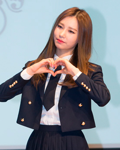

url을 입력하세요(없으면 입력 X): https://100.daum.net/encyclopedia/view/33XXX1396497


  1%|          | 1/114 [00:14<27:36, 14.66s/it]

,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award,naver_people_id,profile_url_main
0,2873,박하이,,가수,여자,"(content_all:(""케니스타 엔터테인먼트 박하이""~10 OR ""가수 박하이""~10))",165,42,None,케니스타 엔터테인먼트,,,,219220,https://all.image.mycelebs.com/2873/2873_1125@1464.jpg


https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&mra=bjky&pkid=1&os=219220&qvt=0&query=박하이


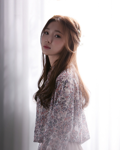

url을 입력하세요(없으면 입력 X): https://100.daum.net/encyclopedia/view/33XXXX914064


  2%|▏         | 2/114 [03:18<3:33:21, 114.30s/it]

,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award,naver_people_id,profile_url_main
0,2877,아리요시 리사,,가수,여자,"(content_all:(""티핑엔터테인먼트 아리요시 리사""~1 OR ""가수 아리요시 리사""~1))",157,45,None,티핑엔터테인먼트,,,,None,https://all.image.mycelebs.com/2877/2877_1125@1464.jpg


https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&mra=bjky&pkid=1&os=None&qvt=0&query=아리요시 리사


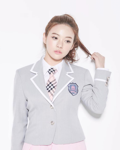

url을 입력하세요(없으면 입력 X): 


  3%|▎         | 3/114 [04:31<2:56:43, 95.53s/it] 

,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award,naver_people_id,profile_url_main
0,2878,황아영,,가수,여자,"(content_all:(""해피페이스 엔터테인먼트 황아영""~10 OR ""가수 황아영""~10))",157,42,None,해피페이스 엔터테인먼트,,,,None,https://all.image.mycelebs.com/2878/2878_1125@1464.jpg


https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&mra=bjky&pkid=1&os=None&qvt=0&query=황아영


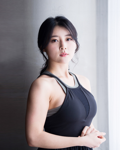

url을 입력하세요(없으면 입력 X): https://100.daum.net/encyclopedia/view/33XXX2086539


  3%|▎         | 3/114 [10:48<6:39:58, 216.20s/it]


OperationalError: (2013, 'Lost connection to MySQL server during query ([Errno 60] Operation timed out)')

In [268]:
conn = db_connection()
cursor = conn.cursor(pymysql.cursors.DictCursor)

craw = []

drv = webdriver.Chrome(ChromeDriverManager().install(), options = webdriver.ChromeOptions())

for i in tqdm(yet_mapping) :
    series_id = i.get('yet_mapping_series_id')
    
    qry = f'SELECT series_id, cd_name, cd_real_name, cd_category, cd_gender, cd_solr_search, cd_height, cd_weight, cd_birth, cd_agency, cd_academic, cd_career, cd_award, naver_people_id, profile_url_main FROM star_ko_data WHERE series_id={series_id}'
    data = pd.read_sql(qry, conn)
    display(data)
    name = data['cd_name'][0]
    naver_people_id = data['naver_people_id'][0]
    cd_img_url = data['profile_url_main'][0]
    
    print(f'https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&mra=bjky&pkid=1&os={naver_people_id}&qvt=0&query={name}')
    
    keywords = ['man', 'woman', 'group']
    result = any(keyword in cd_img_url for keyword in keywords)
    
    if not result:  # 스타ai에 이미지가 있으면
        cd_response = requests.get(cd_img_url)
        cd_img = Image.open(BytesIO(cd_response.content))
        cd_img = cd_img.resize((120, 150))
        display(cd_img)

            
    url = f'https://100.daum.net/search/entry?q={name}'
    drv.get(url)
    
    daum_profile_url = input("url을 입력하세요(없으면 입력 X): ")
    craw_ = {'series_id':i, 'url':daum_profile_url}
    craw.append(craw_)
    
    if daum_profile_url != '' :
        daum_id = re.findall('view/(\S+)', daum_profile_url)[0]
        update_qry = f"UPDATE star_ko_profile_url SET daum_url='{daum_profile_url}', daum_people_id='{daum_id}' WHERE series_id={series_id}"
        cursor.execute(update_qry)
        conn.commit()
        
    else :
        update_qry = f"UPDATE star_ko_profile_url SET daum_url='x' WHERE series_id={series_id}"
        cursor.execute(update_qry)
        conn.commit()
        
conn.close()


In [ ]:
# 자동매핑

In [173]:
yet_mapping

[{'yet_mapping_series_id': 38},
 {'yet_mapping_series_id': 74},
 {'yet_mapping_series_id': 85},
 {'yet_mapping_series_id': 100},
 {'yet_mapping_series_id': 108},
 {'yet_mapping_series_id': 109},
 {'yet_mapping_series_id': 120},
 {'yet_mapping_series_id': 125},
 {'yet_mapping_series_id': 154},
 {'yet_mapping_series_id': 157},
 {'yet_mapping_series_id': 195},
 {'yet_mapping_series_id': 212},
 {'yet_mapping_series_id': 252},
 {'yet_mapping_series_id': 283},
 {'yet_mapping_series_id': 292},
 {'yet_mapping_series_id': 304},
 {'yet_mapping_series_id': 352},
 {'yet_mapping_series_id': 355},
 {'yet_mapping_series_id': 372},
 {'yet_mapping_series_id': 383},
 {'yet_mapping_series_id': 396},
 {'yet_mapping_series_id': 408},
 {'yet_mapping_series_id': 415},
 {'yet_mapping_series_id': 418},
 {'yet_mapping_series_id': 428},
 {'yet_mapping_series_id': 438},
 {'yet_mapping_series_id': 439},
 {'yet_mapping_series_id': 473},
 {'yet_mapping_series_id': 477},
 {'yet_mapping_series_id': 497},
 {'yet_mappin

In [218]:
len(yet_mapping)

738

In [215]:
conn = db_connection()
cursor = conn.cursor(pymysql.cursors.DictCursor)

craw = []
mapping_data = []

# drv = webdriver.Chrome(ChromeDriverManager().install(), options = webdriver.ChromeOptions())

for i in tqdm(yet_mapping) :
    series_id = i.get('yet_mapping_series_id')
    
    qry = f'SELECT series_id, cd_name, cd_real_name, cd_category, cd_gender, cd_solr_search, cd_height, cd_weight, cd_birth, cd_agency, cd_academic, cd_career, cd_award FROM star_ko_data WHERE series_id={series_id}'
    data = pd.read_sql(qry, conn)
    display(data)
    cd_name = data['cd_name'][0]
    cd_gender = data['cd_gender'][0]
    cd_birth = data['cd_birth'][0]
    cd_agency = data['cd_agency'][0]
    try : 
        cd_agency = cd_agency.replace(" ", "")
    except :
        pass
    
    if cd_birth == '0000-00-00 00:00:00':
        cd_birth_ = ''
    elif cd_birth == '':
        cd_birth_ = ''
    elif pd.isnull(cd_birth) :
        cd_birth_ = ''
    else:
        cd_birth_ = cd_birth.strftime('%Y-%m-%d')
    
    url = f'https://100.daum.net/search/entry?q={cd_name}'
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html.parser')
    
    cont_list = soup.select('div[class="cont_list search_result"]')
    
    href_list = []
    
    try :

        for c in range(len(cont_list)) :
            href = cont_list[c].select('a')[0].get('href')
            href_0 = re.findall('view/(\S+)', href)[0]
            href_0 = href_0.replace("X", "")
            
            if href_0.isdigit() :
                real_href = 'https://100.daum.net' + href
                href_list.append(real_href)

        for h in range(len(href_list)) :
            birth = gender = agency = ''
            
            u = href_list[h]
            html_ = requests.get(u).text
            soup_ = BeautifulSoup(html_, 'html.parser')
            print(u)

            list = soup_.select('span[class=inner_summary]')

            for j in range(len(list)):

                title = list[j].text
                inner = list[j].parent.findNext('td').text
                if title == '출생':
                    if ',' in inner:
                        spl = inner.split(',')[0].split()
                        year = re.sub("\D", "", spl[0]).zfill(4)
                        month = re.sub("\D", "", spl[1]).zfill(2)
                        day = re.sub("\D", "", spl[2]).zfill(2)
                        birth = "{0}-{1}-{2}".format(year, month, day)

                    else:
                        spl = inner.split()
                        if len(spl) == 3:
                            year = re.sub("\D", "", spl[0]).zfill(4)
                            month = re.sub("\D", "", spl[1]).zfill(2)
                            day = re.sub("\D", "", spl[2]).zfill(2)
                            birth = "{0}-{1}-{2}".format(year, month, day)

                elif title == "소속":
                    agency = inner.strip()
                    agency = agency.replace(" ", "")

                elif title == "성별":
                    if "남" in inner:
                        gender = "남자"
                    elif "여" in inner:
                        gender = "여자"
                    elif inner == "혼성":
                        gender = "남자,여자"

                if birth == '' :

                    if agency == '' or cd_agency == '' :
                        pass
                    
                    elif agency == cd_agency :
                        print("성공 - 소속사")
                        mapping_data_ = {'series_id': series_id, 'name': cd_name, 'daum': u}
                        mapping_data.append(mapping_data_)
                        raise NotImplementedError


                else :
                    if gender == '' or cd_gender == '' or birth == '' or cd_birth_ == '': 
                        pass
                    
                    
                    elif birth == cd_birth_ and gender == cd_gender :
                        print("성공 - 생일/성별")
                        mapping_data_ = {'series_id': series_id, 'name': cd_name, 'daum': u}
                        mapping_data.append(mapping_data_)
                        raise NotImplementedError
                        
    except :
        pass
    
conn.close()

  0%|          | 0/738 [00:00<?, ?it/s]

,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,38,강용석,,"변호사, 정치인",남자,"(content_all:(title : ""강용석"" AND""기자"" OR ""방송인 강용석""~10 OR ""변호사 강용석""~10))",None,None,1969-12-03,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX160967
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,74,구지성,,방송인,여자,"(content_all:(title:""구지성""AND""기자""NOT""딸""NOT""남편""NOT""스폰""NOT""스폰서""NOT""아들""))",173,49,1983-01-07,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX72053
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,85,기욤 패트리,Guillaume Patry,방송인,남자,"(content_all:(title:""기욤 패트리""AND""기자""))",183,80,1982-06-19,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX32859
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,100,김규리,,배우,여자,"(content_all:((title:""김규리"" -title:""강수지"")AND""기자""NOT""감독""NOT""골프""))",168,46,1979-08-16,웅빈이엔에스,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX17900
https://100.daum.net/encyclopedia/view/33XXXXX17561
https://100.daum.net/encyclopedia/view/33XXX2096170
https://100.daum.net/encyclopedia/view/33XXX1713296
https://100.daum.net/encyclopedia/view/33XXX1603766
https://100.daum.net/encyclopedia/view/33XXX2190070


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,108,김동주,,운동선수,남자,"(content_all:(title:""김동주""AND""기자""AND""야구""))",180,94,1976-02-03,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX31809
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,109,김동현,김호성,배우,남자,"(content_all:(title:""김동현""AND""기자""AND""배우""))",176,80,1950-06-10,,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,120,김민지,,방송인,여자,"(content_all:((title:""김민지""-title:""박지성"")AND""기자""AND""아나운서""))",163,None,1985-08-14,,"이화여자대학교 서양화학, 방송영상학 학사 외 1건",,


https://100.daum.net/encyclopedia/view/33XXXX538016
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,125,김보경,,운동선수,남자,"(content_all:(title:""김보경""AND""기자""AND""축구""))",178,73,1989-10-06,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX228747
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,154,김영애,,배우,여자,"(content_all:(title:""김영애""AND ""기자"" NOT ""휴먼다큐"" NOT ""사람이 좋다"" NOT ""이영돈"" NOT ""아침마당""))",160,53,1951-04-21,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18714
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,157,김영희,,개그맨,여자,"(content_all:(title:""김영희"" AND type:news AND(""개그맨"" OR ""개그우먼"" OR ""코미디언"")))",None,None,1983-08-23,,영남이공대학 영상제작학과,희망서울 홍보대사,KBS 연예대상 코미디부문 여자 최우수상


https://100.daum.net/encyclopedia/view/33XXXX545617
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,195,김창환,,배우,남자,"(content_all:(title:""김창환"" AND ""기자"" AND ""배우"" NOT ""그남자의기억법"" NOT ""김세연"" NOT ""회장""))",172,65,1986-09-01,메이크위드,,,


https://100.daum.net/encyclopedia/view/33XXXXX30311


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,212,김혜리,,배우,여자,"(content_all:(title:""김혜리"" AND ""기자""NOT""트로트""NOT""축구""NOT""김혜리 기자""NOT""21""))",167,49,1969-12-23,국엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18881
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,252,다니엘 린데만,Daniel Lindemann,방송인,남자,"(content_all:(title:""다니엘 린데만""AND""기자""))",None,None,1985-10-16,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1697332
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,283,로빈 데이아나,Robin Deiana,방송인,남자,"(content_all:(title:""로빈데이아나""AND""기자""))",183,66,1990-07-18,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1683552
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,292,류지혜,,"방송인,모델",여자,"(content_all:(title:""류지혜"" AND ""기자""))",175,None,1989-10-28,핸즈모터스포츠,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX169767
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,304,메이 퀸,,가수,여자,"(content_all:(title:""가수 메이퀸"" AND ""기자""))",None,None,None,,None,None,None


https://100.daum.net/encyclopedia/view/89XX25800050
https://100.daum.net/encyclopedia/view/33XXX1122572
https://100.daum.net/encyclopedia/view/33XXX1430413
https://100.daum.net/encyclopedia/view/44XX23000022


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,352,박승희,,운동선수,여자,"(content_all:(title:""박승희"" AND""기자"" AND(""국가대표"" OR ""선수"" OR ""쇼트트랙"" OR ""디자이너"" OR ""어썸프로젝트컴퍼니"") NOT""개그맨"" NOT""쇼핑""))",167,57,1992-03-28,어썸프로젝트컴퍼니,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX68371
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,355,박시현,박은경,"방송인,모델",여자,"(content_all:(title:""박시현"" AND""기자"" AND(""레이싱"")))",170,48,1987-08-31,로드FC엔터테인먼트,,,2014 제3회 한국 레이싱모델 어워즈 최우수 모델상


https://100.daum.net/encyclopedia/view/33XXX1150661
https://100.daum.net/encyclopedia/view/33XXXX239627
https://100.daum.net/encyclopedia/view/33XXXXX66922
https://100.daum.net/encyclopedia/view/33XXX1222784
https://100.daum.net/encyclopedia/view/33XXXX732485
https://100.daum.net/encyclopedia/view/33XXX1205303


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,372,박준규,박준규,배우,남자,"(content_all:(title:""박준규"" AND""기자"" NOT""바비킴""))",173,None,1964-06-27,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX17793
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,383,박태환,,운동선수,남자,"(content_all:((title:""박태환"" -title:""황선우"" -title:""신예찬"" -title:""넘었다"" -title:""넘은"" -title:""넘어선"") AND ""기자"" NOT""황선우"" NOT""신예찬"" NOT""루시"" NOT""샛별"" NOT""포스트"" NOT""제2의"" NOT""우상"" NOT""고교생"" NOT""고등학교"" NOT""서울체고""))",183,74,1989-09-27,,None,2014 제17회 인천 아시안게임 남자 수영 국가대표 그 외 4건,None


https://100.daum.net/encyclopedia/view/33XXXXX24384
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,396,배지현,배지현,아나운서,여자,"(content_all:(title:""배지현"" AND""기자""))",173,50,1987-01-22,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX911532
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,408,백청강,,가수,남자,"(content_all:(title:""백청강""AND ""기자"" ) )",165,60,1989-02-19,페이스엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX904942


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,415,벨라코프 일리야,,방송인,남자,"(content_all:(title:""벨라코프일리야"" AND ""기자""))",None,None,None,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1740312


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,418,변정수,,"배우,모델",여자,"(content_all:(title:""변정수""AND ""기자""))",174,53,1974-04-15,아이오케이컴퍼니,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX19476
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,428,블레어 윌리엄스,,방송인,남자,"(content_all:(title:""블레어 윌리엄스"" AND ""기자""))",None,None,None,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1740315


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,438,빈지노,임성빈,가수,남자,"(content_all:((title:""빈지노"" -title:""미초바"" title:""Beenzino"") AND ""기자"" NOT ""지플랫""))",182,63,1987-09-12,,서울대학교 조소학과,,


https://100.daum.net/encyclopedia/view/33XXXX635032
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,439,사유리,후지타 사유리/Fujita Sayuri,방송인,여자,"(content_all:(title:""사유리"" AND""기자""))",164,None,1979-10-13,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX113809
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,473,성준,방성준,배우,남자,"(content_all:(title:""성준"" AND ""기자"") AND(""배우 성준"" or ""방성준"") )",187,None,1990-07-10,오앤엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX475883
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,477,박서안,박세준,가수,남자,"(content_all:((title:""세준"" title:""서안"") AND type:news AND(""배우"" OR ""스피드"")))",180,67,1993-12-10,MBK엔터테인먼트,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,497,손연재,,운동선수,여자,"(content_all:(title:""손연재"" AND ""기자""))",165,49,1994-05-28,리프스튜디오,연세대학교 스포츠레저학과 외 2건,2014 제17회 인천 아시안게임 여자 체조 국가대표 외 11건,


https://100.daum.net/encyclopedia/view/33XXXX238127
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,504,손호준,,배우,남자,"(content_all:(title:""손호준"" AND type:news))",181,67,1984-06-27,YG엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX30308
https://100.daum.net/encyclopedia/view/33XXX2171929
https://100.daum.net/encyclopedia/view/33XXX2092483


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,513,송영길,,개그맨,남자,"(content_all:(title:""송영길"" AND ""기자"" AND ""개그맨"" NOT ""의원"" ))",172,90,1984-12-29,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX31411
https://100.daum.net/encyclopedia/view/33XXXX689119
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,516,송서율,,배우,여자,"(content_all:(title:""송서율"" AND ""기자""))",162,44,1985-02-18,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX213867
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,523,송창식,,가수,남자,"(content_all:(title:""송창식"" AND ""기자"" NOT ""야구""))",None,None,1947-02-02,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX22255
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,530,수잔 사키야,,방송인,남자,"(content_all:(title:""수잔 샤키야"" AND ""기자"" ))",None,None,None,,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,552,신아영,신아영,"방송인, 아나운서",여자,"(content_all:(title:""신아영"" AND ""기자"" ))",None,None,1987-02-18,스타잇엔터테인먼트,하버드대학교 역사학과 학사,UN SDGs 지원 한국협회 홍보대사,None


https://100.daum.net/encyclopedia/view/33XXXX956805
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,556,신은경,신은경,배우,여자,"(content_all:(title:""신은경"" AND""기자""))",171,47,1973-02-15,지담,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX19375
https://100.daum.net/encyclopedia/view/33XXXXX19374
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,592,알리,,가수,여자,"(content_all:(title: ""알리"" AND ""기자"" AND""가수 알리""))",None,None,1984-11-20,,None,None,None


https://100.daum.net/encyclopedia/view/46XXX8900499
https://100.daum.net/encyclopedia/view/157X2015063000024
https://100.daum.net/encyclopedia/view/33XXXX496865
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,593,알베르토 몬디,Alberto Mondi,방송인,남자,"(content_all:(title:""알베르토 몬디"" AND ""기자""NOT""아내""))",None,None,1984-01-17,JTBC스튜디오,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1683549
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,603,양학선,,운동선수,남자,"(content_all:(title:""양학선"" AND ""기자"" ))",160,51,1992-12-06,위너스포츠에이전시,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX544233
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,626,연지은,,"방송인,모델",여자,"(content_all:(title:""연지은"" AND ""기자""))",170,48,1993-08-25,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1640909


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,647,온주완,송정식,배우,남자,"(content_all:(title:""온주완"" AND ""기자"" ))",180,60,1983-12-11,윌엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18033
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,668,유선,,배우,여자,"(content_all:(title:""유선"" AND type:news AND(""배우 유선""~5 OR ""블레스이엔티"") NOT""한솥밥""))",166,46,None,블레스이엔티,None,None,None


https://100.daum.net/encyclopedia/view/48XXX9002033
https://100.daum.net/encyclopedia/view/48XXX9002031
https://100.daum.net/encyclopedia/view/48XXX9002032


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,673,유아인,엄홍식,배우,남자,"(content_all:(title:""유아인"" AND""기자"" NOT""정철승""))",181,62,1986-10-06,United Artists Agenc,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18910


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,716,이광기,,배우,남자,"(content_all:(title:""이광기"" AND ""기자"" AND (""탤런트 이광기""~10 OR ""배우 이광기""~10)))",175,None,1969-04-10,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18090
https://100.daum.net/encyclopedia/view/33XXX1612030
https://100.daum.net/encyclopedia/view/33XXX1739430
https://100.daum.net/encyclopedia/view/33XXX1144505


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,717,이광수,,배우,남자,"(content_all:((title:""이광수"" title:""광수"" -title:""이선빈"") AND ""기자"" NOT""이선빈"" NOT""아쵸"" NOT""친일문학인"" NOT""선빈"" NOT""미모"" NOT""열애""))",190,78,1985-07-14,스타쉽엔터테인먼트(킹콩 by 스타쉽),None,None,None


https://100.daum.net/encyclopedia/view/60XX68900030
https://100.daum.net/encyclopedia/view/63XX19000091
https://100.daum.net/encyclopedia/view/33XXXX214108
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,727,이만기,,운동선수,남자,"(content_all:((title:""이만기"" -title:""한숙희"") AND ""기자""))",182,100,1963-07-29,,중앙대학교 대학원 체육교육학 박사 외 2건,2013 대장경세계문화축전 홍보대사 외 12건,2014 SBS 연예대상 베스트 커플상 외 4건


https://100.daum.net/encyclopedia/view/33XXXXX29898
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,729,이미숙,,배우,여자,"(content_all:(title:""이미숙"" AND ""기자"" AND ""배우 이미숙""~10 NOT ""타짜"" NOT ""비극의 시작"" ))",160,None,1960-04-02,,None,None,None


https://100.daum.net/encyclopedia/view/94X9214054212
https://100.daum.net/encyclopedia/view/33XXXXX18410
https://100.daum.net/encyclopedia/view/33XXX1256912
https://100.daum.net/encyclopedia/view/33XXX1256833


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,732,이민기,,배우,남자,"(content_all:(title:""이민기"" AND type:news AND""배우 이민기""~5 NOT""Minki"" NOT""한솥밥""))",183,68,1985-01-16,,건국대학교 영화예술학,건국대학교 홍보대사,제46회 백상예술대상 영화부문 남자 신인연기상


https://100.daum.net/encyclopedia/view/33XXXXX18175
https://100.daum.net/encyclopedia/view/33XXXX620524
https://100.daum.net/encyclopedia/view/33XXX1858052
https://100.daum.net/encyclopedia/view/33XXX1283172
https://100.daum.net/encyclopedia/view/33XXX1712866
https://100.daum.net/encyclopedia/view/33XXX1283201
https://100.daum.net/encyclopedia/view/33XXX1853584
https://100.daum.net/encyclopedia/view/33XXX1283002
https://100.daum.net/encyclopedia/view/33XXX1360467


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,742,이상화,,운동선수,여자,"(content_all:((title:""이상화"" -title:""강남"") AND ""기자"" AND (""스케이트 ""OR ""국가대표"" OR ""빙속"")))",168,55,1989-02-25,본부이엔티,None,None,None


https://100.daum.net/encyclopedia/view/60XX68900063


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,747,이소라,,가수,여자,"(content_all:(""가수 이소라"" AND ""기자"" NOT ""대출""))",164,None,1969-12-29,에르타알레 엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18820
https://100.daum.net/encyclopedia/view/33XXXXX20441
https://100.daum.net/encyclopedia/view/33XXXXX27560
https://100.daum.net/encyclopedia/view/33XXXX532363
https://100.daum.net/encyclopedia/view/33XXX2095677
https://100.daum.net/encyclopedia/view/33XXX2210133
https://100.daum.net/encyclopedia/view/157X2009071503155
https://100.daum.net/encyclopedia/view/157X2009071503157


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,750,이수경,,배우,여자,"(content_all:(title:""이수경"" AND ""기자"" AND ""배우 이수경""~10 AND (""씨제스엔터테인먼트"" OR ""응답하라 1998"")))",170,None,1996-10-24,씨제스엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18649


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,753,이수정,이수정,"배우,모델",여자,"(content_all:(title:""이수정"" AND type:news AND (""배우 이수정"" OR ""방송인 이수정"") NOT ""범죄"" NOT ""교수"" NOT ""맥주"" ))",175,None,1987-09-17,,대덕대학 엔터테인먼트과,,2014 2014 케이블TV 방송대상 TV스타상 외 2건


https://100.daum.net/encyclopedia/view/33XXX1298896


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,756,이승연,,배우,여자,"(content_all:(title:""이승연"" AND""기자"" AND(""미스 코리아"" OR ""매니지먼트 이상"") AND""배우 이승연""~5))",170,49,1968-08-18,매니지먼트 이상,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX19086
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,768,이용대,,운동선수,남자,"(content_all:(title:""이용대""AND ""기자"" NOT ""최병철""))",180,73,1988-09-11,,None,2016 인도네시아오픈 배드민턴 슈퍼시리즈프리미어 남자복식 1위 그 외 3건,None


https://100.daum.net/encyclopedia/view/33XXXXX34804
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,773,이은혜,,모델,여자,"(content_all:((title:""이은혜"" -title:노지훈) AND ""기자"" AND ""레이싱모델"" ))",171,49,1987-06-26,,,,


https://100.daum.net/encyclopedia/view/33XXX1151223
https://100.daum.net/encyclopedia/view/33XXXX182255
https://100.daum.net/encyclopedia/view/33XXXXX18604
https://100.daum.net/encyclopedia/view/33XXXXX25442
https://100.daum.net/encyclopedia/view/33XXX1591604
https://100.daum.net/encyclopedia/view/33XXXX220107
https://100.daum.net/encyclopedia/view/33XXX1553266
https://100.daum.net/encyclopedia/view/33XXX1348172


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,775,이재은,,아나운서,여자,"(content_all:(title:""이재은"" AND""기자"" AND""아나운서"" NOT""트로트""))",None,None,1988-03-13,,"이화여자대학교 방송영상학, 언론정보학 학사 졸업",,


https://100.daum.net/encyclopedia/view/33XXXXX18874
https://100.daum.net/encyclopedia/view/33XXX1277089
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,779,이정민,,방송인,여자,"(content_all:(""방송인 이정민""~10 OR ""아나운서 이정민""~10 OR ""아나 이정민""~10)) NOT (content_all:(""이정민 기자""~10))",None,None,1980-05-12,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX27949
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,787,이준기,,배우,남자,"(content_all:((title:""이준기"" -title:""종합"" ) AND ""기자"" NOT ""노무현"" NOT ""황인엽""))",178,63,1982-04-17,나무엑터스,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18289
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,791,이채영,이보영,배우,여자,"(content_all:(title:""이채영"" AND""기자""))",170,50,1986-04-29,싸이더스HQ,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX70927
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,806,이현우,,배우,남자,"(content_all:((title:""이현우"" -title:""한솥밥"") AND ""기자"" AND ""배우 이현우""~10))",None,None,None,어썸이엔티,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX88607
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,807,이현주,,방송인,여자,"(content_all:(title:""이현주"" AND""기자"" AND""아나운서""))",None,None,1984-01-13,,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,808,이혜영,,배우,여자,"(content_all:(title:""이혜영"" AND""기자"" AND(""방송인"" OR ""화가"" OR ""가수"" OR ""탤런트"" OR ""인스타그램"" OR ""에스팀"") NOT""블루드래곤""))",168,47,1971-12-22,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX17315
https://100.daum.net/encyclopedia/view/33XXXXX17862
https://100.daum.net/encyclopedia/view/33XXXXX70656
https://100.daum.net/encyclopedia/view/33XXX1241208
https://100.daum.net/encyclopedia/view/33XXXX139307
https://100.daum.net/encyclopedia/view/33XXX1684739
https://100.daum.net/encyclopedia/view/33XXX1562241


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,824,임주은,,배우,여자,"(content_all:(title:""임주은"" AND ""기자""))",166,45,1988-01-07,지트리크리에이티브,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX28629
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,826,임지연,,배우,여자,"(content_all:(title:""임지연"" AND ""기자"" AND ""배우 임지연""~10 ))",166,48,1990-06-23,아티스트컴퍼니,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1500556
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,827,임지혜,,방송인,여자,"(content_all:(title:""임지혜"" AND ""기자"" AND ""레이싱모델""))",172,49,1988-02-14,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX25811
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,831,장근석,Jang Keun Suk,배우,남자,"(content_all:(title:""장근석"" AND ""기자"" ))",182,62,1987-08-04,AG Corporation,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18061
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,837,장미란,,운동선수,여자,"(content_all:((title:""장미란"" -title:""넘어선"" -title:""리틀"") AND""기자"" NOT""박혜정""))",170,114,1983-10-09,장미란재단 이사장,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX31774
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,842,장예원,,방송인,여자,"(content_all:(title:""장예원"" AND ""기자""))",166,None,1990-07-14,SM C&C,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1413432
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,843,장위안,Zhang Yuan,방송인,남자,"(content_all:(title:""장위안"" AND ""기자""))",None,None,1984-03-04,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1683550
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,846,장들레,,가수,여자,"(content_all:((title:""하노"" title:""장들레"") AND(""아몬드"" OR ""싱어송라이터"" OR ""아티스트"" OR ""가수"") NOT""베트남"" NOT""하와이"" NOT""프리미엄""))",None,None,1991-11-30,,호원대학교 실용음악과,None,None


https://100.daum.net/encyclopedia/view/72XXXXXX5359
https://100.daum.net/encyclopedia/view/72XXXXXX5199
https://100.daum.net/encyclopedia/view/72XXXXXX4664
https://100.daum.net/encyclopedia/view/72XXXXX11543


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,848,장현성,,배우,남자,"(content_all:(title:""장현성"" AND ""기자"" ))",None,None,1970-07-17,YG엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX17269
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,859,전현무,,방송인,남자,"(content_all:((title:""전현무"" -title:이혜성 -title:한솥밥) AND ""기자"" NOT 한지민))",171,77,1977-11-07,SM C&C,"연세대학교 영어영문학, 사회학 학사 외 1건",,2014 MBC 방송연예대상 쇼버라이어티부문 남자우수상 외 4건


https://100.daum.net/encyclopedia/view/33XXXXX19026
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,861,전혜진,전이다,배우,여자,"(content_all:((title:""전혜진"" -title:""이선균"" -title:""한솥밥"") AND ""기자"" AND (""호두앤유엔터테인먼트"" OR ""이선균"" OR ""배우 전혜진""~20) NOT ""이천희"" NOT ""은실이""))",171,49,1976-01-01,호두앤유엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX17446
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,863,정가은,,"배우,모델",여자,"(content_all: (title : ""정가은"") AND""기자"" AND(""배우 정가은"" or ""모델 정가은"") )",170,50,None,더블브이 엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX33463


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,876,정우,김정국,배우,남자,"(content_all:((title : ""정우"" -title:""김유미"")AND type:news AND""배우 정우""~5 NOT ""하정우""))",180,70,1981-01-14,BH엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/157X2009071504432
https://100.daum.net/encyclopedia/view/157X2009071504426
https://100.daum.net/encyclopedia/view/157X2009071504427


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,884,정인영,,방송인,여자,"(content_all:(title:""정인영"" AND""기자"" AND""아나운서""))",None,None,1985-10-22,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1103424
https://100.daum.net/encyclopedia/view/33XXXXX67512
https://100.daum.net/encyclopedia/view/33XXXX937560
https://100.daum.net/encyclopedia/view/33XXXXX22868
https://100.daum.net/encyclopedia/view/33XXX1185885


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,891,정지원,,방송인,여자,"(content_all:((title:""정지원"" -title:""소준범"") AND ""기자"" AND ""아나운서 정지원""~10))",168,49,1985-06-20,KBS,연세대학교 신문방송학과 졸업,None,None


https://100.daum.net/encyclopedia/view/33XXXX689870
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,906,조세희,,모델,여자,"(content_all:(title:""조세희"" AND""기자"" AND(""티아라"" OR ""레이싱"" OR ""모터미디어"")))",170,46,1988-02-27,카앤모델,None,None,None


https://100.daum.net/encyclopedia/view/60XX69700047
https://100.daum.net/encyclopedia/view/33XXXXX75439
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,911,조용필,,가수,남자,"(content_all:((title:""조용필"" ) AND ""기자"" AND""가수 조용필"" NOT 미스터트롯 NOT 히든싱어))",166,56,1950-03-21,,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,925,주다하,,모델,여자,"(content_all:(""모델 주다하""~10 OR ""핸즈모터스포츠 주다하""~10 OR ""레이싱모델 주다하""~10))",173,50,1985-12-16,핸즈모터스포츠,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX486983


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,931,주지훈,,배우,남자,"(content_all:(title:""주지훈"" AND""기자"" NOT""한솥밥""))",187,68,1982-05-16,에이치앤드엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX20442
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,935,줄리안 퀸타르트,Julian Quintart,방송인,남자,"(content_all:(title:""줄리안 퀸타르트"" AND ""기자"" AND (""방송인 줄리안""~10 OR ""줄리안 퀸타르트"" OR ""벨기에 줄리안""~10) ))",181,70,1987-08-24,비엔비엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1683548
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,936,줄리엔강,Julian Kang,방송인,남자,"(content_all:(title :""줄리엔강"" AND ""기자""))",191,87,1982-04-11,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX34532
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,945,지창욱,,배우,남자,"(content_all:(title:""지창욱"" AND type:news ))",180,65,1987-07-05,글로리어스엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX223087
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,947,진경,,배우,여자,"(content_all:(title:""진경"" AND ""기자"" AND (""배우 진경""~10 OR ""드라마"" OR ""영화"") NOT ""출생"" NOT ""출처"" ))",166,None,None,YG 엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX724535
https://100.daum.net/encyclopedia/view/33XXXX537586
https://100.daum.net/encyclopedia/view/33XXX1201331
https://100.daum.net/encyclopedia/view/63XX67600073


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,955,차두리,,운동선수,남자,"(content_all:((title:""차두리"" -title:""한채아"" -title:""차세찌"") AND ""기자"" NOT ""가두리"" NOT ""독일어"" NOT ""코로나 확진"" ))",None,None,None,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX31241


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,957,차예련,,배우,여자,"(content_all:(title:""차예련"" AND type:news))",172,48,1985-07-16,HB엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18629
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,968,천이슬,,"배우,모델",여자,"(content_all:(title:""천이슬"" AND type:news))",166,47,1989-10-06,팬스타즈컴퍼니,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX543481
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,979,최슬기,,방송인,여자,"(content_all:(title:""최슬기"" AND ""기자"" AND (""레이싱 모델"" OR ""가수 최슬기""~10)))",168,45,1986-02-13,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1978741
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,984,최지우,,배우,여자,"(content_all:((title:""최지우"" -title:""종합"" -title:""한솥밥"" -title:""호흡"")AND ""기자"" ))",None,None,None,YG엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18576
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,988,최화정,,"방송인,배우",여자,"(content_all:((title:""최화정""-title:""파워타임"") AND ""기자"" ))",164,49,None,피엘케이굿프렌즈,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX17578
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,989,최희,,방송인,여자,"(content_all:(title:""최희"" AND ""기자"" NOT ""최희수"" NOT ""최희서"" ))",None,None,1986-07-18,샌드박스네트워크,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX538014
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,990,추성훈,秋山成勳,운동선수,남자,"(content_all:(title:""추성훈"" ) AND ""기자"" NOT(""추사랑"" or ""사랑이""))",177,84,1975-07-29,본부이엔티,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX23034
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,998,크러쉬,신효섭,가수,남자,"(content_all:(title:""크러쉬"" AND ""기자"" AND""가수"" NOT""모모랜드""))",None,None,1992-05-03,피네이션,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1299622
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1004,타일러 라쉬,Tyler Rasch,방송인,남자,"(content_all:(title :""타일러 라쉬"" title:""타일러"" AND ""기자"") AND(""방송인 타일러"")NOT(""농구"") )",None,None,None,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1683551


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1005,타쿠야,테라다 타쿠야/Takuya/寺田拓哉,"배우,가수",남자,"(content_all:(title:""타쿠야"" AND type:news AND(""크로스진"" OR ""테라다 타쿠야"" OR ""비정상회담"" OR ""디퍼런트컴퍼니"" OR ""외국인"" OR ""비디오스타"") NOT""기무라"" NOT""한솥밥"" NOT""야구""))",188,67,1992-03-18,디퍼런트컴퍼니,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX924160
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1016,투하트,Toheart,가수,남자,"(content_all:(title:""투하트"" AND type:news AND(""Toheart"" OR ""샤이니"" OR ""인피니트"" OR ""남우현"" OR ""우현"" OR ""키"")))",None,None,None,"SM엔터테인먼트, 울림엔터테인먼트",None,None,None


https://100.daum.net/encyclopedia/view/33XXX1631192
https://100.daum.net/encyclopedia/view/34XXXXX82977


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1047,한예리,김예리,배우,여자,"(content_all : (title : ""한예리"") AND""기자"" AND(""배우 한예리""))",None,None,1984-12-23,사람엔터테인먼트,한국예술종합학교 전통예술원 한국무용과,None,None


https://100.daum.net/encyclopedia/view/33XXXX542358
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1050,한지민,,배우,여자,"(content_all:((title:""한지민"" -title:""홍현희"" -title:""설하윤"" )AND ""기자"" NOT""닮은꼴"" NOT""설하윤"" NOT""조권"" NOT""트로트""))",160,43,1982-11-05,BH엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX19403
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1063,허지웅,,"방송인, 작가",남자,"(content_all:(title : ""허지웅"") AND ""기자"" NOT(""허지웅쇼""))",None,None,1979-12-14,,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX481703
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1066,헨리,,"가수, 방송인",남자,"(content_all:(title:""헨리""AND ""기자"" ))",178,None,1989-10-11,몬스터엔터테인먼트그룹,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1071,혜리,,가수,여자,"(content_all:((title:""혜리"" -title:""류준열"") AND ""기자"" AND (""걸스데이"" OR ""배우 혜리""~5)))",167,47,1994-06-09,크리에이티브그룹 아이엔지,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX543144
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1080,홍수아,,배우,여자,"(content_all:(title:""홍수아"" AND ""기자""))",168,44,1986-06-30,드림티엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18704
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1081,홍수현,,배우,여자,"(content_all:(title:""홍수현"" AND ""기자"" NOT ""초콜릿""))",169,47,1981-02-15,FN엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX18771
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1091,황승언,,"영화배우, 방송인",여자,"(content_all:(title: ""황승언"") AND ""기자"" AND (""배우 황승언""))",167,46,1988-10-31,씨제스엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/48XXX9003448
https://100.daum.net/encyclopedia/view/33XXXX476903
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1093,황우슬혜,,배우,여자,"(content_all:(title: ""황우슬혜"") AND ""기자"" AND (""배우 황우슬혜""))",168,45,1979-08-10,스튜디오 산타클로스엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX215127
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1103,송소희,,가수,여자,"(content_all:(title:""송소희""AND""기자""))",163,43,1997-10-20,SH 파운데이션,단국대학교 국악과,2015 청소년 적십자 단체 홍보대사 외 9건,2010 한국을 빛낸 자랑스런 한국인 대상 외 다수


https://100.daum.net/encyclopedia/view/33XXXX475964
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1109,MC그리,김동현,가수,남자,"(content_all:((title:""래퍼 그리""~3 OR title: ""MC그리"" -title:""김구라"") AND ""기자"" NOT ""동상이몽""))",174,62,1998-11-10,브랜뉴뮤직,풍무고등학교,,


https://100.daum.net/encyclopedia/view/33XXXX170187
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1114,강민수,,방송인,남자,"(content_all:(""방송인 강민수""~10 OR ""앵커 강민수""~10 OR ""기자 강민수""~10))",None,None,1974-09-23,,고려대학교 영어영문학과,2003 KBS 정치외교부 기자 외 1건,2013 이달의 방송기자상 외 6건


https://100.daum.net/encyclopedia/view/33XXX1748991
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1122,강승현,강승현/Kang Seung-hyun,모델,여자,"(content_all:(title:""강승현"" AND ""기자"" AND (""모델 강승현""~10 OR ""배우 강승현""~10)))",178,51,1987-09-22,,동덕여자대학교 모델학과 학사 졸업,,2008년 포드 슈퍼모델 오브 더 월드 1위


https://100.daum.net/encyclopedia/view/33XXXXX81987
https://100.daum.net/encyclopedia/view/33XXXX154347
https://100.daum.net/encyclopedia/view/33XXX2101070
https://100.daum.net/encyclopedia/view/33XXX2163447


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1127,강철웅,,모델,남자,"(content_all:(title:""강철웅"" AND ""기자"" AND ""모델 강철웅""~10))",187,None,1987-11-30,,,,


https://100.daum.net/encyclopedia/view/33XXXX543559
https://100.daum.net/encyclopedia/view/33XXX1678378
https://100.daum.net/encyclopedia/view/33XXX1152601
https://100.daum.net/encyclopedia/view/33XXX1146169
https://100.daum.net/encyclopedia/view/33XXX1172997


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1131,강희,,모델,남자,"(content_all:(title:""강희"" AND ""기자"" AND ""모델 강희""~10))",188,None,1991-11-19,"YG엔터테인먼트, YG케이플러스",,,


https://100.daum.net/encyclopedia/view/33XXXXX69185
https://100.daum.net/encyclopedia/view/33XXX1774205
https://100.daum.net/encyclopedia/view/33XXX1114579
https://100.daum.net/encyclopedia/view/33XXX1143965


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1135,고보결,,배우,여자,"(content_all:(title:""고보결"" AND ""기자""))",165,45,1988-05-02,하이스토리 디앤씨,서울예술대학교 연기과 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1623318
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1136,고소현,,모델,여자,"(content_all:(title:""고소현"" AND ""기자"" AND ""모델 고소현""~10 NOT 박원순))",168,46,1990-04-11,에스팀,이화여자대학교 컴퓨터공학과,,


https://100.daum.net/encyclopedia/view/33XXX1548967
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1137,고운,문유정,가수,여자,"(content_all:(""베리굿 고운""~10 NOT ""twitter"" OR ""걸그룹 베리굿 고운""~10 OR ""제이티지엔터테인먼트 고운""~10 NOT ""속옷"" NOT ""이영지"" NOT ""티파니""))",167,46,1998-12-28,아시아브릿지엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/157X2012052500003
https://100.daum.net/encyclopedia/view/33XXX1748997
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1139,고정아,,"모델,방송인",여자,"(content_all:(""방송인 고정아""~10 OR ""방송인 고정아""~10 OR ""레이싱모델 고정아""~10 OR ""모델 고정아""~10))",None,None,None,,,,


https://100.daum.net/encyclopedia/view/33XXXX799370


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1142,공태영,,방송인,남자,"(content_all:(""MC 공태영""~10 OR ""방송인 공태영""~10 OR ""대학교수 공태영""~10))",179,76,None,,동국대학교 영상대학원 영화영상제작학 졸업,,


https://100.daum.net/encyclopedia/view/33XXXXX77595
https://100.daum.net/encyclopedia/view/33XXX1847052


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1145,곽민준,,"배우,방송인",남자,"(content_all:(title:""곽민준"" AND ""기자"" AND (""얼짱시대"" OR ""방송인 곽민준""~10 OR ""얼짱"") ))",179,58,1992-11-04,더믹스쳐 대표,,,


https://100.daum.net/encyclopedia/view/33XXX1413663
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1146,곽정은,,방송인,여자,"(content_all:(title:""곽정은"" AND ""기자""))",None,None,1978-12-10,,서강대학교 영문학 학사,코스모폴리탄 피쳐 에디터,


https://100.daum.net/encyclopedia/view/33XXX1552669


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1147,구봉서,,개그맨,남자,"(content_all:(""개그맨 구봉서""~10 OR ""코미디언 구봉서""~10))",None,None,1926-11-05,,대동상업고등학교,,


https://100.daum.net/encyclopedia/view/33XXXXX21795
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1148,구재이,,"배우,모델",여자,"(content_all:(title:""구재이"" AND type:news NOT ""귀여운"" NOT ""아들""))",172,None,1986-02-28,,이화여자대학교 무용학과,,


https://100.daum.net/encyclopedia/view/33XXXX195007
https://100.daum.net/encyclopedia/view/33XXX1065828


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1150,굴사남,Gulsanam,방송인,남자,"(content_all:(""방송인 Gulsanam""~10 OR ""방송인 굴사남""~10))",156,43,1988-10-12,,우즈베키스탄 국립음악원,,


https://100.daum.net/encyclopedia/view/33XXX1435230


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1151,권미란,,방송인,여자,"(content_all:(""MC 권미란""~10 OR ""방송인 권미란""~10 OR ""쇼핑호스트 권미란""~10))",None,None,None,,,,


https://100.daum.net/encyclopedia/view/33XXX1330007
https://100.daum.net/encyclopedia/view/33XXX2108474
https://100.daum.net/encyclopedia/view/33XXXX988307


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1153,권율,,배우,남자,"(content_all:(title:""권율"" AND ""기자"" NOT ""정액권"" NOT ""며느라기재방송"" ))",181,None,1982-06-29,사람엔터테인먼트,예일 대학교 로스쿨 법학 박사 외 1건,,2016 제8회 스타일 아이콘 아시아 어썸 스포트라이트


https://100.daum.net/encyclopedia/view/63XX20600022
https://100.daum.net/encyclopedia/view/63XX66000057
https://100.daum.net/encyclopedia/view/33XXXXX71859
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1161,길해연,,"방송인,배우",여자,"(content_all:((title:""길해연"" -title:""한솥밥"") AND ""기자"" ))",None,None,None,저스트엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXXX23264


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1168,김기범,,모델,남자,"(content_all:(title:""김기범"" AND""기자"" AND(""모델"" OR ""YG케이플러스"") NOT""슈퍼주니어"" NOT""대표"" NOT""국카스텐"" NOT""드래프트"" NOT""SM""))",187,None,1995-10-31,YG케이플러스,,,


https://100.daum.net/encyclopedia/view/33XXXXX19850
https://100.daum.net/encyclopedia/view/33XXXX632717
https://100.daum.net/encyclopedia/view/33XXXXX49022
https://100.daum.net/encyclopedia/view/33XXX1344279
https://100.daum.net/encyclopedia/view/33XXX1480937
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1172,김나나,,"모델,방송인",여자,"(content_all:(""방송인 김나나""~10 OR ""방송인 김나나""~10 OR ""레이싱모델 김나나""~10 OR ""모델 김나나""~10))",169,48,1983-11-21,,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1175,김다은,,방송인,여자,"(content_all:(title:""김다은"" AND type:news AND(""SBS"" OR ""기상"" OR ""캐스터"" OR ""날씨"") NOT""KBS"" NOT""순천방송국"" NOT""박수홍"" NOT""골프"" NOT""소설""))",165,45,1987-02-26,SBS 기상캐스터,이화여자대학교 관현악학 학사,,


https://100.daum.net/encyclopedia/view/33XXX2196877
https://100.daum.net/encyclopedia/view/33XXXX927314
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1183,김두수,,방송인,남자,"(content_all:(""MC 김두수""~10 OR ""방송인 김두수""~10 OR ""레크레이션 강사 김두수""~10))",179,84,1972-09-06,,,,


https://100.daum.net/encyclopedia/view/33XXXXX66003
https://100.daum.net/encyclopedia/view/33XXXX120467
https://100.daum.net/encyclopedia/view/33XXX1165701


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1190,김민영,,모델,여자,"(content_all:((title:""김민영"" -title:""서주원"") AND ""기자"" AND (""모델 김민영"" OR ""아옳이"" OR ""쇼핑몰"")))",164,None,None,,인천대학교,,


https://100.daum.net/encyclopedia/view/33XXX1673577
https://100.daum.net/encyclopedia/view/33XXX1418002


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1192,김민철,,모델,남자,"(content_all:(title:""김민철"" AND(""모델 김민철""~5 OR ""MBC"" OR ""기업인 김민철""~5 OR ""레슬러"") NOT""야나두"" NOT""산후조리원""))",None,None,1975-03-29,MBC LIFE 발행인,고려대학교 언론대학원,2007 올리브나인 경영관리본부 상무이사 외 2건,


https://100.daum.net/encyclopedia/view/33XXX1857976
https://100.daum.net/encyclopedia/view/33XXXX554154
https://100.daum.net/encyclopedia/view/33XXXX474063
https://100.daum.net/encyclopedia/view/33XXX1693225
https://100.daum.net/encyclopedia/view/33XXXXX18919
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1194,김병찬,,방송인,남자,"(content_all:(title:""김병찬"" AND type:news AND""아나운서""))",None,None,1963-02-13,,웨스트민스터 대학 방송통신정책학 석사 외 2건,2015 충주청정한우 홍보대사 외 8건,


https://100.daum.net/encyclopedia/view/33XXXXX19672
https://100.daum.net/encyclopedia/view/33XXX1789829
https://100.daum.net/encyclopedia/view/33XXX1102429


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1200,김선신,,방송인,여자,"(content_all:(title:""김선신"" AND ""기자"" ))",None,None,1987-01-27,MBC 스포츠플러스,경인교육대학교 초등교육학과 졸업,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1203,김선재,,방송인,여자,"(content_all:(title:""김선재"" AND""기자"") AND(""아나운서 김선재"" or ""김선재 아나운서""))",None,None,1992-05-02,,서울대학교 자유전공학부 외교학전공 외 1건,,


https://100.daum.net/encyclopedia/view/33XXX1720615
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1204,김설혜,,방송인,여자,"(content_all:(title:""김설혜"" AND""기자""))",None,None,1987-12-01,,숙명여자대학교 언론정보학부 학사 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1224400
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1209,김세환,,가수,남자,"(content_all:(title:""김세환"" ) AND(""세시봉"" or ""쎄시봉""))",None,None,1948-07-15,,경희대학교 신문방송학과,,


https://100.daum.net/encyclopedia/view/160XXXXXXX043
https://100.daum.net/encyclopedia/view/33XXXXX22257
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1210,김세희,,방송인,여자,"(content_all:(title:""김세희"" AND""기자"") AND""아나운서"")",None,None,1989-11-16,,국민대학교 법학과,,


https://100.daum.net/encyclopedia/view/33XXX1462593
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1212,김소영,,방송인,여자,"(content_all:(title:""김소영"" AND""기자"")AND(""아나운서 김소영"" or ""김소영 아나운서"") )",None,None,1987-10-22,,연세대학교 사회학과 졸업,2014 제5회 비만예방의 날 홍보대사 외 2건,


https://100.daum.net/encyclopedia/view/94X9214054035
https://100.daum.net/encyclopedia/view/33XXX1286473
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1218,김수정,,"배우,모델",여자,"(content_all:(title:""김수정"" AND""기자"") AND(""배우 김수정"" OR ""모델 김수정"") NOT(""피트니스""))",None,None,2004-04-09,,,,


https://100.daum.net/encyclopedia/view/33XXXXX72603
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1219,김수현,,배우,여자,"(content_all:(title:""김수현"" AND""기자"") AND(""프듀"" OR ""에이틴"") NOT(""호텔델루나""))",117,None,2006-01-28,미스틱스토리,,,


https://100.daum.net/encyclopedia/view/60XX69800024


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1221,김슬미,,방송인,여자,"(content_all:(title:""김슬미"" AND""기자""))",None,None,1993-06-03,문엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1265040


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1223,김아라,,방송인,여자,"(content_all:(title:""김아라"" AND""기자""))",None,None,1991-09-07,하은엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1385890
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1225,김엔젤라,,방송인,여자,"(content_all:(title:""김엔젤라"" AND""기자""))",None,None,1984-07-05,,고려대학교 언론대학원 방송영상학과 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXX905218
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1230,김영,,모델,남자,"(content_all:(""모델 김영""~10 OR ""YG케이플러스 김영""~10))",187,None,None,YG케이플러스,,,2015 K-MODEL AWARDS 패션모델상


https://100.daum.net/encyclopedia/view/78XX17500027


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1238,김용민,,방송인,남자,"(content_all:(""평론가 김용민""~10 OR ""방송인 김용민""~10 OR ""방송인 김용민""~10))",None,None,1974-07-02,,국민대학교 대학원 문화교차학과 박사과정 외 2건,한양대학교 안산캠퍼스 신문방송학전공 겸임교수 외 5건,2011 제21회 민주언론상 본상 외 1건


https://100.daum.net/encyclopedia/view/33XXXXX92872
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1240,김용필,,"방송인, 방송인",남자,"(content_all:(title:""김용필""AND""기자"" NOT""대표"" NOT""의원"" NOT""바른미래당"" NOT""박근혜"" NOT""편집국장""))",187,None,1975-03-03,,국민대학교 자동차공학 학사,,


https://100.daum.net/encyclopedia/view/33XXX1196080
https://100.daum.net/encyclopedia/view/33XXXX750845
https://100.daum.net/encyclopedia/view/33XXX2122216
https://100.daum.net/encyclopedia/view/33XXX1170763
https://100.daum.net/encyclopedia/view/33XXX1199334
https://100.daum.net/encyclopedia/view/33XXX1200389
https://100.daum.net/encyclopedia/view/33XXX1158440
https://100.daum.net/encyclopedia/view/33XXX2142742


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1243,김원범,,방송인,남자,"(content_all:(""BMC엔터테인먼트 김원범""~10 OR ""MC 김원범""~10 OR ""방송인 김원범""~10 OR ""배우 김원범""~10) NOT ""LG그룹"")",None,None,None,BMC엔터테인먼트,서울예술대학교 영화과,,


https://100.daum.net/encyclopedia/view/33XXX1773411


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1246,김유리,,방송인,여자,"(content_all:(""방송인 김유리""~10 OR ""리포터 김유리""~10))",167,45,1984-06-03,,,,


https://100.daum.net/encyclopedia/view/33XXXX245807
https://100.daum.net/encyclopedia/view/33XXXXX23535
https://100.daum.net/encyclopedia/view/33XXXX504044
https://100.daum.net/encyclopedia/view/33XXXX909374


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1250,김윤상,,방송인,남자,"(content_all:(title:""김윤상"" AND""기자"")AND(""아나운서 김윤상"" or ""김윤상 아나""))",184,None,1988-02-16,,건국대학교 영어영문학과 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1214565
https://100.daum.net/encyclopedia/view/33XXX1720620
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1251,김윤희,,개그맨,여자,"(content_all:(title:""김윤희"" AND""기자"") AND(""코미디언 김윤희"" or ""개그우먼 김윤희"" or ""개그맨 김윤희""))",163,52,1967-07-03,지엘컴,이화여자대학교 국악과,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1253,김은혜,,방송인,여자,"(content_all:(title:""김은혜"" AND""기자"")AND(""국회의원 김은혜"" or ""전 앵커 김은혜"" or ""김은혜 앵커""))",None,None,1971-01-06,,연세대학교 언론홍보대학원 외 2건,2010 KT 콘텐츠전략담당 전무 외 5건,2011 아시아 소사이어티 코리아센터 여성 리더상 외


https://100.daum.net/encyclopedia/view/33XXXXX19634
https://100.daum.net/encyclopedia/view/33XXXXX19052
https://100.daum.net/encyclopedia/view/33XXX1668617
https://100.daum.net/encyclopedia/view/33XXX1289570
https://100.daum.net/encyclopedia/view/33XXX2107982
https://100.daum.net/encyclopedia/view/33XXX1670899
https://100.daum.net/encyclopedia/view/33XXXX542430
https://100.daum.net/encyclopedia/view/33XXX1526488


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1256,김이선,,방송인,여자,"(content_all:(""방송인 김이선""~10 OR ""아나운서 김이선""~10))",None,None,None,,,,


https://100.daum.net/encyclopedia/view/33XXX1277985
https://100.daum.net/encyclopedia/view/33XXXX552667


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1259,김재영,,"모델,배우",남자,"(content_all:(""배우 김재영""~10 OR ""모델 김재영""~10 OR ""탤런트 김재영""~10 OR ""에스팀 김재영""~10 OR ""HB엔터테인먼트 김재영""~10))",186,None,1988-09-30,"에스팀,HB엔터테인먼트",,,


https://100.daum.net/encyclopedia/view/33XXX1093722
https://100.daum.net/encyclopedia/view/33XXXXX67941
https://100.daum.net/encyclopedia/view/33XXX1803943


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1263,김정근,,방송인,남자,"(content_all:(title:""김정근"" -title:""이지애"" )AND""기자"" AND(""김정근 아나"" or ""아나운서 김정근""))",None,None,1977-11-30,,동국대학교 경영학과,,


https://100.daum.net/encyclopedia/view/33XXXXX22403
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1284,김지원,,방송인,여자,"(content_all:(title:""김지원"" )AND""기자"" AND(""리포터"") NOT(""배우 김지원""))",166,46,1987-10-31,,광주대학교 레저스포츠학과,,


https://100.daum.net/encyclopedia/view/60XX69700129
https://100.daum.net/encyclopedia/view/33XXXX542086


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1286,김지은,,방송인,여자,"(content_all:(title:""김지은"" AND""기자"") AND(""김지은 아나"")NOT(""안희정"" or ""지사""))",None,None,1969-10-08,,크리스티대학원 외 2건,MBC 아나운서국 아나운서1부 차장 외 1건,2005 아나운서 클럽상


https://100.daum.net/encyclopedia/view/33XXX1236102
https://100.daum.net/encyclopedia/view/33XXXXX31840
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1287,김지은,,방송인,여자,"(content_all:(title:""김지은"" AND""기자"")AND(""기상캐스터"")NOT(""안희정""))",166,50,1985-05-25,,숙명여자대학교 경제학과,,


https://100.daum.net/encyclopedia/view/33XXX1236102
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1290,김진경,김진경,모델,여자,"(content_all:(title:""김진경"" AND""기자"" (""모델 김진경"" OR ""에스팀엔터테인먼트"") NOT""의장"" NOT""인종차별주의자"" NOT""대표""))",174,56,1997-03-03,에스팀엔터테인먼트,한림연예예술고등학교 패션모델과,"잡지 엘르걸, 보그걸, 하이컷, 나일론 모델 등",2012년 도전 수퍼모델 코리아 3 준우승


https://100.daum.net/encyclopedia/view/33XXX1347157
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1291,김진성,,"배우,모델",남자,"(content_all:(title:""김진성"" AND""기자"")AND(""배우 김진성"" or ""모델 김진성""))",None,None,2001-05-08,,,,


https://100.daum.net/encyclopedia/view/33XXXXX73282


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1296,김초롱,,방송인,여자,"(content_all:(title:""김초롱"" AND""기자"")AND(""아나운서 김초롱"" or ""김초롱 아나""))",None,None,1985-08-20,,이화여자대학교 환경디자인학과,,


https://100.daum.net/encyclopedia/view/33XXXX935055
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1301,김태훈,,방송인,남자,"(content_all:(""칼럼니스트 김태훈""~10 OR ""방송인 김태훈""~10 OR ""코엔스타즈 김태훈""~10))",None,None,1969-07-06,코엔스타즈,중앙대학교 불어불문학과,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1302,김태훈,김태훈,배우,남자,"(content_all:((title:""김태훈"" -title:""호흡"") AND type:news AND (""배우 김태훈""~10 OR ""탤런트 김태훈""~10) NOT ""매니저"" NOT ""성추행"" NOT 세종대 NOT ""로고스필름""))",182,73,1971-02-19,엘줄라이엔터테인먼트,한양대학교 연극영화학과 학사,제8회 아시아나국제단편영화제 특별심사위원,제7회 아시아나국제단편영화제 단편의 얼굴상


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1303,김태희,,방송인,여자,"(content_all:(title:""김태희"" AND""기자"" AND(""작가 김태희"" OR ""김태희 작가"") NOT""비"" NOT""정지훈"" NOT""하이바이""))",None,None,None,,,,2014 MBC 방송연예대상 올해의 작가상


https://100.daum.net/encyclopedia/view/33XXXXX19391
https://100.daum.net/encyclopedia/view/33XXXXX27854
https://100.daum.net/encyclopedia/view/33XXXX167287
https://100.daum.net/encyclopedia/view/33XXXX149787
https://100.daum.net/encyclopedia/view/33XXXX537828


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1308,김현주,,방송인,여자,"(content_all:(""MC 김현주""~10 OR ""방송인 김현주""~10 OR ""방송인 김현주""~10 OR ""이원석아카데미 (강사) 김현주""~10))",None,None,None,,고려대학교 정책대학원,,


https://100.daum.net/encyclopedia/view/33XXXXX18895
https://100.daum.net/encyclopedia/view/33XXXXX17178
https://100.daum.net/encyclopedia/view/33XXXXX25591
https://100.daum.net/encyclopedia/view/33XXXXX77551
https://100.daum.net/encyclopedia/view/33XXX1295637
https://100.daum.net/encyclopedia/view/33XXXX542975


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1311,김혜선,,방송인,여자,"(content_all:(title:""김혜선"" AND""기자"" AND ""기상캐스터""))",162,None,1983-01-25,,성신여자대학교 기악학과 졸업,2015 저탄소 친환경생활 홍보대사 외 5건,


https://100.daum.net/encyclopedia/view/33XXXXX19311
https://100.daum.net/encyclopedia/view/33XXXX956904
https://100.daum.net/encyclopedia/view/33XXXX188927
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1314,김혜영,,"가수,배우",여자,"(content_all:((title:""김혜영"" -title:""김태섭"" -title:""남편"")AND""기자"" AND (""가수 김혜영"" OR ""귀순배우"") NOT ""김정일""))",None,None,1972-07-24,,동국대학교 연극영상학부 학사,,


https://100.daum.net/encyclopedia/view/33XXXXX30135
https://100.daum.net/encyclopedia/view/33XXXXX19346
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1335,니키힐튼,Nicky Hilton,모델,여자,"(content_all:(title:(""Nicky Hilton"" OR ""니키힐튼"" OR ""니키 힐튼"")))",None,None,1983-10-05,,파슨스 디자인학교,,


https://100.daum.net/encyclopedia/view/33XXXXX31832
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1336,다니엘스눅스,Daniel Snooks,모델,남자,"(content_all:(title:(""다니엘 스눅스"" OR ""다니엘스눅스"" OR ""Daniel Snooks"")))",None,None,1994-07-12,,,,


https://100.daum.net/encyclopedia/view/33XXX1683553


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1337,다비,이지현,방송인,여자,"(content_all:(title:""다비"" AND type:news AND(""무속인"" OR ""무당"")))",162,50,1976-01-10,,,,


https://100.daum.net/encyclopedia/view/157X2009071502715
https://100.daum.net/encyclopedia/view/33XXXXX70780
https://100.daum.net/encyclopedia/view/33XXX1731574


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1339,대니얼 현우 라샤펠,Daniel Hyunoo Lachapelle,"모델,방송인",남자,"(content_all:(""모델 Daniel Hyunoo Lachapelle""~1 OR ""방송인 Daniel Hyunoo Lachapelle""~1 OR ""방송인 Daniel Hyunoo Lachapelle""~1 OR ""모델 대니얼 현우 라샤펠""~1 OR ""방송인 대니얼 현우 라샤펠""~1 OR ""방송인 대니얼 현우 라샤펠""~1 OR ""모델 대니얼현우...",None,None,2006-07-02,,,,


https://100.daum.net/encyclopedia/view/33XXXX538026
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1340,데니스오,Dennis O,"배우,모델",남자,"(content_all:(""데니스 오"" OR ""데니스오"" OR ""Dennis O""))",188,83,1981-08-29,버터플라이엔터테인먼트,서배너 디자인대학 사진학과,,


https://100.daum.net/encyclopedia/view/33XXXXX24106
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1342,데이비드 레터맨,David Letterman,"방송인,개그맨",남자,"(content_all:(title:(""David Letterman"" OR ""데이비드 레터맨"" OR ""데이비드레터맨"")))",188,None,1947-04-12,,볼 주립대학교,,2012년 미국 케네디센터상


https://100.daum.net/encyclopedia/view/33XXXXX32525
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1344,도겸,이석민,가수,남자,"(content_all:(title:""도겸"" AND""기자"" AND(""세븐틴"" OR ""Seventeen"" OR ""플레디스"")))",179,66,1997-02-18,플레디스,,,


https://100.daum.net/encyclopedia/view/48XXX9000579
https://100.daum.net/encyclopedia/view/33XXX1780647
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1347,디노,이찬,가수,남자,"(content_all:(title:""디노"" AND""기자"" AND(""세븐틴"" OR ""Seventeen"" OR ""플레디스"")))",None,None,1999-02-11,플레디스,,,


https://100.daum.net/encyclopedia/view/33XXX1780640
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1348,디에잇,서명호,가수,남자,"(content_all:(title:""디에잇"" AND""기자"" AND(""세븐틴"" OR ""Seventeen"" OR ""플레디스"")))",None,None,1997-11-07,플레디스,,,


https://100.daum.net/encyclopedia/view/33XXX1780648
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1349,라이언 시크레스트,Ryan Seacrest,방송인,남자,"(content_all:(""MC Ryan Seacrest""~1 OR ""라이언 시크레스트""))",173,None,1974-12-24,,조지아 대학교,,


https://100.daum.net/encyclopedia/view/33XXXXX34472
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1355,레이양,양민화,모델,여자,"(content_all:(title:""레이양"" AND ""기자"" ))",172,52,1987-03-10,매그넘엔터테인먼트,,,2015 머슬마니아 유니버스 세계대회 선발전 모델 톨부


https://100.daum.net/encyclopedia/view/33XXXXX73492
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1360,리아,Leah,방송인,여자,"(content_all:(title:""리아""AND""기자""AND""방송인""NOT""이탈리아""NOT""딸""NOT""강리아""NOT""있지""NOT""ITZY""NOT""리아킴""))",174,None,None,품엔터테인먼트,서울미국인고등학교 졸업,,


https://100.daum.net/encyclopedia/view/157X2009071502590
https://100.daum.net/encyclopedia/view/33XXXXX26110


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1365,링컨,링컨 폴 램버트,"방송인,모델",남자,"(content_all:(title:""링컨""AND""기자""AND""아역""))",None,None,2007-10-01,,,,


https://100.daum.net/encyclopedia/view/63XX18700111


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1367,마르자 봉게리히텐,Marja Vongerichten,방송인,여자,"(content_all:(""MC 마르자 봉게리히텐""~1 OR ""방송인 마르자 봉게리히텐""~1 OR ""MC Marja Vongerichten""~1 OR ""방송인 Marja Vongerichten""~1 OR ""MC 마르자봉게리히텐""~1 OR ""방송인 마르자봉게리히텐""~1))",None,None,1976-03-15,,,,


https://100.daum.net/encyclopedia/view/33XXX1283738


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1368,마르코,Marcos,"배우,모델",남자,"(content_all:(title:""마르코""AND""기자""AND""모델""NOT""웹드라마""NOT""호텔""))",179,68,1977-07-12,상아 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/184XX73000037


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1378,모니카 벨루치,Monica Anna Maria Bellucci/Monica Bellucci,배우,여자,"(content_all:((title:""모니카"" title:""밸루치"" title:""벨루치"") AND ""기자"" AND(""모니카 벨루치"" OR ""모니카 밸루치"") NOT ""와인"" NOT ""가수"" ))",171,65,1964-09-30,,페루자 대학교 중퇴,,


https://100.daum.net/encyclopedia/view/33XXXXX31696
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1381,문세윤,,"개그맨,배우",남자,"(content_all:(title:""문세윤"" AND ""기자""))",180,113,1982-05-11,FNC 엔터테인먼트,서일대학 레크레이션과,2015 전주 맛 일일홍보대사,


https://100.daum.net/encyclopedia/view/33XXXXX18689
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1388,민규,김민규,가수,남자,"(content_all:(title:""민규"" AND""기자"" AND(""세븐틴"" OR ""Seventeen"" OR ""플레디스"")))",None,None,1997-04-06,플레디스,,,


https://100.daum.net/encyclopedia/view/33XXX1780644
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1394,바바라 월터스,Barbara Walters,방송인,여자,"(content_all:(""바바라월터스"" OR ""Barbara Walters"" OR ""기자 바바라 월터스 "" ) AND type:news NOT ""옥문아"" NOT ""박시연"" NOT""[레이더P]"" NOT ""최명길"" NOT ""김한길"" NOT ""김경란"")",165,None,1931-09-25,,사라로런스 대학 영문학 학사,,


https://100.daum.net/encyclopedia/view/33XXXXX21342


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1395,박가원,,방송인,여자,"(content_all:((title:""박가원"" -title:""강병현"") AND ""기자""))",169,49,1985-08-15,,한국예술종합학교 무용원 발레학 학사,,


https://100.daum.net/encyclopedia/view/33XXXXX73473
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1396,박광신,,방송인,남자,"(content_all:(""MC 박광신""~10 OR ""방송인 박광신""~10 OR ""방송인 박광신""~10))",None,None,None,,,,


https://100.daum.net/encyclopedia/view/33XXXXX78927
https://100.daum.net/encyclopedia/view/33XXX1156733


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1403,박상범,,방송인,남자,"(content_all:(title:""박상범"" AND type:news AND ""앵커 박상범""~10 NOT ""삼성전자""))",None,None,1968-11-13,,고려대학교 중어중문학과,KBS 앵커 외 3건,바른말 보도상


https://100.daum.net/encyclopedia/view/33XXXX232427
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1404,박상욱,,방송인,남자,"(content_all:(title:""박상욱"" AND type:news AND ""박상욱 아나운서""~10))",181,78,1987-02-26,,"한국외국어대학교 프랑스어교육학, 정치외교학 학사",,


https://100.daum.net/encyclopedia/view/33XXXXX17412
https://100.daum.net/encyclopedia/view/33XXX1858139
https://100.daum.net/encyclopedia/view/33XXX1182932
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1405,박샤론,,방송인,여자,"(content_all:(title:""박샤론"" AND type:news AND (""미스코리아"" OR ""방송인 박샤론""~10)))",178,55,1985-01-30,,서울여자대학교 사회복지대학원 사회복지학 석사 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX33769
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1408,박선화,,방송인,여자,"(content_all:(""MC 박선화""~10 OR ""방송인 박선화""~10 OR ""방송인 박선화""~10))",None,None,1971-03-27,,숙명여자대학교 법학과,,


https://100.daum.net/encyclopedia/view/33XXX1138796


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1415,박소영,,배우,여자,"(content_all:(title:""박소영"" AND type:news AND (""어와나엔터"" OR ""마담뺑덕"" OR ""알랑말랑"")))",162,43,1997-02-07,,인천 예일고등학교,,


https://100.daum.net/encyclopedia/view/33XXXX955193
https://100.daum.net/encyclopedia/view/33XXXXX30812
https://100.daum.net/encyclopedia/view/33XXXXX44208
https://100.daum.net/encyclopedia/view/33XXX1337810


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1417,박수형,,방송인,여자,"(content_all:(""방송인 박수형""~10 OR ""아나운서 박수형""~10))",166,49,1987-04-25,,이화여자대학교 화학교육학과 졸업,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1419,박시연,,방송인,여자,"(content_all:(title:""박시연"" AND type:news AND (""박시연 리포터"" OR ""2TV 아침"")))",167,48,1987-01-13,,고려대학교 미디어학부 외 1건,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1420,박신영,,방송인,여자,"(content_all:(title:""박신영"" AND type:news AND ""박신영 아나운서""~10))",None,None,1990-09-14,아이오케이컴퍼니,뉴욕 대학교 경제학 학사,,


https://100.daum.net/encyclopedia/view/33XXX1642171
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1421,박연경,,방송인,여자,"(content_all:(title:""박연경"" AND type:news AND ""박연경 아나운서""~10))",None,None,1987-08-14,,동덕여자대학교 경영학과,,


https://100.daum.net/encyclopedia/view/33XXX1236093
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1424,박유라,,방송인,여자,"(content_all:((title:""박유라"" -title:""찬열"") AND type:news AND ""박유라 아나운서""~10))",165,None,1989-09-21,,"중앙대학교 영어영문, 신문방송학과 졸업",,


https://100.daum.net/encyclopedia/view/33XXX1610655
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1427,박은실,,방송인,여자,"(content_all:(title:""박은실"" AND type:news AND (""박은실 아나운서""~10 OR ""롤러코스터 3"") ))",None,None,1986-12-05,,,,


https://100.daum.net/encyclopedia/view/33XXXX928277
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1428,박은정,,방송인,여자,"(content_all:(title:""박은정"" AND type:news AND (""박은정 아나운서"" OR ""엠씨인터내셔널그룹"") ))",168,49,None,엠씨인터내셔널그룹,고려대학교 언론대학원 광고홍보학과 중퇴,,


https://100.daum.net/encyclopedia/view/33XXXXX66920
https://100.daum.net/encyclopedia/view/33XXX1152512
https://100.daum.net/encyclopedia/view/33XXXXX32713
https://100.daum.net/encyclopedia/view/33XXX2180548
https://100.daum.net/encyclopedia/view/33XXXX541744
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1431,박재민,,"배우,방송인",남자,"(content_all:(title:""박재민"" AND type:news AND (""탤런트 박재민""~10 OR ""mc 박재민""~10)))",186,None,1983-07-30,"에스팀엔터테인먼트, 키이스트",서울대학교 행정대학원 정책학 수료 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXX177089
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1433,박재훈,,"모델,배우",남자,"(content_all:(title:""박재훈"" AND type:news AND ""배우 박재훈""~10))",187,77,1971-06-08,,홍익대학교 공연예술대학원 뮤지컬과 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX31195
https://100.daum.net/encyclopedia/view/33XXX2111277
https://100.daum.net/encyclopedia/view/33XXX2099769
https://100.daum.net/encyclopedia/view/33XXXX536043
https://100.daum.net/encyclopedia/view/33XXX1624230


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1436,박종진,,방송인,남자,"(content_all:(title:""박종진"" AND type:news AND (""방송인 박종진""~10 OR ""시장 박종진""~10)))",186,None,1967-04-20,,고려대학교 영어영문학과 졸업,,


https://100.daum.net/encyclopedia/view/33XXXX148667
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1438,박준우,,방송인,남자,"(content_all:(title:""박준우"" AND type:news AND ""칼럼니스트""))",None,None,1983-11-27,,,,2012 올리브TV '마스터셰프 코리아' 준우승


https://100.daum.net/encyclopedia/view/33XXX1317787
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1442,박지운,,모델,남자,"(content_all:(title:""박지운"" AND type:news AND ""모델 박지운""~10))",188,None,1987-09-02,에스팀,,,


https://100.daum.net/encyclopedia/view/33XXX1097459
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1447,박진우,,방송인,남자,"(content_all:(title:""박진우"" AND type:news AND ""리포터 박진우"" OR ""mc 박진우""))",183,86,1976-09-17,,강원대학교 환경생물공학 학사,,


https://100.daum.net/encyclopedia/view/33XXXXX69000
https://100.daum.net/encyclopedia/view/33XXX1527855


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1449,박하나,,배우,여자,"(content_all:(title:""박하나"" AND type:news AND (""배우 박하나""~10 OR ""탤런트 박하나""~10)))",165,None,1985-07-25,FN엔터테인먼트,,,2015 제10회 아시아 모델 시상식 뉴스타상 연기자


https://100.daum.net/encyclopedia/view/33XXX1384051
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1451,박해상,,"방송인,가수",남자,"(content_all:(title:""박해상"" AND type:news AND ""가수 박해상""~10 ))",172,None,1961-12-18,,계명대학교,,


https://100.daum.net/encyclopedia/view/33XXXX562119
https://100.daum.net/encyclopedia/view/33XXXXX34418


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1454,박형섭,,모델,남자,"(content_all: (title: (""모델 박형섭""~10 OR ""YG케이플러스 박형섭""~10)) AND type:news)",186,None,1991-09-16,YG케이플러스,,,2015 제10회 아시아 모델 시상식 모델 스타상 외


https://100.daum.net/encyclopedia/view/33XXX1581438
https://100.daum.net/encyclopedia/view/33XXX1001785


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1455,박혜은,,방송인,여자,"(content_all:(""방송인 박혜은""~10 OR ""아나운서 박혜은""~10 OR ""DJ 박혜은""~10))",None,None,None,,고려대학교 언론대학원,,


https://100.daum.net/encyclopedia/view/33XXX1791394
https://100.daum.net/encyclopedia/view/33XXXXX78513
https://100.daum.net/encyclopedia/view/33XXX2230614


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1457,박효준,,모델,남자,"(content_all:(title: (""모델 박효준""~10 OR (""박효준 지연""~10)) NOT (""야구"" OR ""배우"")))",180,63,1992-05-09,,,,


https://100.daum.net/encyclopedia/view/33XXXX943931
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1458,박희정,,방송인,여자,"(content_all:(title: (""박희정"" AND (""아나운서"" OR ""방송인"" OR ""MC""))))",None,None,1977-08-02,,한국외국어대학교 통번역대학원 외 2건,,


https://100.daum.net/encyclopedia/view/33XXX1353736
https://100.daum.net/encyclopedia/view/33XXXXX16229
https://100.daum.net/encyclopedia/view/33XXX1344815
https://100.daum.net/encyclopedia/view/33XXXX866704
https://100.daum.net/encyclopedia/view/33XXX1346719


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1459,반영석,,방송인,남자,"(content_all:(""반영석"" AND (""배우"" OR ""방송인"")))",None,None,None,,,,


https://100.daum.net/encyclopedia/view/33XXXX908193
https://100.daum.net/encyclopedia/view/33XXX1174224


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1460,방우정,,방송인,남자,"(content_all:(""MC 방우정""~10 OR ""방송인 방우정""~10 OR ""특수단체인 방우정""~10 OR ""MC리더스(대표) 방우정""~10))",None,None,1961-05-09,MC리더스(대표),계명대학교 일반대학원 교육학 석사,2015 범죄피해자 보호 홍보대사 외 3건,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1461,방주란,,방송인,여자,"(content_all:(title: ""방주란""))",None,None,None,,,,


https://100.daum.net/encyclopedia/view/33XXXX876771


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1465,배유정,,방송인,여자,"(content_all:(""MC 배유정""~10 OR ""방송인 배유정""~10 OR ""아나운서 배유정""~10 OR ""통역사 배유정""~10))",None,None,1964-01-13,,한국외국어대학교 통번역대학원 외 2건,,


https://100.daum.net/encyclopedia/view/33XXXXX19442
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1467,배정남,,"배우,모델",남자,"(content_all:(title:""배정남"" AND ""기자"" NOT 관련기사들 ))",177,64,1983-03-19,YG케이플러스,경상대학교 의상학과,,


https://100.daum.net/encyclopedia/view/33XXXXX18173


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1470,백선아,,방송인,여자,"(content_all:(title:(""백선아"" AND (""방송인"" OR ""앵커"" OR ""리포터""))))",None,None,1987-03-17,,서강대학교,,


https://100.daum.net/encyclopedia/view/33XXXX686156
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1474,백종원,,"모델,배우",남자,"(content_all:(title:""백종원"" AND type:news AND (""버저비터"" OR ""당신을 주문합니다"" OR ""아이엠어모델2"")))",189,78,1985-12-30,,한양대학교 체육학과 졸업,,


https://100.daum.net/encyclopedia/view/33XXXX775444
https://100.daum.net/encyclopedia/view/33XXXXX60723
https://100.daum.net/encyclopedia/view/33XXX1259214


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1476,버논,,가수,남자,"(content_all:(title:""버논"" AND""기자"" AND(""세븐틴"" OR ""Seventeen"" OR ""플레디스"")))",None,None,1998-02-18,플레디스,,,


https://100.daum.net/encyclopedia/view/33XXX1780641
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1477,베어 그릴스,Bear Grylls,방송인,남자,"(content_all : (title : ""베어 그릴스"" AND ""기자"") NOT(""1박 2일"" or ""정글의 법칙""))",None,None,1974-06-07,,런던 대학교 졸업 외 1건,영국 21 SAS 대원,


https://100.daum.net/encyclopedia/view/33XXXX544431
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1479,변우석,,"모델,방송인",남자,"(content_all : (title : ""변우석"" AND ""기자"") AND(""배우 변우석"" or ""모델 변우석"") )",189,None,1991-10-31,YG케이플러스,,,


https://100.daum.net/encyclopedia/view/33XXX1777430
https://100.daum.net/encyclopedia/view/33XXX2085754


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1489,비앙카 모블리,Bianca Mobley,방송인,여자,"(content_all : (title : ""비앙카 모블리"" ) AND(""Bianca Mobley"") )",160,45,1989-03-20,,연세대학교 비교문학과,,


https://100.daum.net/encyclopedia/view/33XXXX167747
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1497,서수원,,모델,남자,"(content_all:((title:""서수원"" -title:'박찬숙') AND""기자"" AND ""모델 서수원""~10))",188,None,1996-08-04,YG케이플러스,,,


https://100.daum.net/encyclopedia/view/33XXX1626496
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1501,이소,서유리/E.SO,가수,여자,"(content_all:((title:""서율"" title:""이소"") AND ""기자"" AND(""베리굿"" OR ""e\.so"")))",None,None,1997-11-26,,,믹스나인,


https://100.daum.net/encyclopedia/view/157X2010051000023
https://100.daum.net/encyclopedia/view/157X2013041700005
https://100.daum.net/encyclopedia/view/157X2012092400001
https://100.daum.net/encyclopedia/view/157X2013111800006


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1508,석주일,,운동선수,남자,"(content_all:(title:""석주일"" AND ""기자"" ))",190,85,1973-04-17,,연세대학교 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX49314
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1510,선우,권민제,배우,여자,"(content_all:(title:""선우"" AND type:news AND ""뮤지컬배우 선우""~10))",None,None,1985-01-28,,국민대학교 대학원 뮤지컬씨어터학 석사 외 1건,,


https://100.daum.net/encyclopedia/view/115XX34500853
https://100.daum.net/encyclopedia/view/33XXXX527186
https://100.daum.net/encyclopedia/view/33XXX2118625
https://100.daum.net/encyclopedia/view/33XXX1477544
https://100.daum.net/encyclopedia/view/33XXX1590848


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1516,성지은,,"배우,방송인",여자,"(content_all:(title:""성지은"" AND type:news AND (""배우 성지은"" OR ""방송인 성지은"")))",165,46,1974-10-11,,,,


https://100.daum.net/encyclopedia/view/33XXX1182425
https://100.daum.net/encyclopedia/view/33XXX2210866


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1522,손수현,,"배우,모델",여자,"(content_all:(title:""손수현"" AND ""기자"" ))",163,43,1988-02-29,이엘라이즈,이화여자대학교 대학원 졸업 외 2건,,


https://100.daum.net/encyclopedia/view/33XXX1571204
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1523,손유경,,방송인,여자,"(content_all:(""방송인 손유경""~10 OR ""MC 손유경""~10 OR ""리포터 손유경""~10))",163,42,None,,숙명여자대학교 정치외교학,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1524,손정민,,"방송인,배우",여자,"(content_all:(""배우 손정민""~10 OR ""방송인 손정민""~10 OR ""탤런트 손정민""~10))",163,45,1977-07-24,,서울예술대학교 방송연예과,,


https://100.daum.net/encyclopedia/view/33XXXXX17554
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1527,송민,송영렬,방송인,남자,"(content_all:(""MC 송민""~10 OR ""방송인 송민""~10 OR ""방송인 송민""~10 OR ""MC 송영렬""~10 OR ""방송인 송영렬""~10 OR ""방송인 송영렬""~10))",168,68,1966-07-02,,명지대학교 경호체육레크리에이션학 졸업 외 1건,,


https://100.daum.net/encyclopedia/view/33XXX1486660
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1528,송유빈,Song Yu Vin,가수,남자,"(content_all : (title : ""송유빈"" AND""기자"") )",None,None,1998-04-28,뮤직웍스,한림연예예술고등학교 연예과,,


https://100.daum.net/encyclopedia/view/33XXX1714997
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1531,송혜민,,방송인,여자,"(content_all:(""KBS 대구 송혜민""~10 OR ""방송인 송혜민""~10 OR ""리포터 송혜민""~10 OR ""기상캐스터 송혜민""~10 OR ""KBS 대구 송해민""~10 OR ""방송인 송해민""~10 OR ""리포터 송해민""~10 OR ""기상캐스터 송해민""~10))",165,47,1987-09-07,KBS 대구,서울여자대학교 언론홍보학과,,


https://100.daum.net/encyclopedia/view/33XXXX687468
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1538,시노자키 아이,篠崎愛,"모델,가수",여자,"(content_all:(""모델 篠崎愛""~1 OR ""가수 篠崎愛""~1 OR ""가수 篠崎愛""~1 OR ""모델 시노자키아이""~1 OR ""가수 시노자키아이""~1 OR ""가수 시노자키아이""~1 OR ""모델 시노자키 아이""~1 OR ""가수 시노자키 아이""~1 OR ""가수 시노자키 아이""~1 OR ""모델 Shinozaki Ai""~1 OR ""가수 Shinoza...",160,None,1992-02-26,,,,


https://100.daum.net/encyclopedia/view/33XXX1331251
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1539,시무라 켄,志村けん,"개그맨,방송인",남자,"(content_all:(""MC 시무라켄""~1 OR ""이자와오피스 시무라켄""~1 OR ""개그맨 시무라켄""~1 OR ""방송인 시무라켄""~1 OR ""코미디언 시무라켄""~1 OR ""MC Shimura Ken""~1 OR ""이자와오피스 Shimura Ken""~1 OR ""개그맨 Shimura Ken""~1 OR ""방송인 Shimura Ken""~1 OR ""코미디...",166,None,None,이자와오피스,,,


https://100.daum.net/encyclopedia/view/33XXXX912859


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1543,신동우,,"배우,가수",남자,"(content_all:(""배우 신동우""~10 OR ""안녕뮤직 신동우""~10 OR ""가수 신동우""~10 OR ""탤런트 신동우""~10 OR ""오예 밴드 신동우""~10 OR ""가수 신동우""~10))",None,None,1998-11-25,안녕뮤직,송촌고등학교,,


https://100.daum.net/encyclopedia/view/33XXXXX75634
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1549,신소연,,방송인,여자,"(content_all:(title:""신소연"" AND type:news AND ""기상캐스터 신소연""~10))",168,None,1987-11-08,,고려대학교 언론대학원 외 1건,,


https://100.daum.net/encyclopedia/view/33XXX1280696
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1552,신우,이지훈,모델,남자,"(content_all:(""모델 신우""~10 OR ""스탤리온엔터테인먼트 신우""~10 OR ""모델 이지훈""~1 OR ""스탤리온엔터테인먼트 이지훈""~10))",None,None,1985-12-11,스탤리온엔터테인먼트,단국대학교 생명자원공학부,,


https://100.daum.net/encyclopedia/view/33XXXX919037
https://100.daum.net/encyclopedia/view/33XXX1332343
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1554,신재은,,방송인,여자,"(content_all:(title:""신재은"" AND""기자"" AND(""방송인 신재은""~5 OR ""탤런트 신재은""~5 OR ""조영구"")NOT""모델 신재은""~3 NOT""맥심"" NOT""노출""))",None,None,1978-08-15,,"연세대학교 영어영문학과, 서양사학과",,


https://100.daum.net/encyclopedia/view/33XXXX725003
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1557,신지혜,,방송인,여자,"(content_all:(title:""신지혜"" AND""기자"" AND ""신지혜 spotv 아나운서""~5))",None,None,None,,,2013.10~ Spotv 아나운서,


https://100.daum.net/encyclopedia/view/33XXXXX28460
https://100.daum.net/encyclopedia/view/33XXX1608791
https://100.daum.net/encyclopedia/view/33XXX1900142
https://100.daum.net/encyclopedia/view/33XXXXX28463
https://100.daum.net/encyclopedia/view/33XXXXX79673
https://100.daum.net/encyclopedia/view/33XXX1356289


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1558,신지훈,,모델,남자,"(content_all:(title:""신지훈"" AND""기자"" AND (""배우 신지훈""~10 OR ""모델 신지훈""~10)))",187,None,1988-04-28,셀트리온엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1432372
https://100.daum.net/encyclopedia/view/33XXX1559589
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1561,심아름,,방송인,여자,"(content_all:(title:""심아름"" AND""기자""))",165,46,1986-04-17,,국민대학교 언론정보학부 졸업,,


https://100.daum.net/encyclopedia/view/33XXXX957372


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1566,썬킴,김선영,방송인,남자,"(content_all:(""MC 김선영""~10 OR ""방송인 김선영""~10 OR ""대학교수 김선영""~10 OR ""MC 썬킴""~10 OR ""방송인 썬킴""~10 OR ""대학교수 썬킴""~10))",None,None,1971-07-10,,서던캘리포니아 대학교 대학원 언론학 석사,워너 브라더스 기획인턴 외 2건,


https://100.daum.net/encyclopedia/view/33XXXXX77071
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1568,아드리안,Adrian Lee,방송인,남자,"(content_all:(title:""아드리안"" AND ""기자"" AND ""MC 아드리안""))",182,None,1983-12-28,,한국과학기술원 테크노경영대학원 석사,,


https://100.daum.net/encyclopedia/view/46XXX8900315
https://100.daum.net/encyclopedia/view/33XXX1799863
https://100.daum.net/encyclopedia/view/33XXX1792957
https://100.daum.net/encyclopedia/view/33XXXX761655
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1570,전석호,,배우,남자,"(content_all:(title:""전석호"" AND ""기자""))",183,None,1984-05-02,에이스팩토리,한양대학교 연극영화학과,,


https://100.daum.net/encyclopedia/view/33XXXX789952
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1572,아베 히로시,阿部寛,"배우,모델",남자,"(content_all:(title:""아베 히로시"" AND ""기자""))",189,75,1964-06-22,,주오 대학교 전기학과,,


https://100.daum.net/encyclopedia/view/33XXXXX16693
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1573,아비가일 알데레떼,Abigail Alderete,방송인,여자,"(content_all:(title:""아비가일"" AND ""기자"" AND ""방송인 아비가일""~10 NOT ""박수인 기자"" NOT ""김새롬""))",None,None,1987-03-20,,,,


https://100.daum.net/encyclopedia/view/33XXXXX72308
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1575,아시다 마나,芦田愛菜,배우,여자,"(content_all:(title:""아시다 마나"" AND ""기자"" NOT 이상형))",None,None,2004-06-23,,,,


https://100.daum.net/encyclopedia/view/33XXXX769157
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1578,아이린,배주현,가수,여자,"(content_all:((title : ""아이린"" -title:""궁합"")AND ""기자"" AND""레드벨벳""))",158,38,1991-03-29,SM엔터테인먼트,학남고등학교 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1595637
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1582,안젤라 베이비,楊穎,"모델,배우",여자,"(content_all:(""영화배우 Angela baby""~1 OR ""배우 Angela baby""~1 OR ""AVEX Angela baby""~1 OR ""모델 Angela baby""~1 OR ""영화배우 안젤라베이비""~1 OR ""배우 안젤라베이비""~1 OR ""AVEX 안젤라베이비""~1 OR ""모델 안젤라베이비""~1 OR ""영화배우 楊穎""~1 OR ""배...",168,45,1989-02-28,AVEX,,,


https://100.daum.net/encyclopedia/view/33XXXX513683
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1585,안현모,안현모,"기자, 통역사",여자,"(content_all:(title:""안현모"" AND""기자""))",None,None,None,,한국외국어대학교 통번역대학원 국제회의통역학 석사 외 2,SBS 기자 외 2건,


https://100.daum.net/encyclopedia/view/33XXX1381543
https://100.daum.net/encyclopedia/view/33XXX1716112


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1586,알레이나 일마즈,Aleyna Yilmaz,모델,여자,"(content_all:(""모델 알레이나 일마즈""~1 OR ""모델 Aleyna Yilmaz""~1 OR ""모델 알레이나일마즈""~1))",None,None,2006-11-14,,,,


https://100.daum.net/encyclopedia/view/33XXXX913058
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1599,에릭 남,Eric Nam,가수,남자,"(content_all:(title:""에릭 남"" AND ""기자""))",175,64,1988-11-17,스톤뮤직엔터테인먼트,보스턴 칼리지 국제연구학 학사,,


https://100.daum.net/encyclopedia/view/33XXX1135852
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1601,연상은,,방송인,여자,"(content_all:(""방송인 연상은""~10 OR ""아나운서 연상은""~10))",None,None,1989-09-26,,,,


https://100.daum.net/encyclopedia/view/33XXX1652069
https://100.daum.net/encyclopedia/view/205XX79100026
https://100.daum.net/encyclopedia/view/160XXXXXXX036
https://100.daum.net/encyclopedia/view/45XX13000114


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1603,염새롬,,방송인,여자,"(content_all:(""방송인 염새롬""~10 OR ""어린이 염새롬""~10 OR ""키즈 염새롬""~10 OR ""레인보우 염새롬""~10))",None,None,2006-12-26,,,,


https://100.daum.net/encyclopedia/view/33XXX1217297
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1607,예인,안예인,가수,여자,"(content_all:(title:""예인"" AND type:news AND(""멜로디데이"")))",168,47,1995-05-04,,,,


https://100.daum.net/encyclopedia/view/33XXX1626505
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1609,오수진,,방송인,여자,"(content_all:(title:""오수진"" AND type:news AND ""기상캐스터 오수진""~10))",170,None,1986-05-29,,"성균관대학교 영어영문학, 중어중문학 학사 졸업",,


https://100.daum.net/encyclopedia/view/33XXX1709683
https://100.daum.net/encyclopedia/view/33XXX1151218
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1611,오아름,,"방송인,가수",여자,"(content_all:(title:""오아름"" AND type:news AND (""가수 오아름""~10 OR ""방송인 오아름""~10)))",167,45,1991-05-31,,,,


https://100.daum.net/encyclopedia/view/33XXX1430182
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1617,오한숙희,,방송인,여자,"(content_all:(title:""오한숙희"" AND type:news))",None,None,1959-11-10,,이화여자대학교 대학원 여성학석사 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX43809


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1618,오현주,,방송인,여자,"(content_all:(title:""오현주"" AND type:news AND (""아나운서 오현주""~10 OR ""앵커 오현주""~10)))",None,None,1987-02-23,,성균관대학교 생명공학과,TV조선 문화스포츠부 기자 외 1건,


https://100.daum.net/encyclopedia/view/33XXXX689869
https://100.daum.net/encyclopedia/view/33XXX2191089
https://100.daum.net/encyclopedia/view/33XXXX537819
https://100.daum.net/encyclopedia/view/33XXXXX32570
https://100.daum.net/encyclopedia/view/33XXX1150586
https://100.daum.net/encyclopedia/view/33XXX2137088
https://100.daum.net/encyclopedia/view/33XXX1514842
https://100.daum.net/encyclopedia/view/33XXX2036414
https://100.daum.net/encyclopedia/view/33XXX2245869


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1619,오효주,,방송인,여자,"(content_all:(title:""오효주"" AND type:news AND ""아나운서 오효주""~10))",None,None,1992-01-25,,성신여자대학교 정치외교학과 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1694268


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1620,올리비아 뉴튼 존,Olivia Newton-John,"가수,배우",여자,"(content_all:(title:""올리비아 뉴튼 존"" AND type:news))",165,None,1948-09-26,,,,


https://100.daum.net/encyclopedia/view/33XXXXX16834
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1627,우치다 마아야,Uchida Maaya/内田真礼,방송인,여자,"(content_all:((title:""우치다 마아야"" title:""우치다"" title:""마아야"") AND(""우치다 마아야"" OR ""성우"")))",None,None,1989-12-27,아임 엔터프라이즈,,,


https://100.daum.net/encyclopedia/view/33XXX1385988
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1631,원자현,,방송인,여자,"(content_all:(""MC 원자현""~10 OR ""방송인 원자현""~10))",None,None,1983-12-26,,이화여자대학교 대학원,,


https://100.daum.net/encyclopedia/view/33XXXX545528
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1636,유민,,가수,여자,"(content_all:(""로엔엔터테인먼트 유민""~10 OR ""가수 유민""~10 OR ""멜로디데이 유민""~10 OR ""뷰가엔터테인먼트 유민""~10))",165,None,1993-08-29,"로엔엔터테인먼트, 뷰가엔터테인먼트",,,


https://100.daum.net/encyclopedia/view/48XXX9002015


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1637,유민규,,"배우,모델",남자,"(content_all:(title:""유민규"" AND""기자""))",188,None,1987-09-18,매니지먼트 숲,,,


https://100.daum.net/encyclopedia/view/33XXX1099944
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1638,유병권,,방송인,남자,"(content_all:(""MC 유병권""~10 OR ""방송인 유병권""~10 OR ""방송인 유병권""~10 OR ""JG엔터테인먼트 유병권""~10))",174,60,1990-11-02,JG엔터테인먼트,인덕대학 실내건축디자인과,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1650,유주,,가수,여자,"(content_all:(title:""유주"" AND ""기자"" AND(""여자친구"" OR ""여친"" OR ""쏘스뮤직"")))",169,None,1997-10-04,,서울공연예술고등학교,,


https://100.daum.net/encyclopedia/view/48XXX9002071


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1653,유혜영,,"방송인,모델",여자,"(content_all:(title:""유혜영"" AND ""기자"" AND ""유혜영 아나운서""~5))",177,None,1984-05-31,,고려대학교 졸업,,


https://100.daum.net/encyclopedia/view/33XXXXX32534
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1656,육월,六月,"배우,방송인",여자,"(content_all:(""MC 육월""~10 OR ""배우 육월""~10 OR ""방송인 육월""~10 OR ""영화배우 육월""~10 OR ""MC 채군여""~10 OR ""배우 채군여""~10 OR ""방송인 채군여""~10 OR ""영화배우 채군여""~10 OR ""MC June Tsai""~10 OR ""배우 June Tsai""~10 OR ""방송인 June Tsai""~1...",162,43,1976-03-17,,,,


https://100.daum.net/encyclopedia/view/33XXXX803417
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1657,육지담,,가수,여자,"(content_all:(title:""육지담"" AND ""기자"" NOT ""강다니엘"" NOT ""우원재""))",170,None,1997-03-10,,,,


https://100.daum.net/encyclopedia/view/33XXX1697353
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1667,윤예원,,"방송인,배우",여자,"(content_all:(title:""윤예원"" AND""기자"" AND (""슈퍼대디 열"" OR ""대박천국"")))",163,45,1985-08-13,,단국대학교 서양화과 졸업,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1670,윤재인,,방송인,여자,"(content_all:(title:""윤재인"" AND""기자"" AND (""배우 윤재인""~10 OR ""윤재인 아나운서""~10 ) NOT '신예은'))",160,45,1988-11-22,PF컴퍼니,토론토 대학교 생명과학 학사,,


https://100.daum.net/encyclopedia/view/33XXX1446865
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1673,윤지연,,방송인,여자,"(content_all:(title:""윤지연"" AND""기자"" AND ""윤지연 아나운서""~10))",None,None,None,,서울대학교 대학원 외 1건,,


https://100.daum.net/encyclopedia/view/33XXX1749011
https://100.daum.net/encyclopedia/view/33XXX1996899


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1674,윤지현,,방송인,여자,"(content_all:(""MC 윤지현""~10 OR ""방송인 윤지현""~10 OR ""방송인 윤지현""~10))",None,None,None,,동신대학교 신문방송학과,,


https://100.daum.net/encyclopedia/view/33XXX1389828
https://100.daum.net/encyclopedia/view/33XXXXX93589
https://100.daum.net/encyclopedia/view/33XXX1259463
https://100.daum.net/encyclopedia/view/33XXX1550908
https://100.daum.net/encyclopedia/view/33XXXX644418
https://100.daum.net/encyclopedia/view/33XXX1861073
https://100.daum.net/encyclopedia/view/33XXX1260722


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1675,윤진욱,,"배우,모델",남자,"(content_all:(title:""윤진욱"" AND""기자"" AND (""모델 윤진욱""~10 OR ""배우 윤진욱""~10)))",186,66,1985-04-12,,,,


https://100.daum.net/encyclopedia/view/33XXXX175427
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1676,윤찬영,,배우,남자,"(content_all:(title:""윤찬영"" AND""기자""))",None,None,2001-04-25,스노우볼엔터테인먼트,,,2014 MBC 연기대상 아역상 외 1건


https://100.daum.net/encyclopedia/view/33XXX1560238
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1678,윤태영,,방송인,여자,"(content_all:(title:""윤태영"" AND""기자"" AND (""배우 윤태영""~10 OR ""탤런트 윤태영""~10)))",None,None,1987-07-29,갤러리나인,연세대학교 건축학과,,


https://100.daum.net/encyclopedia/view/94X9214054271
https://100.daum.net/encyclopedia/view/33XXXXX54202
https://100.daum.net/encyclopedia/view/33XXXXX18413
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1679,윤태진,,방송인,여자,"(content_all:(title:""윤태진"" AND""기자"" AND ""윤태진 아나운서""~10 NOT ""출생""))",None,None,1987-11-25,,이화여자대학교 무용학과,,


https://100.daum.net/encyclopedia/view/33XXX1103421
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1687,이관훈,,배우,남자,"(content_all:(""영화배우 이관훈""~10 OR ""배우 이관훈""~10 OR ""보스톤이앤엠 이관훈""~10 OR ""탤런트 이관훈""~10))",185,72,1980-10-20,보스톤이앤엠,,,


https://100.daum.net/encyclopedia/view/33XXXX163868
https://100.daum.net/encyclopedia/view/33XXXXX65242


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1692,이다희,,모델,여자,"(content_all:(""모델 이다희""~10 OR ""레이싱모델 이다희""~10 OR ""록타이트-HK 이다희""~10))",170,48,1987-09-15,록타이트-HK,,,


https://100.daum.net/encyclopedia/view/33XXXXX17621
https://100.daum.net/encyclopedia/view/33XXX1578313
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1693,이동엽,,개그맨,남자,"(content_all:(""개그맨 이동엽""~10 OR ""코미디언 이동엽""~10))",None,None,1979-06-05,,중앙대학교 기계공학과,,2014 SBS 연예대상 코미디부문 최우수상 외 2건


https://100.daum.net/encyclopedia/view/33XXXXX33966
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1695,이동진,,방송인,남자,"(content_all:(title:""이동진"" AND type:news AND""평론가""))",177,69,1982-05-25,,상명대학교,,


https://100.daum.net/encyclopedia/view/33XXXX173949
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1697,이리나 샤크,Irina Shayk,모델,여자,"(content_all:(title:""이리나 샤크"" AND ""기자"" NOT ""출처"" NOT ""패션街이야기들"" ))",178,None,1986-01-06,,,,


https://100.daum.net/encyclopedia/view/33XXXX538113
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1698,이미나,,방송인,여자,"(content_all:(""MC 이미나""~10 OR ""방송인 이미나""~10))",165,49,1982-05-31,,,,


https://100.daum.net/encyclopedia/view/33XXX1861491
https://100.daum.net/encyclopedia/view/33XXXXX44696
https://100.daum.net/encyclopedia/view/33XXXXX22401
https://100.daum.net/encyclopedia/view/33XXX1343892


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1705,이상해,최영근,개그맨,남자,"(content_all:(title:""이상해"" AND type : news AND ""개그맨 이상해"" ))",169,None,1945-11-15,,숭문고등학교,,


https://100.daum.net/encyclopedia/view/33XXXXX21798


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1708,이서현,,"모델,방송인",여자,"(content_all:(""방송인 이서현""~10 OR ""방송인 이서현""~10 OR ""J company entertainm 이서현""~10 OR ""모델 이서현""~10))",173,49,1985-06-01,J company entertainm,,,


https://100.daum.net/encyclopedia/view/33XXXXX67222
https://100.daum.net/encyclopedia/view/33XXX1324343
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1713,이세라,,방송인,여자,"(content_all:(title:""이세라"" AND type:news AND(""기상캐스터"" OR ""KBS"")))",None,None,1987-03-18,,동국대학교 국어국문학과,,


https://100.daum.net/encyclopedia/view/33XXX1236106
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1714,이세영,,개그맨,여자,"(content_all:(title:""이세영"" AND""기자"" AND(""개그맨"" OR ""개그우먼"" OR ""탤런트"")))",None,None,1989-04-28,,덕성여자대학교 일어일문학과 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX18254
https://100.daum.net/encyclopedia/view/33XXX1244998


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1717,이송정,,모델,여자,"(content_all:(""모델 이송정""~10 OR ""이승엽 이송정""~10))",172,None,1982-09-22,,중앙대학교 연극학과,,


https://100.daum.net/encyclopedia/view/33XXXXX18233
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1718,이수만,,"방송인,가수",남자,"(content_all:(title:""이수만"") AND type:news)",None,None,1952-06-18,,캘리포니아 주립대학교 대학원 컴퓨터엔지니어링학 석사 외,,


https://100.daum.net/encyclopedia/view/33XXXXX18719
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1721,이수진,,"모델,방송인",여자,"(content_all:(""DcarModel 이수진""~10 OR ""방송인 이수진""~10 OR ""방송인 이수진""~10 OR ""모델 이수진""~10 OR ""레이싱모델 이수진""~10 OR ""K-1 걸즈 이수진""~10))",172,48,1985-01-23,DcarModel,,,


https://100.daum.net/encyclopedia/view/33XXX1346341


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1725,이슬기,,방송인,여자,"(content_all:(title:""이슬기"" AND(""아나운서"" OR ""앵커"" OR ""뉴스Y"") NOT""이하늬"" NOT""KBS"" NOT""작가"" NOT""전시"" NOT""챔피언"" NOT""챔피언십"" NOT""라운드"" NOT""티샷"" NOT""골프"" NOT""배우""))",170,50,1983-07-14,,"서울여자대학교 영어영문학, 경영학 학사",,


https://100.daum.net/encyclopedia/view/33XXXXX72650
https://100.daum.net/encyclopedia/view/33XXX1626451
https://100.daum.net/encyclopedia/view/33XXXX688789
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1726,이슬기,,방송인,여자,"(content_all:(title:""이슬기"" AND""기자"" AND(""아나운서"" OR ""KBS"" OR ""YTN"")))",None,None,1986-09-13,,"고려대학교 영어영문, 서양문학과 학사",,


https://100.daum.net/encyclopedia/view/33XXXXX72650
https://100.daum.net/encyclopedia/view/33XXX1626451
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1728,이승연,,방송인,여자,"(content_all:(title:""이승연"" AND""기자"" AND""TV조선"" NOT""미스트롯"" NOT""배우 이승연"" NOT""엄마가""))",None,None,1985-09-12,,고려대학교 영어영문학과,,


https://100.daum.net/encyclopedia/view/33XXXXX19086
https://100.daum.net/encyclopedia/view/33XXXXX28213
https://100.daum.net/encyclopedia/view/33XXX2181426
https://100.daum.net/encyclopedia/view/33XXXX500726
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1732,이시우,,모델,남자,"(content_all:(""모델 이시우""~10 OR ""디씨엠 이시우""~10))",186,75,None,디씨엠,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1736,이여진,,방송인,여자,"(content_all:(""방송인 이여진""~10 OR ""기상캐스터 이여진""~10))",None,None,1987-11-03,,서울여자대학교 불어불문학과,,


https://100.daum.net/encyclopedia/view/33XXX1236107
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1737,이연,,모델,여자,"(content_all:(""머슬마니아 이연""~10)) NOT (content_all:(""이연화""))",170,50,1985-09-13,,,,2014 머슬마니아 세계대회 선발대회 미즈 비키니 톨부


https://100.daum.net/encyclopedia/view/157X2013072900004
https://100.daum.net/encyclopedia/view/63XX20500014
https://100.daum.net/encyclopedia/view/63XX20500018
https://100.daum.net/encyclopedia/view/63XX20700011
https://100.daum.net/encyclopedia/view/157X2014010600003


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1739,이연경,,"배우,방송인",여자,"(content_all:(""배우 이연경""~10 OR ""방송인 이연경""~10 OR ""방송인 이연경""~10 OR ""탤런트 이연경""~10 OR ""바를정 엔터테인먼트 이연경""~10))",163,None,1969-05-24,바를정 엔터테인먼트,수원대학교 식품영양학과 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX19084
https://100.daum.net/encyclopedia/view/33XXX1122434
https://100.daum.net/encyclopedia/view/33XXX2123486
https://100.daum.net/encyclopedia/view/33XXXXX66564
https://100.daum.net/encyclopedia/view/33XXX1328851


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1744,이예빈,이지혜,"모델,방송인",여자,"(content_all:(title:""이예빈"" AND""기자"" AND ""레이싱모델 이예빈""~10 ))",167,47,1984-04-08,씨쓰리피알,중앙대학교 의류학과,,


https://100.daum.net/encyclopedia/view/33XXXX122327
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1748,이우곤,,방송인,남자,"(content_all:(""방송인 이우곤""~10 OR ""연구인 이우곤""~10 OR ""대학교수 이우곤""~10))",None,None,1971-10-10,,한국기술교육대학교 인력개발학 박사과정 수료 외 3건,2015 성균관대학교 학부대학 겸임교수 외 9건,


https://100.daum.net/encyclopedia/view/33XXXXX26836
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1753,이은지,,방송인,여자,"(content_all:(title:""이은지"" AND type:news AND ""이은지 아나운서""~10))",166,46,1989-03-26,큐브엔터테인먼트,고려대학교 언론대학원 외 1건,,


https://100.daum.net/encyclopedia/view/33XXX1706799
https://100.daum.net/encyclopedia/view/33XXX1449547
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1757,이재연,,모델,남자,"(content_all:(""모델 이재연""~10 OR ""기업인 이재연""~10 OR ""모델 이재연""~10))",None,None,1946-03-10,,강원대학교,2006 모델라인 미국 지사 설립 외 5건,2014 제5회 대한민국 대중문화예술상 대통령 표창 외


https://100.daum.net/encyclopedia/view/33XXXXX34583
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1758,이재용,,배우,남자,"(content_all:(title:""이재용"" AND ""기자"" AND ""배우 이재용""~10 NOT ""삼성"" ))",180,78,1963-03-21,이엘라이즈,부산대학교 철학 학사,,


https://100.daum.net/encyclopedia/view/94X9214054113
https://100.daum.net/encyclopedia/view/33XXXXX53785
https://100.daum.net/encyclopedia/view/33XXXXX19277
https://100.daum.net/encyclopedia/view/33XXXXX59763
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1766,이종현,,모델,남자,"(content_all:(""모델 이종현"") NOT ""소설"" NOT ""농구"")",187,73,1981-02-14,,,,


https://100.daum.net/encyclopedia/view/33XXXX516283
https://100.daum.net/encyclopedia/view/33XXX1282667
https://100.daum.net/encyclopedia/view/33XXXX510283
https://100.daum.net/encyclopedia/view/33XXXXX67271
https://100.daum.net/encyclopedia/view/33XXXX529185


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1771,이주원,,방송인,여자,"(content_all:(title:""이주원"" AND""기자"" AND ( ""스타빌리지엔터테인먼트"" OR ""난타"" )))",None,None,1987-09-30,스타빌리지엔터테인먼트,상명대학교 무용학과,,


https://100.daum.net/encyclopedia/view/33XXX1652814
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1772,이주형,,"모델,배우",남자,"(content_all:(title:""이주형"" AND""기자"" AND (""탤런트 이주형""~10 OR ""배우 이주형""~10 OR ""마담 앙트완"" OR ""내일도 칸타빌레"")))",185,65,1995-12-02,폴라리스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1345134


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1773,이주호,,가수,남자,"(content_all:(title:""이주호"" AND""기자"" AND ""해바라기""))",None,None,1956-08-17,,명지전문대학 전자계산과,,


https://100.daum.net/encyclopedia/view/33XXXXX29990
https://100.daum.net/encyclopedia/view/33XXXXX29992
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1776,이지연,,방송인,여자,"(content_all:(""방송인 이지연""~10 OR ""아나운서 이지연""~10))",168,None,1986-03-16,,연세대학교 경영학 학사,,


https://100.daum.net/encyclopedia/view/33XXXX785604
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1777,이지현,,배우,여자,"(content_all:(title : ""배우 이지현""~10 AND ""기자"" OR ""이덕화 딸""~10 NOT ""골프"" NOT ""선수"" NOT ""쥬얼리""))",163,None,1984-08-24,디에이와이엔터테인먼트,동국대학교 연극학 학사 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX19042


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1779,이진,,방송인,여자,"(content_all:(title:""이진"" AND type:news AND(""아나운서 이진""~5) NOT""핑클""))",None,None,1986-10-12,MBC,연세대학교 신문방송학과 졸업,2013 인터넷 내정보 지킴이 캠페인 홍보대사 외 2건,2011 MBC 방송연예대상 라디오 부문 신인상 외 2


https://100.daum.net/encyclopedia/view/87XX40100079


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1780,이진이,박지영,모델,여자,"(content_all:((title:""이진이"" -title:""황신혜"") AND ""기자"" ))",173,None,1999-01-26,YG케이플러스,,,


https://100.daum.net/encyclopedia/view/33XXXX955755
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1788,이철,,방송인,남자,"(content_all:(""MC 이철""~10 OR ""연극배우 이철""~10 OR ""방송인 이철""~10))",177,63,None,,중앙대학교 신문방송대학원 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX22313
https://100.daum.net/encyclopedia/view/33XXXX908002
https://100.daum.net/encyclopedia/view/33XXX1326209
https://100.daum.net/encyclopedia/view/33XXX2117846
https://100.daum.net/encyclopedia/view/33XXX1369253
https://100.daum.net/encyclopedia/view/33XXX1349965


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1789,이철우,,"배우,모델",남자,"(content_all:(title:""이철우"" AND type:news AND (""모델 이철우""~5 OR ""탤런트 이철우""~5) NOT ""도지사"" NOT ""정준영"" NOT ""로이킴""))",189,72,1992-04-15,SM엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXXX53417
https://100.daum.net/encyclopedia/view/33XXX1610143
https://100.daum.net/encyclopedia/view/33XXX1701528
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1791,이태용,,"배우,모델",남자,"(content_all:(""배우 이태용""~10 OR ""모델 이태용""~10 OR ""뮤지컬배우 이태용""~10 OR ""모델 이태용""~10))",182,73,1981-07-28,,,,


https://100.daum.net/encyclopedia/view/33XXX1111082
https://100.daum.net/encyclopedia/view/33XXXXX53300
https://100.daum.net/encyclopedia/view/33XXXXX54643
https://100.daum.net/encyclopedia/view/33XXXX538958
https://100.daum.net/encyclopedia/view/33XXXXX71922
https://100.daum.net/encyclopedia/view/33XXX1135467


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1792,이태혁,,방송인,남자,"(content_all:(""칼럼니스트 이태혁""~10 OR ""MC 이태혁""~10 OR ""방송인 이태혁""~10 OR ""SBS CNBC 앵커 이태혁""~10))",None,None,None,SBS CNBC 앵커,,,


https://100.daum.net/encyclopedia/view/33XXXX469399


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1800,이현지,,"배우,모델",여자,"(content_all:(title:""이현지"" AND(""가수 이현지""~3 OR ""바나나걸"")))",161,40,1987-01-19,,국제대학 영유아보육과 외 1건,,


https://100.daum.net/encyclopedia/view/33XXX1767080
https://100.daum.net/encyclopedia/view/33XXXX689700
https://100.daum.net/encyclopedia/view/33XXXXX20219
https://100.daum.net/encyclopedia/view/33XXX2159381
https://100.daum.net/encyclopedia/view/33XXX2253502


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1805,이호정,,모델,여자,"(content_all:(title:""이호정"" AND type:news AND(""배우"" OR ""모델"" OR ""YG"" OR ""와이지"")))",170,None,1997-01-20,"YG엔터테인먼트, YG케이플러스",,,


https://100.daum.net/encyclopedia/view/33XXX1323464
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1807,이환,,"방송인,모델",남자,"(content_all:(""오레코즈 이환""~4 OR ""나프 이환""~4 NOT""감독"" NOT""아역"" NOT""골프"" NOT""수의사""))",181,62,1989-10-08,오레코즈,정발고등학교,,


https://100.daum.net/encyclopedia/view/63XX20500013
https://100.daum.net/encyclopedia/view/63XX20500024
https://100.daum.net/encyclopedia/view/63XX18000114
https://100.daum.net/encyclopedia/view/33XXXXX28449


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1815,임솔아,,모델,여자,"(content_all:(""모델 임솔아""~10 OR ""레이싱모델 임솔아""~10 OR ""에스비 커뮤니케이션즈 임솔아""~10))",174,55,1991-05-08,에스비 커뮤니케이션즈,,,


https://100.daum.net/encyclopedia/view/33XXX1650664
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1819,나영,,가수,여자,"(content_all:((title:""나영"" title:""김나영"") AND type:news AND(""라잇썸"" OR ""LIGHTSUM"" OR ""큐브"" OR ""프로듀스"" OR ""프듀"" OR ""바나나컬쳐"" OR ""바나나컬처"")))",155,43,0000-00-00 00:00:00,큐브엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1994531
https://100.daum.net/encyclopedia/view/33XXXX484243
https://100.daum.net/encyclopedia/view/33XXX1114477
https://100.daum.net/encyclopedia/view/33XXX1636595
https://100.daum.net/encyclopedia/view/33XXXXX40157
https://100.daum.net/encyclopedia/view/33XXX2239873
https://100.daum.net/encyclopedia/view/33XXX1603737
https://100.daum.net/encyclopedia/view/33XXX2254325
https://100.daum.net/encyclopedia/view/33XXX1930996


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1829,장서희,,배우,여자,"(content_all:(title:""장서희"" AND ""기자"" AND (""오늘부터엄마아빠"" OR ""모던파머"" OR ""별이 되어 빛나리"")))",115,None,2006-09-15,,,,


https://100.daum.net/encyclopedia/view/33XXXXX18534
https://100.daum.net/encyclopedia/view/33XXX1490468
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1837,장원영,,배우,남자,"(content_all:(title:""장원영"" AND type:news AND(""배우 장원영""~5 OR ""알프로젝트"") NOT""아이즈원"" NOT""스타쉽"" NOT""프로듀스""))",None,None,1974-11-05,알프로젝트컴퍼니,동국대학교 연극학과 외 1건,,


https://100.daum.net/encyclopedia/view/33XXX2149423
https://100.daum.net/encyclopedia/view/33XXXX214307
https://100.daum.net/encyclopedia/view/33XXX1272690
https://100.daum.net/encyclopedia/view/33XXX1352299
https://100.daum.net/encyclopedia/view/33XXX1272562


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1843,장희령,,모델,여자,"(content_all:(title:""장희령"" AND""기자"" NOT ""수지"" ))",170,50,1993-11-11,JYP엔터테인먼트,,,2015 K-MODEL AWARDS CF 모델상


https://100.daum.net/encyclopedia/view/33XXX1782068


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1845,전선혜,,"방송인,모델",여자,"(content_all:((title:""전선혜"" -title:""유권"") AND""기자""))",173,50,1988-03-17,,,,


https://100.daum.net/encyclopedia/view/33XXX1432370
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1850,전주리,,방송인,여자,"(content_all:((title:""전주리"" -title:""국현호"") AND""기자"" AND ""전주리 아나운서""~10 ))",None,None,1983-08-21,,한국외국어대학교 독일어교육학과 졸업,,


https://100.daum.net/encyclopedia/view/33XXXX542637
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1873,정우영,,방송인,남자,"(content_all:(title:""정우영"" AND type:news AND ""스포츠 아나운서 정우영""~10))",None,None,1975-11-08,,한국외국어대학교 독일어학 학사,,


https://100.daum.net/encyclopedia/view/33XXX2115838
https://100.daum.net/encyclopedia/view/33XXXX956391
https://100.daum.net/encyclopedia/view/33XXXX543152
https://100.daum.net/encyclopedia/view/33XXX2155077
https://100.daum.net/encyclopedia/view/33XXXXX62107


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1894,정하나,,가수,여자,"(content_all:(title:""정하나"" AND type:news AND ""가수 정하나""~10 AND ""시크릿""))",157,45,1990-02-02,TS엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX2112474
https://100.daum.net/encyclopedia/view/33XXXX488403
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1902,제시카 고메즈,Jessica Gomes,모델,여자,"(content_all:(title:""제시카 고메즈"" AND""기자""))",176,59,1985-09-25,고센,,,


https://100.daum.net/encyclopedia/view/33XXXX186867
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1903,제이 레노,Jay Leno,"방송인,개그맨",남자,"(content_all:(title:""제이 레노"" AND""기자""))",183,None,1950-04-28,,에머슨 대학,,


https://100.daum.net/encyclopedia/view/33XXXXX44015
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1904,제이 알렉산더,J. Alexander,모델,남자,"(content_all:(title:""제이 알렉산더"" AND""기자""))",None,None,1958-04-12,,,,


https://100.daum.net/encyclopedia/view/33XXXX744017
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1906,제이미 도넌,Jamie Dornan,모델,남자,"(content_all:(title:""제이미 도넌"" AND""기자"" NOT ""태로니""))",183,None,1982-05-01,,,,


https://100.daum.net/encyclopedia/view/33XXXXX59588
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1907,조경수,,가수,남자,"(content_all:((title:""조경수"" -title:""조승우"") AND""기자"" AND ""가수 조경수""~20 NOT ""수연"" ))",176,82,1948-12-18,,,,


https://100.daum.net/encyclopedia/view/33XXXXX22460
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1912,조민호,,모델,남자,"(content_all:(title:""조민호"" AND ""기자"" AND (""모델 조민호""~20 OR ""배우 조민호""~20 OR ""탤런트 조민호""~20) NOT ""조민호 감독"" NOT ""수입맥주""))",189,None,1989-09-15,에스팀엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXXX53642
https://100.daum.net/encyclopedia/view/33XXXXX67616


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1918,조윤경,,방송인,여자,"(content_all:(title:""조윤경"" AND ""기자"" AND (""아나운서 조윤경""~10 OR ""MC 조윤경""~10)))",167,46,1985-07-31,,성신여자대학교 성악학과,,


https://100.daum.net/encyclopedia/view/33XXX1760338
https://100.daum.net/encyclopedia/view/33XXX1462591
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1919,조은정,,방송인,여자,"(content_all:((title:""조은정"" -title:""소지섭"") AND""기자"" AND ""아나운서 조은정""~10))",None,None,1994-03-25,,이화여자대학교 무용학과,,


https://100.daum.net/encyclopedia/view/33XXXXX69835
https://100.daum.net/encyclopedia/view/33XXX1461788
https://100.daum.net/encyclopedia/view/33XXXX734713
https://100.daum.net/encyclopedia/view/33XXX1144487
https://100.daum.net/encyclopedia/view/33XXX1724284
https://100.daum.net/encyclopedia/view/33XXX1701436
https://100.daum.net/encyclopedia/view/33XXX1180203
https://100.daum.net/encyclopedia/view/33XXX1158793
https://100.daum.net/encyclopedia/view/33XXX1556846


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1920,조이,,가수,여자,"(content_all:(title:""조이"" AND ""기자"" AND ""레드벨벳"" NOT ""매치스패션"" NOT ""에이블리"" ))",None,None,1996-09-03,SM엔터테인먼트,서울 공연예술고등학교 졸업,,


https://100.daum.net/encyclopedia/view/41XXX5800121
https://100.daum.net/encyclopedia/view/157X2009091800039


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1923,조정식,,방송인,남자,"(content_all:(title:""조정식"" AND""기자"" AND ""아나운서 조정식""~20))",187,75,1986-09-15,,연세대학교 문헌정보학과 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX31683
https://100.daum.net/encyclopedia/view/33XXX1525814
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1932,주우재,,모델,남자,"(content_all:((title:""주우재"" -title:""윤보미"") AND ""기자"" ))",188,None,1986-11-28,YG엔터테인먼트,홍익대학교 기계공학과,,


https://100.daum.net/encyclopedia/view/33XXX1663048
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1934,주진모,,"배우,방송인",남자,"(content_all:((title:""주진모"" -title:민혜연) AND ""기자""))",None,None,1958-02-26,스튜디오 산타클로스엔터테인먼트,고려대학교 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX17995
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1941,지호진,이호진,모델,여자,"(content_all:(title:""지호진"" AND ""기자"" AND ""모델 지호진""))",179,None,1983-03-29,YG케이플러스,,,


https://100.daum.net/encyclopedia/view/33XXXXX39840
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1945,진성,,가수,남자,"(content_all:(title:""진성"" AND""기자"" AND""가수 진성""~5))",None,None,1966-08-06,,,,2015 제21회 대한민국 연예예술상 성인가요 가수상


https://100.daum.net/encyclopedia/view/205XX79100119
https://100.daum.net/encyclopedia/view/33XXXX547563
https://100.daum.net/encyclopedia/view/33XXX1728737


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1949,차예린,,방송인,여자,"(content_all:(title:""차예린"" AND type:news))",None,None,1986-09-16,MBC,한국외국어대학교 영어통번역학과,,


https://100.daum.net/encyclopedia/view/33XXXX476423
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1950,차유주,,방송인,여자,"(content_all:(title:""차유주"" AND type:news))",172,53,1987-01-28,,,,


https://100.daum.net/encyclopedia/view/33XXXX164227
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1951,차정아,,"모델,방송인",여자,"(content_all:(title:""차정아"" AND type:news AND ""레이싱""))",172,50,1993-06-20,,명지대학교 음악과,,


https://100.daum.net/encyclopedia/view/33XXX1542430
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1953,차준환,,운동선수,남자,"(content_all:(title:""차준환"" AND type:news AND ""피겨""))",158,40,2001-10-21,브라보앤뉴,휘문중학교 외 1건,,2013 제67회 전국남녀 피겨스케이팅 종합선수권대회


https://100.daum.net/encyclopedia/view/33XXXX927163
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1968,최성조,,운동선수,남자,"(content_all:(title:""최성조"" AND type:news AND (""트레이너 최성조""~10 OR ""코치 최성조""~10)))",181,73,1979-02-25,,,2011 간코치닷컴 대표 외 2건,


https://100.daum.net/encyclopedia/view/33XXXXX27104
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1981,최태환,,모델,남자,"(content_all:(title:""최태환"" AND type:news AND (""탤런트 최태환""~10 OR ""모델 최태환""~10 OR ""배우 최태환""~10)))",184,None,None,와이드에스컴퍼니,,,


https://100.daum.net/encyclopedia/view/33XXXX475863
https://100.daum.net/encyclopedia/view/33XXXXX44231
https://100.daum.net/encyclopedia/view/33XXX1218725


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1985,추수현,,"배우,모델",여자,"(content_all:(""배우 추수현""~10 OR ""모델 추수현""~10 OR ""뽀빠이엔터테인먼트 추수현""~10 OR ""모델 추수현""~10 OR ""탤런트 추수현""~10))",169,49,1988-03-11,뽀빠이엔터테인먼트,광주대학교 영문학 학사,,


https://100.daum.net/encyclopedia/view/33XXX1675796


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1987,카일리 제너,Kylie Jenner,모델,여자,"(content_all:((title:""카일리 제너"" OR title:""Kylie Jenner"") AND ""기자""))",175,None,1997-08-10,,,,


https://100.daum.net/encyclopedia/view/33XXX1531321
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1988,캔디스 스와네포엘,Candice Swanepoel,모델,여자,"(content_all:(""Candice Swanepoel""~1 OR ""캔디스 스와네포엘""~1 OR ""모델 캔디스스와네포엘"" OR ""모델 캔디스 스와네포엘""))",178,None,1988-10-20,,,,


https://100.daum.net/encyclopedia/view/33XXXX950352
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1992,켄달 제너,Kendall Jenner,"배우,모델",여자,"(content_all:(title:""켄달 제너 "" AND ""기자"" NOT ""배너"" NOT ""윤아"" ))",178,48,1995-11-03,,,,


https://100.daum.net/encyclopedia/view/33XXX1446588
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1995,크리스 존슨,,모델,남자,"(content_all:(""모델 크리스존슨""~1 OR ""쇼타임엔터테인먼트 크리스존슨""~1 OR ""모델 Chris Johnson""~1 OR ""쇼타임엔터테인먼트 Chris Johnson""~1 OR ""모델 크라스존슨""~1 OR ""쇼타임엔터테인먼트 크라스존슨""~1 OR ""모델 크리스 존슨""~1 OR ""쇼타임엔터테인먼트 크리스 존슨""~1))",175,73,1987-10-25,쇼타임엔터테인먼트,고려대학교 대학원,,


https://100.daum.net/encyclopedia/view/33XXX1625291
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2001,탁예은,,"방송인,모델",여자,"(content_all:(""모델 탁예은""~10 OR ""MC 탁예은""~10 OR ""방송인 탁예은""~10 OR ""모델 탁예은""~10))",None,None,None,,"성균관대학교 러시아어학, 신문방송학 학사 졸업",,


https://100.daum.net/encyclopedia/view/33XXXX688615


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2002,태인영,,방송인,여자,"(content_all:(""MC 태인영""~10 OR ""통역가 태인영""~10 OR ""방송인 태인영""~10))",None,None,1974-04-30,,서울대학교 공예학 석사,KBS뉴스 CNN 동시통역 외 1건,1999 아리랑TV 최고의 MC상


https://100.daum.net/encyclopedia/view/33XXXX475403
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2009,파비앙,Fabien,"배우,모델",남자,"(content_all:(title:""파비앙"" AND type:news NOT""루이스""))",182,68,1987-10-30,,,,2014 MBC 방송연예대상 올해뉴스타상


https://100.daum.net/encyclopedia/view/33XXXX945624
https://100.daum.net/encyclopedia/view/33XXX2092609
https://100.daum.net/encyclopedia/view/33XXX1667564
https://100.daum.net/encyclopedia/view/33XXX1802747
https://100.daum.net/encyclopedia/view/33XXX1345563
https://100.daum.net/encyclopedia/view/33XXXX544778
https://100.daum.net/encyclopedia/view/33XXX1806637
https://100.daum.net/encyclopedia/view/33XXXXX61502
https://100.daum.net/encyclopedia/view/33XXXX198447


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2010,판영진,,배우,남자,"(content_all:(""영화배우 판영진""~10 OR ""배우 판영진""~10))",None,None,None,,,,


https://100.daum.net/encyclopedia/view/33XXXX136847


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2012,패트릭 슈워제네거,Patrick Schwarzenegger,모델,남자,"(content_all:(""패트릭 슈워제네거""~1 OR ""기업인 패트릭 슈워제네거""~1 OR ""모델 Patrick Schwarzenegger""~1 OR ""Patrick Schwarzenegger""~1 OR ""모델 패트릭슈워제네거""~1 OR ""기업인 패트릭슈워제네거""))",180,None,1993-09-18,,,,


https://100.daum.net/encyclopedia/view/33XXXX739659
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2015,편상욱,,방송인,남자,"(content_all:(""방송인 편상욱""~10 OR ""앵커 편상욱""~10 OR ""기자 편상욱""~10))",None,None,1969-01-22,,서강대학교 경영전문대학원 경영학 석사,SBS 보도국 편집부 차장 외 5건,2008 이달의 방송기자상 기획부문상


https://100.daum.net/encyclopedia/view/33XXXX258187
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2017,푸드킹콩,최승원,방송인,남자,"(content_all:(""요리연구가 푸드킹콩""~10 OR ""진엔터테이먼트 푸드킹콩""~10 OR ""방송인 푸드킹콩""~10 OR ""방송인 푸드킹콩""~10 OR ""요리연구가 최승원""~10 OR ""진엔터테이먼트 최승원""~10 OR ""방송인 최승원""~10 OR ""방송인 최승원""~10))",None,None,1976-12-12,진엔터테이먼트,,,


https://100.daum.net/encyclopedia/view/33XXXX307464
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2023,하시모토 칸나,橋本環奈,배우,여자,"(content_all:(""배우 Hashimoto Kanna""~1 OR ""액티브 하카타 Hashimoto Kanna""~1 OR ""영화배우 Hashimoto Kanna""~1 OR ""리브프롬디브이엘 Hashimoto Kanna""~1 OR ""배우 하시모토 칸나""~1 OR ""액티브 하카타 하시모토 칸나""~1 OR ""영화배우 하시모토 칸나""~1 OR ""리브...",None,None,1999-02-03,액티브 하카타,,,


https://100.daum.net/encyclopedia/view/33XXXX932544
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2027,하현정,,방송인,여자,"(content_all:(""방송인 하현정""~10 OR ""미스코리아 하현정""~10))",173,54,1987-06-20,,동국대학교 연극과 졸업,,


https://100.daum.net/encyclopedia/view/33XXXX542154
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2031,한명재,,방송인,남자,"(content_all:(""MBC 스포츠 플러스 한명재""~10 OR ""방송인 한명재""~10 OR ""아나운서 한명재""~10))",None,None,1972-01-12,MBC 스포츠 플러스,연세대학교 대학원 언론홍보학 석사,,


https://100.daum.net/encyclopedia/view/33XXXX234247
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2034,한송이,,"방송인,모델",여자,"(content_all:(""방송인 한송이""~10 OR ""RM 커뮤니케이션 한송이""~10 OR ""모델 한송이""~10 OR ""레이싱모델 한송이""~10))",170,49,1988-09-15,RM 커뮤니케이션,,,


https://100.daum.net/encyclopedia/view/33XXXXX16166
https://100.daum.net/encyclopedia/view/33XXX1259488
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2035,한수진,,방송인,여자,"(content_all:(title:""한수진"" AND type:news AND(""아나운서"" OR ""보도국장"") NOT""굿캐스팅"" NOT""드라마"" NOT""레이더"" NOT""헤럴드"" NOT""선수""))",None,None,1969-07-24,,연세대학교 신문방송학과 외 1건,SBS 보도본부 차장 외 3건,2001 제28회 한국방송대상 진행자상


https://100.daum.net/encyclopedia/view/33XXXXX31255
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2036,한승수,,모델,남자,"(content_all:(""모델 한승수""~10 OR ""디씨엠 한승수""~10))",187,70,1996-03-21,디씨엠,,,


https://100.daum.net/encyclopedia/view/33XXXXX32321
https://100.daum.net/encyclopedia/view/33XXX1732550
https://100.daum.net/encyclopedia/view/33XXX1919084
https://100.daum.net/encyclopedia/view/33XXX1716744
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2038,한윤서,서은미,개그맨,여자,"(content_all:(""개그맨 한윤서""~10 OR ""코미디언 한윤서""~10 OR ""개그맨 서은미""~10 OR ""코미디언 서은미""~10 OR ""제이디비엔터테인먼트 한윤서""~10))",171,None,1986-09-06,제이디비엔터테인먼트,백제예술대학 방송연예과,,


https://100.daum.net/encyclopedia/view/33XXX1578734
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2043,허경영,,"정치인, 가수",남자,"(content_all:(title:""허경영"" AND""기자""))",None,None,1950-01-01,,한국방송통신대학교 법학과,2008 민주공화당 총재 외 3건,


https://100.daum.net/encyclopedia/view/33XXXXX58803
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2053,현미,김명선,가수,여자,"(content_all:(""가수 현미""~10 OR ""가수 김명선""~10))",None,None,1938-01-21,,덕성여자대학교,,


https://100.daum.net/encyclopedia/view/33XXXXX32591


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2055,현아,,가수,여자,"(content_all:(""아샤 현아""~10 OR ""CM엔터테인먼트 현아""~1))",166,46,1997-11-04,CM엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXXX68747
https://100.daum.net/encyclopedia/view/33XXX1786997
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2059,혜박,Hye Park,모델,여자,"(content_all:(""모델 혜박""~10 OR ""디컴퍼니 혜박""~10 OR ""모델 해박""~10 OR ""디컴퍼니 해박""~10 OR ""모델 Hye Park""~10 OR ""디컴퍼니 Hye Park""~10))",178,48,1985-01-17,디컴퍼니,유타 주립대학교 생물학과,,


https://100.daum.net/encyclopedia/view/33XXXXX33800
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2066,홍예나,,"방송인,배우",여자,"(content_all:(""영화배우 홍예나""~10 OR ""배우 홍예나""~10 OR ""MC 홍예나""~10 OR ""방송인 홍예나""~10))",169,50,1985-10-18,,동덕여자대학교 방송연예학과,,


https://100.daum.net/encyclopedia/view/33XXXX689279
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2069,홍재경,,방송인,여자,"(content_all:(""방송인 홍재경""~10 OR ""아나운서 홍재경""~10 OR ""SBS Sports 홍재경""~10))",None,None,1989-08-12,SBS Sports,이화여자대학교 법학과,,


https://100.daum.net/encyclopedia/view/33XXX1639719
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2071,홍태의,,배우,남자,"(content_all:(""탤런트 홍태의""~10 OR ""J&K엔터테인먼트 홍태의""~10 OR ""배우 홍태의""~10 OR ""스타하우스엔터테인먼트 홍태의""~10))",None,None,2000-04-15,스타하우스엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1531568
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2072,홍현택,,배우,남자,"(content_all:(""탤런트 홍현택""~10 OR ""배우 홍현택""~10 OR ""티아이엔터테인먼트 홍현택""~10))",None,None,2006-03-06,티아이엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1290769
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2077,황보미,,방송인,여자,"(content_all:(""방송인 황보미""~10 OR ""아나운서 황보미""~10 OR ""디모스트엔터테인먼트 황보미""~10))",None,None,1989-07-19,디모스트엔터테인먼트,단국대학교 영어영문학과 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1645228


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2081,황은수,,배우,여자,"(content_all:(""영화배우 황은수""~10 OR ""배우 황은수""~10 OR ""탤런트 황은수""~10))",169,None,1981-02-21,,국민대학교 무용학과,,


https://100.daum.net/encyclopedia/view/33XXXX884071
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2083,황치열,,가수,남자,"(content_all:((title: ""황치열"" -title:""케미"") AND type:news))",180,68,1982-12-03,텐투엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXXX69808
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2093,김동현,,운동선수,남자,"(content_all:(title: ""김동현"" NOT ""김구라 아들"" NOT ""MC그리"") AND type:news)",185,77,1981-11-17,본부이엔티,용인대학교 대학원 체육학 석사 졸업 외 1건,,2013 UFC 파이트 나이트 29 넉아웃 오브 더 나이트 외 1건


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2100,이원일,이원일/Lee Won-Il,방송인,남자,"(content_all:(title: ""이원일"" AND ""셰프"") AND type:news)",173,None,1979-12-12,P&B엔터테인먼트,필리핀 대학교 호텔외식경영학과 학사,디어 브레드 오너 셰프 외 5건,2009 에드워드 권의 ‘Yes! Chef’ BEST 12


https://100.daum.net/encyclopedia/view/33XXX1755410
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2101,이찬오,,방송인,남자,"(content_all:(title: ""이찬오"" AND ""셰프"") AND type:news)",None,None,None,마누테라스 오너 셰프,,마누테라스 오너 셰프 외 2건,


https://100.daum.net/encyclopedia/view/33XXX1747568
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2109,고주원,,배우,남자,"(content_all:(title:""고주원"" AND type:news))",183,None,None,아센디오,연세대학교 언론홍보대학원,제15회 서울국제청소년영화제 홍보대사,공군을 빛낸 인물 협력 부문


https://100.daum.net/encyclopedia/view/33XXXXX18778
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2113,금나나,,방송인,여자,"(content_all:(title:""금나나"" AND type:news))",172,52,1983-08-19,,"하버드대학교 보건대학원 영양학, 역학 박사",동국대학교 식품생명공학과 조교수,한국 로레알 유네스코 여성생명과학진흥상 특별상


https://100.daum.net/encyclopedia/view/33XXXXX18826
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2132,문정원,문정원,방송인,여자,"(content_all:((title:""문정원"" -title:""이휘재"" -title:""정혜영"") AND ""기자"" NOT""류이서"" NOT""제2의"" NOT""한국도로공사""))",None,None,None,아이오케이컴퍼니,,,


https://100.daum.net/encyclopedia/view/33XXX1607024
https://100.daum.net/encyclopedia/view/33XXX1103390
https://100.daum.net/encyclopedia/view/49XX21200356


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2133,박기량,,방송인,여자,"(content_all:(title:""박기량"" AND ""기자""))",176,48,1991-02-18,알에스이엔티,동의과학대학,,


https://100.daum.net/encyclopedia/view/33XXX1199641
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2136,박영석,,방송인,남자,"(content_all:(""방송인 박영석""~10 OR ""산악인 박영석""~10))",None,None,1963-11-02,,동국대학교 대학원 체육교육학 석사 외 1건,박영석탐험문화재단 상임이사 외 23건,2012 제56회 미스코리아 선발대회 공로상 외 17건


https://100.daum.net/encyclopedia/view/33XXXXX20185
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2139,박혜수,,배우,여자,"(content_all:(title:""박혜수"" AND ""기자"" AND (""탤런트 박혜수""~10 OR ""배우 박혜수""~10)))",None,None,1994-11-24,스튜디오 산타클로스엔터테인먼트,고려대학교 국어국문학과,,


https://100.daum.net/encyclopedia/view/33XXX1780606
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2141,방기범,,배우,남자,"(content_all:(""연극배우 방기범""~10 OR ""뮤지컬배우 방기범""~10 OR ""배우 방기범""~10))",None,None,1980-06-18,,세종대학교 영화예술학 학사,,


https://100.daum.net/encyclopedia/view/33XXXXX64208


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2145,백승혜,,방송인,여자,"(content_all:(""방송인 백승혜""~10 OR ""바비돌 대표 백승혜""~10 OR ""벤처기업인 백승혜""~10))",None,None,None,바비돌 대표,,2010 행복나눔 N 캠페인 홍보대사 외 1건,


https://100.daum.net/encyclopedia/view/33XXXX522966
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2148,서준영,,배우,남자,"(content_all:(title:""서준영"" AND ""기자"" AND ""배우 서준영""~20 NOT ""이연희"" NOT ""베스트명장면""))",178,65,1987-04-24,후이엔이(후엔터테인먼트),인하대학교 연극영화학과 외 1건,2012.09 제2회 북한인권국제영화제 홍보대사,2011년 제19회 대한민국 문화연예대상 영화부문 신인연기상


https://100.daum.net/encyclopedia/view/33XXXXX25718
https://100.daum.net/encyclopedia/view/33XXX1230264
https://100.daum.net/encyclopedia/view/33XXX2105007
https://100.daum.net/encyclopedia/view/33XXX1251559


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2150,서현숙,,운동선수,여자,"(content_all:(title:""서현숙"" AND ""기자"" AND (""축구선수 서현숙""~10 OR ""수원도시공사 여자축구단"") ))",165,None,1992-01-06,,한양여자대학,2015 제6회 EAFF 동아시안컵 대한민국 국가대표 외 5건,


https://100.daum.net/encyclopedia/view/33XXX2117169
https://100.daum.net/encyclopedia/view/33XXX1669150
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2153,송유근,,방송인,남자,"(content_all:(""방송인 송유근""~10 OR ""학자 송유근""~10))",None,None,1997-11-27,,과학기술연합대학원대학교 천문우주과학 박사과정 외 1건,2009 제60회 대전국제우주대회 홍보대사 외 3건,2009 학점은행제 교육과학기술위 특별상


https://100.daum.net/encyclopedia/view/33XXXXX17513
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2160,신지아,신현수,방송인,여자,"(content_all:(""방송인 신현수""~10 OR ""바이올린연주가 신현수""~10 OR ""방송인 신지아""~10 OR ""바이올린연주가 신지아""~10))",None,None,1987-07-19,,한국예술종합학교 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX66705
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2161,심서연,,운동선수,여자,"(content_all:(""운동선수 심서연""~10 OR ""축구선수 심서연""~10 OR ""이천대교여자축구단 수비수(DF) 심서연""~10))",170,None,1989-05-15,이천대교여자축구단 수비수(DF),여주대학 외 1건,2015 제6회 EAFF 동아시안컵 대한민국 국가대표 외 9건,2014 제17회 인천 아시안게임 여자 축구 동메달 외 3건


https://100.daum.net/encyclopedia/view/33XXXX138507


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2166,양재선,,방송인,여자,"(content_all : (title : ""양재선"" AND ""기자""))",None,None,1975-06-10,,추계예술대학교 문예창작학과,,


https://100.daum.net/encyclopedia/view/33XXXXX33178
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2170,엄지온,,방송인,여자,"(content_all : (title : ""엄지온"" AND ""기자""))",None,None,2013-06-18,,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2176,왕지원,,배우,여자,"(content_all:(title:""왕지원"" AND""기자""))",168,49,1988-11-12,,한국예술종합학교 무용학과 졸업 외 1건,,2007년 전국신인무용콩쿠르 특상


https://100.daum.net/encyclopedia/view/33XXXX524863


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2191,이동하,,배우,남자,"(content_all:(""뮤지컬배우 이동하""~10 OR ""SY엔터테인먼트 이동하""~10 OR ""배우 이동하""~10))",None,None,1983-01-22,SY엔터테인먼트,경희대학교 연극영화과,,


https://100.daum.net/encyclopedia/view/60XX69700069
https://100.daum.net/encyclopedia/view/33XXXX466243
https://100.daum.net/encyclopedia/view/33XXXXX73132
https://100.daum.net/encyclopedia/view/33XXX1764326
https://100.daum.net/encyclopedia/view/33XXX1878792
https://100.daum.net/encyclopedia/view/33XXX1241347
https://100.daum.net/encyclopedia/view/33XXX1247677


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2194,이선호,,배우,남자,"(content_all:(""심엔터테인먼트 이선호""~10 OR ""영화배우 이선호""~10 OR ""배우 이선호""~10 OR ""탤런트 이선호""~10 OR ""화이브라더스 이선호""~10))",182,69,1981-12-14,심엔터테인먼트,한국예술종합학교 영화학과,2012.04 부산콘텐츠마켓 홍보대사,


https://100.daum.net/encyclopedia/view/33XXX1922837
https://100.daum.net/encyclopedia/view/33XXXXX63832
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2195,이성민,,배우,남자,"(content_all:(title:""이성민"" AND ""기자"" AND (""배우"" OR ""호두앤유"") NOT ""이성민작가"" NOT ""호흡"" NOT ""커피차"" NOT ""한솥밥"" NOT ""가수 성민""~5 NOT ""슈퍼주니어""))",178,None,1968-12-04,호두 엔터테인먼트,,극단 '차이무' 단원,2015 제51회 백상예술대상 TV부문 남자최우수연기상 외 7건


https://100.daum.net/encyclopedia/view/33XXXXX67251
https://100.daum.net/encyclopedia/view/33XXX1376515
https://100.daum.net/encyclopedia/view/33XXXXX22945
https://100.daum.net/encyclopedia/view/33XXXXX51056
https://100.daum.net/encyclopedia/view/33XXXX529826
https://100.daum.net/encyclopedia/view/33XXXX241867


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2202,이재균,Jae Kyoon Lee,배우,남자,"(content_all:(""배우 이재균""~10 OR ""뮤지컬배우 이재균""~10 OR ""액터 153 이재균""~10 OR ""연극배우 이재균""~10 OR ""배우 Jae Kyoon Lee""~10 OR ""뮤지컬배우 Jae Kyoon Lee""~10 OR ""액터 153 Jae Kyoon Lee""~10 OR ""연극배우 Jae Kyoon Lee""~10))",182,68,1990-05-23,액터 153,서울예술대학교 연기과,,2015 제51회 동아연극상 신인연기상


https://100.daum.net/encyclopedia/view/33XXX1351143
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2204,이재윤,,배우,남자,"(content_all:(title:""이재윤"" AND type:news AND (""배우 이재윤""~10 OR ""탤런트 이재윤""~10)))",186,77,1984-12-15,빅오션ENM,동국대학교 연극영화학과 졸업 외 1건,,2011년 SBS 연기대상 뉴스타상


https://100.daum.net/encyclopedia/view/33XXXXX27651
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2221,전가을,,운동선수,여자,"(content_all:(title:""전가을"" AND type:news))",167,None,1988-09-14,,여주대학,2015 제6회 EAFF 동아시안컵 대한민국 국가대표 외 7건,2014 제17회 인천 아시안게임 여자 축구 동메달 외 3건


https://100.daum.net/encyclopedia/view/33XXXX138549
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2225,정미홍,,방송인,여자,"(content_all:(title:""정미홍"" AND type:news))",None,None,1958-07-27,,이화여자대학교 법학과 졸업 외 1건,,


https://100.daum.net/encyclopedia/view/33XXXXX27114
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2234,조소현,,운동선수,여자,"(content_all:(""운동선수 조소현""~10 OR ""현대제철 레드엔젤스 미드필더(MF) 조소현""~10 OR ""축구선수 조소현""~10))",167,54,1988-06-24,,여주대학,2015 제6회 EAFF 동아시안컵 대한민국 국가대표 외 5건,2014 제17회 인천 아시안게임 여자 축구 동메달 0.0


https://100.daum.net/encyclopedia/view/33XXXX138287
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2238,지소연,,운동선수,여자,"(content_all:(title:""지소연"" AND type:news AND (""선수 지소연""~10 OR ""축구"")))",161,50,1991-02-21,,한양여자대학 외 3건,2015 제7회 캐나다 여자 월드컵 대한민국 국가대표 외 9건,2018년 제18회 자카르타-팔렘방 아시안게임 여자 축구 동메달


https://100.daum.net/encyclopedia/view/33XXX1609721
https://100.daum.net/encyclopedia/view/33XXXXX62914
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2241,진보라,,방송인,여자,"(content_all:(title:""진보라"" AND type:news AND ""피아니스트 진보라""~10))",168,45,1987-11-14,,서울재즈아카데미 피아노과,2009.11 희망방송 홍보대사 외 1건,2001년 한전 아트풀센터 재즈콩쿨 피아노부문 1위 외 1건


https://100.daum.net/encyclopedia/view/33XXXXX25855
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2243,진정식,,운동선수,남자,"(content_all:((title:""진정식"" -title:""진재영"")AND type:news))",None,None,None,,,아우라제이 대표,2012 BNT Fashion Brand Award 베스트 스타상


https://100.daum.net/encyclopedia/view/33XXXX544194
https://100.daum.net/encyclopedia/view/33XXXXX52701
https://100.daum.net/encyclopedia/view/33XXX1980425


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2248,최현석,,방송인,남자,"(content_all:((title:""최현석"" -title:최연수) AND type:news AND ""최현석 셰프""))",189,90,1972-07-06,,성동고등학교,2014 서울현대직업전문학교 호텔조리학부 교수 외 5건,


https://100.daum.net/encyclopedia/view/33XXXX914082
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2254,홍신애,,방송인,여자,"(content_all:(""나인스파이스 대표 홍신애""~10 OR ""요리연구가 홍신애""~10 OR ""방송인 홍신애""~10 OR ""푸드 스타일리스트 홍신애""~10))",None,None,1976-06-04,나인스파이스 대표,연세대학교 대학원 외식급식경영학 석사,2013 쌀가게 by 홍신애 오너셰프 외 4건,


https://100.daum.net/encyclopedia/view/33XXXX363400
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2255,백종원,,방송인,남자,"(content_all:((title:""백종원"" -title:""소유진"" -title:""종합"") AND type:news ))",None,None,1966-09-04,"더본코리아 대표이사, 더본차이나 대표",연세대학교 사회복지학 학사 외 1건,2012 충남 예산고등학교 이사장 외 4건,


https://100.daum.net/encyclopedia/view/33XXXX775444
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2256,정창욱,,방송인,남자,"(content_all : (title : ""정창욱"" ) AND ""기자"" NOT(""어서와 한국은"") )",None,None,1980-12-22,챠우기 오너셰프,,2015 하와이 관광청 홍보대사 외 2건,


https://100.daum.net/encyclopedia/view/33XXX1409779
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2257,레이먼킴,김덕윤,방송인,남자,"(content_all : (title : ""레이먼킴"" -title : ""김지우"" ) AND ""기자"" )",None,None,1975-05-05,"미드가르드 오너쉐프, 테이블 온 더",,2013 미드가르드 오너셰프 외 5건,


https://100.daum.net/encyclopedia/view/33XXXX957299
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2258,샘킴,김희태,방송인,남자,"(content_all : (title : ""샘킴"" ) AND ""기자"" AND(""셰프 샘킴"" or ""샘킴 셰프""))",None,None,1977-05-08,보나세라 총괄쉐프,,보나세라 총괄쉐프,2010 미국 스타쉐프협회 아시아 스타쉐프 선정


https://100.daum.net/encyclopedia/view/33XXXX909786
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2259,이연복,,방송인,남자,"(content_all : (title : ""이연복"" ) AND ""기자"" NOT(""박휘순"") )",None,None,1959-07-11,목란 오너셰프,,2015 놀부 수석고문셰프 외 4건,


https://100.daum.net/encyclopedia/view/33XXX1421311
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2260,예정화,,방송인,여자,"(content_all : (title: ""예정화"" -title:""마동석"" )AND""기자"" )",170,49,1988-05-23,데이드림엔터테인먼트,,2015 세계 다이어트 엑스포 홍보대사 외 1건,


https://100.daum.net/encyclopedia/view/33XXX1765339


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2283,DAY6,데이식스,가수,남자,"(content_all:((title:""데이식스"" title:""day6"") AND type:news))",None,None,None,JYP엔터테인먼트(Studio J),,,2019년 M2 X 지니 뮤직 어워즈 밴드상


https://100.daum.net/encyclopedia/view/33XXX1806815
https://100.daum.net/encyclopedia/view/33XXX2218455


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2296,우혜림,Lim,가수,여자,"(content_all:(title:""혜림"" AND""기자"" AND(""원더걸스"" OR ""르 엔터테인먼트"")))",164,46,1992-09-01,르 엔터테인먼트,리라아트고등학교 졸업,2015 보치아 서울 국제오픈대회 홍보대사 외 1건,


https://100.daum.net/encyclopedia/view/33XXXX517103
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2298,이정진,,배우,남자,"(content_all:(title:""이정진"" AND ""기자"" AND ""배우 이정진""~10 NOT ""다모PD""))",183,72,1978-05-25,엔터스테이션,한양대학교 연극영화학 학사 외 1건,,2013년 MBC 연기대상 연속극부문 남자 최우수연기상


https://100.daum.net/encyclopedia/view/33XXXXX18664
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2301,정윤선,,배우,여자,"(content_all:(title:""정윤선"" AND(""배우 정윤선"" OR ""리틀맘"" OR ""천명"" OR ""그리울 련"") NOT""정동환"" NOT""남편"" NOT""부부"" NOT""마이웨이""))",165,44,1987-08-30,,,,


https://100.daum.net/encyclopedia/view/33XXXX636591
https://100.daum.net/encyclopedia/view/33XXXX223748
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2309,위대훈,"魏大勋,",배우,남자,"(content_all:(title:""위대훈"" AND type:news NOT""ㅋ"" NOT""톱스타""))",183,75,1989-04-12,JYP엔터테인먼트,중앙 희극 학원 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1552450
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2325,다현,,가수,여자,"(content_all:((title:""다현"") AND ""기자"" AND""트와이스"" ))",None,None,1998-05-28,JYP엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1791438
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2420,민지아,,배우,여자,"(content_all:(title:""민지아"" AND type:news))",168,48,1984-10-31,,경희대학교 연극영화학 학사,None,2004년 KBS 연기대상 특집 단막극상<드라마시티-제주도 푸른밤>


https://100.daum.net/encyclopedia/view/33XXXXX22174


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2424,김사희,,배우,여자,"(content_all:(title:""김사희"" AND""기자""))",170,48,1983-06-18,제이와이드컴퍼니,동덕여자대학교 방송연예학과,None,None


https://100.daum.net/encyclopedia/view/33XXXXX34928


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2449,짐 캐리,James Eugene Carrey/Jim Carrey,배우,남자,"(content_all:((title:""짐캐리"" title:""짐 캐리"") AND""기자""))",188,None,1962-01-17,None,None,None,2010년 제36회 피플스 초이스 어워드 코미디스타상


https://100.daum.net/encyclopedia/view/33XXXXX31599
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2450,김다령,None,가수,남자,"(content_all:(title:""김다령"" AND""기자""))",None,None,1975-10-21,스타잇엔터테인먼트 대표이사,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX59068
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2454,김지향,None,모델,여자,"(content_all:(title:""김지향"" AND""기자""))",169,48,1992-04-28,,백제예술대학 모델과,None,None


https://100.daum.net/encyclopedia/view/33XXX1572212
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2489,황윤성,황윤성,가수,남자,"(content_all:(""황윤성 믹스나인""~10 OR ""윤성 믹스나인""~10 OR ""윤성 로미오""~10))",None,None,1996-03-19,후너스,,믹스나인,None


https://100.daum.net/encyclopedia/view/33XXX1769314
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2494,마일로,김민학,가수,남자,"(content_all:(title:""마일로"" AND ""기자"" AND ""로미오""))",None,None,1996-08-20,"CT엔터테인먼트, 후너스엔터테인먼트",,믹스나인,None


https://100.daum.net/encyclopedia/view/33XXX1769321
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2574,한상진,None,배우,남자,"(content_all:(title:""한상진"" AND type:news))",182,77,1977-12-09,이니셜 엔터테인먼트,서울예술대학 방송연예학 전문학사,한국어 홍보대사,제5회 대구청년영화제 DYAFF 영 이노베이션상 (북성로 히어로)


https://100.daum.net/encyclopedia/view/33XXXX519284
https://100.daum.net/encyclopedia/view/33XXXXX18306
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2576,이승협,,가수,남자,"(content_all:(title:""이승협"" AND ""기자"" AND (""엔플라잉"" OR ""FNC"" OR ""지민"") NOT ""호흡""))",181,65,1992-10-31,FNC엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1606668
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2577,권광진,None,가수,남자,"(content_all:(title:""권광진"" AND type:news))",181,70,1992-08-12,,None,그룹 'N.Flying' 멤버,None


https://100.daum.net/encyclopedia/view/33XXX1606669
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2578,차훈,None,가수,남자,"(content_all:(title:""차훈"" AND type:news))",180,68,1994-07-12,FNC엔터테인먼트,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2579,김재현,None,가수,남자,"(content_all:(title:""김재현"" AND type:news NOT ""총장""))",180,68,1994-07-15,FNC엔터테인먼트,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2582,성혁,홍성혁,배우,남자,"(content_all:(""영화배우 성혁""~10 OR ""배우 성혁""~10 OR ""탤런트 성혁""~10 OR ""FNC 엔터테인먼트 성혁""~10 OR ""영화배우 홍성혁""~10 OR ""배우 홍성혁""~10 OR ""탤런트 홍성혁""~10 OR ""FNC 엔터테인먼트 홍성혁""~10) NOT (""북한"" OR ""문성혁""))",184,72,1984-03-02,FNC엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX162207
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2594,태하,None,가수,여자,"(content_all:((title:""태하"" title:""유태하"") AND""기자"" AND""베리굿""))",162,43,1995-10-05,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX2110432
https://100.daum.net/encyclopedia/view/33XXX1749002
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2595,세형,강세형,가수,여자,"(content_all:((title:""세형"" title:""강세형"") AND""기자"" AND""베리굿""))",169,46,1998-12-13,제이티지엔터테인먼트,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2602,김향기,None,배우,여자,"(content_all:(title: ""김향기"" AND ""기자"" NOT ""신예""))",152,None,2000-08-09,지킴엔터테인먼트,홍천중학교,2013.08 경찰청 학교폭력 근절 홍보대사,2014년 제50회 백상예술대상 영화부문 여자 신인연기상


https://100.daum.net/encyclopedia/view/33XXXXX18042
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2625,이범학,None,가수,남자,"(content_all:(title:""이범학"" AND type:news))",180,72,1966-07-02,None,중앙대학교 철학과,None,1991년 MBC 10대 가수 신인상


https://100.daum.net/encyclopedia/view/33XXXXX32881
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2649,권성희,,가수,여자,"(content_all:(title:""권성희"" AND type:news AND(""가수"" OR ""세샘 트리오"")))",None,None,None,,동덕여자대학교,한국연예인협회 한마음회 회장 외 다수,2012년 제20회 대한민국문화연예대상 연예부문 공로상 외 다수


https://100.daum.net/encyclopedia/view/33XXXX491663
https://100.daum.net/encyclopedia/view/33XXX1182164


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2684,박혁권,None,배우,남자,"(content_all:(title:""박혁권"" AND""기자""))",178,68,None,미스틱스토리,서울예술대학교 연극과,None,2015 SBS 연기대상 특별연기상 장편드라마부문


https://100.daum.net/encyclopedia/view/33XXXXX39061
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2720,이봉주,None,운동선수,남자,"(content_all:(title:""이봉주"" AND""기자""))",168,57,1970-10-10,손기정기념재단 감사,서울시립대학교 무역학 학사,2014 경기도 포천시 홍보대사 외 다수,2009 제10회 대한민국 국회대상 공로상 외 다수


https://100.daum.net/encyclopedia/view/33XXXXX31209
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2730,송보은,None,배우,여자,"(content_all:(title:""송보은"" AND type:news))",169,47,1986-03-07,,서울예술대학 방송연예과,None,2002년 제4회 두타모델선발대회 금상


https://100.daum.net/encyclopedia/view/33XXXX763365


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2731,박애리,None,가수,여자,"(content_all:((title:""박애리"" -title:""팝핀현준"") AND""기자"" NOT""이날치""))",None,None,1977-09-10,팝핀현준아트컴퍼니,중앙대학교 대학원 한국음악학 석사,2014 소통을위한젊은재단 홍보대사 외 다수,2014 창조브랜드대상 문화콘텐츠 사업부문 외 다수


https://100.daum.net/encyclopedia/view/33XXXX542904
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2741,브레이브걸스,Brave Girls,가수,여자,"(content_all:((title:""브레이브 걸스"" title:""브레이브걸스"" title:""브걸"") AND""기자"" AND(""브레이브"" OR ""롤린"")))",None,None,None,브레이브엔터테인먼트,None,"멤버 '은영, 서아, 예진' 탈퇴",2011년 제19회 대한민국 문화연예대상 아이돌뮤직 신인상


https://100.daum.net/encyclopedia/view/33XXXX914390
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2771,드림캐쳐,DREAMCATCHER,가수,여자,"(content_all:((""드림캐쳐"" OR ""드림캐처"" OR ""DREAMCATCHER"") AND""기자"" NOT""twitter"" NOT""찐경규"" NOT""아스트로""))",None,None,None,드림캐쳐컴퍼니,,None,None


https://100.daum.net/encyclopedia/view/33XXX1710668
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2808,클라라,,가수,여자,"(content_all:(""혜란 팝페라 클라라""~1 OR ""가수 팝페라 클라라""~1 OR ""한스 엔터테인먼트 팝페라 클라라""~1 OR ""경희 팝페라 클라라""~1))",None,None,None,한스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/157X2015063000012
https://100.daum.net/encyclopedia/view/33XXXXX22948
https://100.daum.net/encyclopedia/view/97XXXXXXX852
https://100.daum.net/encyclopedia/view/97XXXXXX1893
https://100.daum.net/encyclopedia/view/97XXXXXX1065


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2809,혜란,,가수,여자,"(content_all:(title:""혜란"" AND type:news AND ""팝페라""))",168,47,None,,,,


https://100.daum.net/encyclopedia/view/33XXXX911118
https://100.daum.net/encyclopedia/view/33XXX1510026
https://100.daum.net/encyclopedia/view/33XXXX908297
https://100.daum.net/encyclopedia/view/33XXXXX31106


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2810,경희,,가수,여자,"(content_all:(""가수 경희""~10 OR ""팝페라 클라라 경희""~10 OR ""한스 엔터테인먼트 경희""~10))",164,46,None,한스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/157X2009082500017


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2813,최유정,,가수,여자,"(content_all:(title:""최유정"" AND type:news))",159,44,1999-11-12,"판타지오, 판타지오 뮤직",,,


https://100.daum.net/encyclopedia/view/33XXX1510129


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2821,소연,전소연,가수,여자,"(content_all:((title : ""전소연"" title:""소연"" -title:""송이"") AND type:news AND( ""여자아이들 전소연""~10 OR ""(여자)아이들 전소연""~10 OR ""(G)I-DLE""~10 OR ""프로듀스101 전소연""~10 OR ""아이들 소연""~10 ) ))",157,44,None,큐브엔터테인먼트,중앙대학교 사범대학 부속고등학교 재학,,


https://100.daum.net/encyclopedia/view/33XXXX475783
https://100.daum.net/encyclopedia/view/33XXX2033402
https://100.daum.net/encyclopedia/view/33XXX1703892
https://100.daum.net/encyclopedia/view/33XXXXX41593
https://100.daum.net/encyclopedia/view/74XXXXX51870


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2825,임나영,임나영,가수,여자,"(content_all:(title:""임나영"" AND type:news))",171,50,1995-12-18,써브라임아티스트에이전시,동덕여자대학교 방송연예과 학사,,


https://100.daum.net/encyclopedia/view/33XXX1930996
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2827,이해인,,가수,여자,"(content_all:(title :""이해인"" AND""기자"" AND""가수"" NOT""수녀"" NOT""피겨"" NOT""원스어게인""))",165,49,1994-07-04,더그루브컴퍼니,백석예술대학교 실용음악과,,


https://100.daum.net/encyclopedia/view/33XXXX109827
https://100.daum.net/encyclopedia/view/33XXXXX29896
https://100.daum.net/encyclopedia/view/33XXX2194313
https://100.daum.net/encyclopedia/view/33XXX1994647
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2829,한혜리,한혜리,가수,여자,"(content_all :(title:""한혜리"" AND type:news AND(""아이비아이"" OR ""프로듀스"" OR ""I.B.I"")))",159,42,1997-08-24,,신서고등학교,,


https://100.daum.net/encyclopedia/view/33XXX1938097
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2831,박시연,,가수,여자,"(content_all:(""플레디스 걸즈 박시연""~10 OR ""플레디스 엔터테인먼트 박시연""~10 OR ""가수 박시연""~10))",163,51,None,플레디스 엔터테인먼트,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2832,김주나,,가수,여자,"(content_all:(title:""김주나""AND""기자""NOT""김수현""))",168,57,None,뮤직K 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1794637


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2833,소희,김소희,가수,여자,"(content_all:((title:""소희"" title:""김소희"") AND type:news AND(""네이처"" OR ""n\.CH엔터"" OR ""엔씨에이치"") NOT""리퍼블릭""))",162,41,1995-01-20,엔씨에이치엔터테인먼트,삼성여자고등학교 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1985304
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2835,성혜민,,가수,여자,"(content_all:(title:""성혜민"" AND type:news))",169,51,None,,,,


https://100.daum.net/encyclopedia/view/33XXXX646505


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2836,권은빈,,가수,여자,"(content_all:(title:""권은빈"" AND type:news))",167,48,2000-01-06,큐브엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1893560
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2838,김서경,,가수,여자,"(content_all:(title:""김서경"" AND type:news AND (""가수"" OR ""공원소녀"" OR ""프로듀스 김서경""~5)))",155,42,None,,,,


https://100.daum.net/encyclopedia/view/33XXXX541469
https://100.daum.net/encyclopedia/view/33XXX1516913
https://100.daum.net/encyclopedia/view/33XXX1363834
https://100.daum.net/encyclopedia/view/33XXX1294692
https://100.daum.net/encyclopedia/view/33XXX1346166
https://100.daum.net/encyclopedia/view/33XXX1338009


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2839,응 씨 카이,응 씨 카이,가수,여자,"(content_all : (title : ""응 씨 카이"" AND ""기자"") )",None,None,1994-06-02,초록뱀주나,,믹스나인,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2861,황수연,,가수,여자,"(content_all:(""해피페이스 엔터테인먼트 황수연""~10 OR ""가수 황수연""~10))",168,54,None,해피페이스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1172558


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2862,김시현,,가수,여자,"(content_all:(""가수 김시현""~10 OR ""프로듀스 김시현""~10))",168,49,None,,,,


https://100.daum.net/encyclopedia/view/94X9214054128
https://100.daum.net/encyclopedia/view/33XXX2050648
https://100.daum.net/encyclopedia/view/33XXX1165955


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2863,조시윤,,가수,여자,"(content_all:(""DSP엔터테인먼트 조시윤""~10 OR ""가수 조시윤""~10))",160,43,None,DSP엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1671275


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2864,민경,,가수,여자,"(content_all:(""플레디스 걸즈 김민경""~10 OR ""플레디스 엔터테인먼트 김민경""~10 OR ""가수 김민경""~10))",172,49,None,플레디스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX2001476
https://100.daum.net/encyclopedia/view/33XXX1289398
https://100.daum.net/encyclopedia/view/33XXX1094025
https://100.daum.net/encyclopedia/view/33XXXXX70649
https://100.daum.net/encyclopedia/view/33XXXXX18321
https://100.daum.net/encyclopedia/view/33XXX1422359
https://100.daum.net/encyclopedia/view/33XXX1077962
https://100.daum.net/encyclopedia/view/33XXX1048836
https://100.daum.net/encyclopedia/view/33XXX1025909
https://100.daum.net/encyclopedia/view/33XXX1807738


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2865,박세희,,가수,여자,"(content_all:(""케이코닉 엔터테인먼트 박세희""~10 OR ""가수 박세희""~10))",161,43,None,케이코닉 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1156757


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2867,김민정,,가수,여자,"(content_all:(""프로듀스 김민정""~10)) NOT (content_all:(""김민정 기자"" OR ""김민정 관상""~10 OR ""맨투맨 김민정""~10 OR ""김민정 작가""~10 OR ""iMBC 김민정""~10 OR ""MBC 김민정""~10))",152,40,None,,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2868,추예진,,가수,여자,"(content_all:(""판타지오 엔터테인먼트 추예진""~10 OR ""가수 추예진""~10))",160,47,None,판타지오 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1392871


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2870,경원,강경원,가수,여자,"(content_all:((title:""경원"" title:""강경원"") AND""기자"" AND(""희나피아"" OR ""프리스틴"" OR ""PRISTIN"" OR ""플레디스"")))",170,50,None,,,,


https://100.daum.net/encyclopedia/view/26XXXXX00073
https://100.daum.net/encyclopedia/view/33XXX2001659


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2871,오서정,,가수,여자,"(content_all:(""M&H엔터테인먼트 오서정""~10 OR ""가수 오서정""~10))",164,49,None,M&H엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1396497


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2873,박하이,,가수,여자,"(content_all:(""케니스타 엔터테인먼트 박하이""~10 OR ""가수 박하이""~10))",165,42,None,케니스타 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXX914064


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2875,수아,유수아,가수,여자,"(content_all:((title:""수아"" title:""유수아"" title:""리재"") AND type:news AND(""씨앗"" OR ""크레이지 엔터테인먼트"" OR ""MJ"" OR ""프로듀스"") NOT""랩스타"" NOT""비비추"" NOT""미스틱"" NOT""휴먼"" NOT""해스태그"" NOT""슈퍼맨""))",161,43,None,크레이지 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1710661
https://100.daum.net/encyclopedia/view/33XXX2094394
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2877,아리요시 리사,,가수,여자,"(content_all:(""티핑엔터테인먼트 아리요시 리사""~1 OR ""가수 아리요시 리사""~1))",157,45,None,티핑엔터테인먼트,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2878,황아영,,가수,여자,"(content_all:(""해피페이스 엔터테인먼트 황아영""~10 OR ""가수 황아영""~10))",157,42,None,해피페이스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX2036383
https://100.daum.net/encyclopedia/view/33XXX2086539


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2879,임정민,임정민,가수,여자,"(content_all:(""임정민 믹스나인""~10 OR ""임정민 믹스나인""~10 OR ""임정민 블랙맘바""~10))",160,43,2000-12-27,오앤오,서울공연예술고등학교 실용무용과,믹스나인,


https://100.daum.net/encyclopedia/view/33XXXX144868
https://100.daum.net/encyclopedia/view/33XXX2143084
https://100.daum.net/encyclopedia/view/33XXX2193829
https://100.daum.net/encyclopedia/view/33XXX2145844
https://100.daum.net/encyclopedia/view/33XXX2231802
https://100.daum.net/encyclopedia/view/33XXX2218966


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2880,김연경,,가수,여자,"(content_all:(title:""김연경"" AND(""가수 김연경""~5 OR ""프로듀스"" OR ""마이더스"") NOT(""배구"" OR ""선수"" OR ""흥국생명"" OR ""러브라이브"")))",168,48,None,,,,


https://100.daum.net/encyclopedia/view/33XXXXX24868
https://100.daum.net/encyclopedia/view/33XXXXX78481
https://100.daum.net/encyclopedia/view/33XXXXX77693


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2881,이윤서,,가수,여자,"(content_all:(title:""이윤서"" AND type:news AND (""큐브"" OR ""CUBE"")))",162,43,None,CUBE엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX2247134
https://100.daum.net/encyclopedia/view/94X9214054176
https://100.daum.net/encyclopedia/view/49XX21200147


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2882,심채은,,가수,여자,"(content_all:(title:""심채은"" AND type:news AND (""스타쉽"" OR ""가수 심채은""~10)))",163,50,None,스타쉽엔터테인먼트,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2884,다정,,가수,여자,"(content_all:(title:""다정"" AND type:news AND (""안녕뮤직"" OR ""가수 다정""~10)))",170,54,None,안녕뮤직 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/157X2010051700011
https://100.daum.net/encyclopedia/view/157X2015060300094
https://100.daum.net/encyclopedia/view/157X2010033100006
https://100.daum.net/encyclopedia/view/33XXX2125434
https://100.daum.net/encyclopedia/view/33XXX2090813


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2885,안유미,,가수,여자,"(content_all:(title:""안유미"" AND type:news AND (""가수 안유미""~10 OR ""블레싱"")))",168,50,None,블레싱 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX2036623


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2887,서혜린,,가수,여자,"(content_all:(title:""서혜린"" AND type:news AND ""아이돌학교""))",167,45,None,SS엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXXX42753
https://100.daum.net/encyclopedia/view/33XXX1367611
https://100.daum.net/encyclopedia/view/33XXX1791710


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2888,황리유,,가수,여자,"(content_all:(title:""황리유"" AND type:news AND (""nh"" OR ""가수 황리유"")))",158,48,None,nh미디어 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXX403243


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2889,황세영,,가수,여자,"(content_all:(title:""황세영"" AND type:news AND (""라우더스"" OR ""가수 황세영"")))",172,52,None,라우더스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXX539622
https://100.daum.net/encyclopedia/view/33XXX1118444
https://100.daum.net/encyclopedia/view/33XXX1109791


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2896,김우정,,가수,여자,"(content_all:(title:""김우정"" AND type:news AND(""프로듀스"" OR ""D.A.L"" OR ""다이아"" OR ""가수 김우정""~10)))",162,47,None,해피페이스 엔터테인먼트,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2898,한지연,,가수,여자,"(content_all:(title:""한지연"" AND type:news AND (""프로듀스"" OR ""가수 한지연"" ~10 OR ""마이다스"")))",167,46,None,마이다스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXXX23460
https://100.daum.net/encyclopedia/view/33XXXX475143
https://100.daum.net/encyclopedia/view/33XXXXX71088
https://100.daum.net/encyclopedia/view/33XXX1195771


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2899,니와 시오리,,가수,여자,"(content_all:(title:""니와 시오리"" AND type:news))",162,48,None,마제스티 엔터테인먼트,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2902,김홍은,,가수,여자,"(content_all:(title:""김홍은"" AND type:news AND (""배우 김홍은""~10 OR ""엔컴퍼니"" OR ""프로듀스"")))",170,53,None,해피페이스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1159622
https://100.daum.net/encyclopedia/view/33XXX1143726
https://100.daum.net/encyclopedia/view/33XXX1153768


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2903,김도희,,가수,여자,"(content_all:(title:""김도희"" AND type:news AND(""가수 김도희"" OR ""프로듀스"" OR ""블레싱"") NOT ""치어리더""))",165,47,None,블레싱 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1159191
https://100.daum.net/encyclopedia/view/33XXX1429631
https://100.daum.net/encyclopedia/view/33XXXXX33093
https://100.daum.net/encyclopedia/view/33XXXX200708
https://100.daum.net/encyclopedia/view/33XXX2105161
https://100.daum.net/encyclopedia/view/33XXX1780090
https://100.daum.net/encyclopedia/view/33XXX1193121


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2904,김설아,,가수,여자,"(content_all:(title:""김설아"" AND type:news AND (""프로듀스"" OR ""이큐브"" OR ""가수 김설아"")))",163,44,None,이큐브 미디어 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1709756
https://100.daum.net/encyclopedia/view/33XXX1795701
https://100.daum.net/encyclopedia/view/33XXX2245165


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2905,오한아름,,가수,여자,"(content_all:(title:""오한아름"" AND type:news AND (""프로듀스"" OR ""블레싱"")))",162,49,None,블레싱 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/68XX12300179
https://100.daum.net/encyclopedia/view/60XX69200026


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2908,김자연,,가수,여자,"(content_all:(title:""김자연"" AND type:news AND (""프로듀스"" OR ""모델"")))",164,47,None,해피페이스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXXX21361
https://100.daum.net/encyclopedia/view/33XXX2105917
https://100.daum.net/encyclopedia/view/33XXXX690728
https://100.daum.net/encyclopedia/view/33XXX1332242
https://100.daum.net/encyclopedia/view/33XXX1170110


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2911,캐서린 리,,가수,여자,"(content_all:(title:""캐서린 리"" AND type:news AND ""프로듀스""))",165,48,None,마이다스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/212XX82900084


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2912,신혜현,,가수,여자,"(content_all:(title:""신혜현"" AND type:news AND ""프로듀스""))",162,48,None,마이다스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX2115557


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2913,남수진,,가수,여자,"(content_all:(title:""남수진"" AND type:news AND ""프로듀스"" ))",168,45,None,매직프레쉬 컴퍼니,,,


https://100.daum.net/encyclopedia/view/33XXX1188785


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2914,김솔이,,가수,여자,"(content_all:(title:""김솔이"" AND type:news AND ""프로듀스""))",173,53,None,블레싱 엔터테인먼트,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2916,방준희,,가수,여자,"(content_all:(title:""방준희"" AND type:news AND ""프로듀스""))",164,45,None,블레싱 엔터테인먼트,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2917,윤유담,,가수,여자,"(content_all:(title:""윤유담"" AND type:news AND ""프로듀스""))",168,48,None,FM엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/52XXXX128691


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2919,문현주,,가수,여자,"(content_all:(title:""문현주"" AND type:news AND (""모델 문현주""~10 OR ""프로듀스"")))",170,46,None,넥스타 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXX539495
https://100.daum.net/encyclopedia/view/33XXX1119589


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2920,김하윤,,가수,여자,"(content_all:(title:""김하윤"" AND type:news AND (""프로듀스"" OR ""프듀"")))",158,46,None,101DOORS 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX2125880
https://100.daum.net/encyclopedia/view/33XXXX495483


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2921,마은진,,가수,여자,"(content_all:(title:""마은진"" AND type:news AND (""플레이백"" OR ""프로듀스"" OR ""프듀"")))",165,49,None,,,,


https://100.daum.net/encyclopedia/view/33XXX2104607


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2922,임경하,,가수,여자,"(content_all:(title:""임경하"" AND type:news AND (""프듀"" OR ""프로듀스"")))",161,41,None,Astory엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1002316


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2923,효선,,가수,여자,"(content_all:(title:""효선"" AND type:news AND (""프듀"" OR ""프로듀스"" OR ""H.U.B"")))",170,54,None,,,,


https://100.daum.net/encyclopedia/view/48XXX9000798
https://100.daum.net/encyclopedia/view/33XXX2120425
https://100.daum.net/encyclopedia/view/56XX12400077
https://100.daum.net/encyclopedia/view/74XXXXX55266


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2925,배윤정,,안무가,여자,"(content_all:(title:""배윤정"" AND""기자"" AND""안무가""))",None,None,1980-02-02,야마앤핫칙스 엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1827671
https://100.daum.net/encyclopedia/view/33XXX1613361


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2926,우주소녀,,가수,여자,"(content_all:(title:""우주소녀""AND ""기자""))",None,None,None,"스타쉽 엔터테인먼트, 위에화엔터테인먼",중앙대학교 예술대학원 실용음악과 석사과정,,


https://100.daum.net/encyclopedia/view/33XXX1846214
https://100.daum.net/encyclopedia/view/33XXX2221291
https://100.daum.net/encyclopedia/view/33XXX2240893


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2927,설아,,가수,여자,"(content_all:(title:""설아""AND ""기자"" AND""우주소녀"" ))",165,None,1994-12-24,"스타쉽 엔터테인먼트, 위에화엔터테인먼",,,


https://100.daum.net/encyclopedia/view/33XXX1874903
https://100.daum.net/encyclopedia/view/33XXX1552889
https://100.daum.net/encyclopedia/view/33XXX1698782
https://100.daum.net/encyclopedia/view/33XXX2128759
https://100.daum.net/encyclopedia/view/33XXXXX29977
https://100.daum.net/encyclopedia/view/33XXX1768061


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2928,엑시,,가수,여자,"(content_all:(title:""엑시"" AND ""기자"" AND ""우주소녀""))",166,None,1995-11-06,"스타쉽 엔터테인먼트, 위에화엔터테인먼",,,


https://100.daum.net/encyclopedia/view/157X2015072300001
https://100.daum.net/encyclopedia/view/157X2015070100029
https://100.daum.net/encyclopedia/view/157X2014120200023
https://100.daum.net/encyclopedia/view/157X2014072800004
https://100.daum.net/encyclopedia/view/33XXX1822297


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2929,보나,김지연/Kim Jiyeon,가수,여자,"(content_all:(title:""보나""AND ""기자"" AND""우주소녀"" ))",163,None,1995-08-19,"스타쉽 엔터테인먼트, 위에화엔터테인먼",동국대학교 사범대학 부속여자고등학교 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1874904
https://100.daum.net/encyclopedia/view/33XXXXX18627
https://100.daum.net/encyclopedia/view/33XXX1771966
https://100.daum.net/encyclopedia/view/33XXX1776870
https://100.daum.net/encyclopedia/view/157X2018082900023
https://100.daum.net/encyclopedia/view/157X2020022500002


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2930,성소,,가수,여자,"(content_all:(title:""성소""AND ""기자"" AND""우주소녀"" ))",167,None,1998-07-15,"스타쉽 엔터테인먼트, 위에화엔터테인먼",,,


https://100.daum.net/encyclopedia/view/33XXX1874756
https://100.daum.net/encyclopedia/view/136XX47700007


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2931,은서,,가수,여자,"(content_all:(title:""은서""AND ""기자"" AND""우주소녀"" ))",None,None,1998-05-28,"스타쉽 엔터테인먼트, 위에화엔터테인먼",,,


https://100.daum.net/encyclopedia/view/33XXX1874864
https://100.daum.net/encyclopedia/view/33XXXXX68766
https://100.daum.net/encyclopedia/view/33XXXXX58767
https://100.daum.net/encyclopedia/view/33XXXX544153


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2932,다영,,가수,여자,"(content_all:(title:""다영""AND ""기자"" AND""우주소녀"" ))",161,None,1999-05-14,"스타쉽 엔터테인먼트, 위에화엔터테인먼",,,


https://100.daum.net/encyclopedia/view/33XXX1875645
https://100.daum.net/encyclopedia/view/33XXX1767617
https://100.daum.net/encyclopedia/view/33XXX1323082
https://100.daum.net/encyclopedia/view/33XXX1958937


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2933,다원,,가수,여자,"(content_all:(title:""다원""AND ""기자"" AND""우주소녀"" ))",167,None,1997-04-16,"스타쉽 엔터테인먼트, 위에화엔터테인먼",,,


https://100.daum.net/encyclopedia/view/33XXX1901151
https://100.daum.net/encyclopedia/view/33XXX1875651
https://100.daum.net/encyclopedia/view/33XXX2125580
https://100.daum.net/encyclopedia/view/154XX53400059


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2934,수빈,박수빈/Park Soobin,가수,여자,"(content_all:(title:""수빈""AND ""기자"" AND""우주소녀"" ))",159,None,1996-09-14,"스타쉽 엔터테인먼트, 위에화엔터테인먼",동덕여자대학교 방송연예과,,


https://100.daum.net/encyclopedia/view/33XXX2177141
https://100.daum.net/encyclopedia/view/33XXX1875648
https://100.daum.net/encyclopedia/view/33XXX1552500
https://100.daum.net/encyclopedia/view/33XXXX913816
https://100.daum.net/encyclopedia/view/33XXXXX20079


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2935,선의,,가수,여자,"(content_all:(title:""선의""AND ""기자"" AND""우주소녀"" ))",166,None,1995-01-26,"스타쉽 엔터테인먼트, 위에화엔터테인먼",,,


https://100.daum.net/encyclopedia/view/33XXX1875642
https://100.daum.net/encyclopedia/view/48XX12101748
https://100.daum.net/encyclopedia/view/26XXXXX00769


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2936,여름,이여름/Lee Yeoreum,가수,여자,"(content_all:(title:""여름""AND ""기자"" AND""우주소녀"" ))",162,47,1999-01-10,"스타쉽 엔터테인먼트, 위에화엔터테인먼",서울공연예술고등학교 무대미술과 졸업,,


https://100.daum.net/encyclopedia/view/144XX47800062
https://100.daum.net/encyclopedia/view/144XX47800026


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2937,미기,,가수,여자,"(content_all:(title:""미기""AND ""기자"" AND""우주소녀"" ))",164,None,1998-10-15,"스타쉽 엔터테인먼트, 위에화엔터테인먼",,,


https://100.daum.net/encyclopedia/view/33XXX1547980
https://100.daum.net/encyclopedia/view/33XXX1875650
https://100.daum.net/encyclopedia/view/33XXXXX62491
https://100.daum.net/encyclopedia/view/33XXX2154965


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2938,루다,,가수,여자,"(content_all:(title:""루다""AND ""기자"" AND""우주소녀"" ))",156,None,1997-03-06,"스타쉽 엔터테인먼트, 위에화엔터테인먼",,,


https://100.daum.net/encyclopedia/view/33XXX1875647
https://100.daum.net/encyclopedia/view/33XXXXX18736
https://100.daum.net/encyclopedia/view/33XXX2116914


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2947,박승연,,가수,여자,"(content_all:(title:""단아"" AND type:news AND ""마틸다""))",None,None,1993-06-26,어썸이엔티,,,


https://100.daum.net/encyclopedia/view/33XXX1912206
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2951,세나,김민경,가수,여자,"(content_all:(""가수 김민경""~10 OR ""에이데일리 김민경""~10 OR ""디케이엔터테인먼트 김민경""~10 OR ""가수 세나""~10 OR ""에이데일리 세나""~10 OR ""디케이엔터테인먼트 세나""~10))",166,46,1994-07-16,디케이엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/87XX40500201
https://100.daum.net/encyclopedia/view/33XXX1732522
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2952,지유,최지선,가수,여자,"(content_all:(""가수 지유""~10 OR ""에이데일리 지유""~10 OR ""디케이엔터테인먼트 지유""~10 OR ""가수 최지선""~10 OR ""에이데일리 최지선""~10 OR ""디케이엔터테인먼트 최지선""~10))",164,49,1997-11-03,디케이엔터테인먼트,서울공연예술고등학교,,


https://100.daum.net/encyclopedia/view/49XX11800228
https://100.daum.net/encyclopedia/view/49XX11800230
https://100.daum.net/encyclopedia/view/73XX26300687
https://100.daum.net/encyclopedia/view/33XXX1710659
https://100.daum.net/encyclopedia/view/33XXX1739158
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2954,영비,박영비,가수,여자,"(content_all:(""가수 박영비""~10 OR ""에이데일리 박영비""~10 OR ""디케이엔터테인먼트 박영비""~10 OR ""가수 영비""~10 OR ""에이데일리 영비""~10 OR ""디케이엔터테인먼트 영비""~10))",170,48,1998-04-17,디케이엔터테인먼트,한림연예예술고등학교,,


https://100.daum.net/encyclopedia/view/33XXX2109575


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2992,CLC,,가수,여자,"(content_all:(""CLC"" OR ""씨엘씨"" AND ""기자"" NOT""인천항"" NOT""APRIL"" NOT ""CL씨엘"" NOT""투애니원"" NOT""2NE1"" NOT""HWA"" NOT""5STAR"" NOT""이채린"" NOT""한화생명""))",None,None,None,큐브엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1756529
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2993,SORN,,가수,여자,"(content_all : (title : ""sorn"" AND ""기자"")AND(""clc"") )",164,48,1996-11-18,큐브엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1756917
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2994,오승희,,가수,여자,"(content_all : (title : ""오승희"" AND ""기자"")AND(""clc"") )",163,49,1995-10-10,큐브엔터테인먼트,청담고등학교 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1758391
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2995,장승연,,가수,여자,"(content_all : (title : ""장승연"" AND ""기자"")AND(""clc"") )",163,46,1996-11-06,큐브엔터테인먼트,서울공연예술고등학교 졸업,,


https://100.daum.net/encyclopedia/view/33XXX1757188
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2996,최유진,,가수,여자,"(content_all:(title:""최유진"" AND type:news))",163,42,1996-08-12,큐브엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXX825455
https://100.daum.net/encyclopedia/view/33XXX1757702
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,2997,엘키,"ELKIE,쫑딩얀",가수,여자,"(content_all : (title : ""엘키"" AND ""기자""))",163,46,1998-11-02,무소속,Carmel Pak U secondary School 휴학,,


https://100.daum.net/encyclopedia/view/33XXX1893575
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3007,히오,곽히오,가수,여자,"(content_all:(""포텐 히오""~10 OR ""가수 히오""~10 OR ""정글엔터테인먼트 히오""~10 OR ""씨그널엔터테인먼트 히오""~10 OR ""포텐 곽히오""~10 OR ""가수 곽히오""~10 OR ""정글엔터테인먼트 곽히오""~10 OR ""씨그널엔터테인먼트 곽히오""~10))",None,None,1994-05-02,"씨그널엔터테인먼트, 정글엔터테인먼트",,,


https://100.daum.net/encyclopedia/view/33XXX1787482
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3008,허윤,윤,가수,여자,"(content_all:(title:""윤"" AND""기자"" AND(""걸그룹 포텐"" OR ""그룹 포텐"" OR ""가수 포텐"" OR ""4TEN"") NOT""소녀시대""))",None,None,1994-09-23,"씨그널엔터테인먼트, 정글엔터테인먼트",,,


https://100.daum.net/encyclopedia/view/48XXX9003308
https://100.daum.net/encyclopedia/view/48XXX9003309
https://100.daum.net/encyclopedia/view/33XXX1787483
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3009,UNIQ,,가수,남자,"(content_all:(""이보 유니크""~10 OR ""승연 유니크""~10 OR ""문한 유니크""~10 OR ""성주 유니크""~10 OR ""가수 유니크""~10 OR ""조이쉔 유니크""~10 OR ""위에화엔터테인먼트코리아 유니크""~10 OR ""이보 UNIQ""~10 OR ""승연 UNIQ""~10 OR ""문한 UNIQ""~10 OR ""성주 UNIQ""~10 OR ""...",None,None,None,위에화엔터테인먼트코리아,,,


https://100.daum.net/encyclopedia/view/33XXX1715292
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3010,성주,,가수,남자,"(content_all:(""위에화엔터테인먼트코리아 성주""~10 OR ""UNIQ 성주""~10 OR ""가수 성주""~10))",180,65,1994-02-16,위에화엔터테인먼트코리아,,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3011,문한,,가수,남자,"(content_all:(""위에화엔터테인먼트코리아 문한""~10 OR ""UNIQ 문한""~10 OR ""가수 문한""~10))",180,64,1994-07-22,위에화엔터테인먼트코리아,,,


https://100.daum.net/encyclopedia/view/33XXX1719011
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3054,차은우,,"가수, 영화배우",남자,"(content_all:((title:""차은우"" -title:""치킨"") AND type:news AND(""배우"" OR ""아스트로"" OR ""판타지오"") NOT""못생"" NOT""한솥밥"" NOT""닮은"" NOT""불도저"" NOT""아재""))",183,73,1997-03-30,"판타지오, 판타지오 뮤직",성균관대학교 연기예술학,,2019년 MBC 연기대상 수목드라마부문 남자 우수연기상 (신입사관 구해령)


https://100.daum.net/encyclopedia/view/33XXX1709787
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3055,문빈,,가수,남자,"(content_all:(title:""문빈"" AND ""기자"" AND (""아스트로"" OR ""ASTRO"")))",None,None,1998-01-26,"판타지오, 판타지오 뮤직",,,


https://100.daum.net/encyclopedia/view/33XXX1800345
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3056,MJ,,가수,남자,"(content_all : (title : ""MJ"" AND ""기자"") AND (""아스트로"" or ""다섯장""))",None,None,1994-03-05,"판타지오, 판타지오 뮤직",,,


https://100.daum.net/encyclopedia/view/33XXX1800349
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3057,진진,,가수,남자,"(content_all : (title : ""진진"" AND ""기자"") AND (""아스트로"" ))",None,None,1996-03-15,"판타지오, 판타지오 뮤직",,,


https://100.daum.net/encyclopedia/view/48XXX9002852
https://100.daum.net/encyclopedia/view/33XXX1800362
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3058,라키,,가수,남자,"(content_all : (title : ""라키"" AND ""기자"") AND (""아스트로"" ))",None,None,1999-02-25,"판타지오, 판타지오 뮤직",,,


https://100.daum.net/encyclopedia/view/54XX54700007
https://100.daum.net/encyclopedia/view/33XXX1800376
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3059,윤산하,,가수,남자,"(content_all : (title : ""윤산하"" AND ""기자"") AND (""아스트로"" ))",None,None,2000-03-21,"판타지오, 판타지오 뮤직",,,


https://100.daum.net/encyclopedia/view/33XXX1800380
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3082,김나현,,가수,여자,"(content_all:((title:""나현"" title:""김나현"") AND type:news AND(""소나무"" OR ""TS"" OR ""티에스"" OR ""다른이엔티"")))",169,None,1995-12-09,다른이엔티,건국대학교 영화예술학과,,


https://100.daum.net/encyclopedia/view/33XXX1570399
https://100.daum.net/encyclopedia/view/33XXXX472423
https://100.daum.net/encyclopedia/view/33XXX1785604
https://100.daum.net/encyclopedia/view/33XXX1563238
https://100.daum.net/encyclopedia/view/33XXX2173774
https://100.daum.net/encyclopedia/view/33XXX1731495
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3083,홍의진,,가수,여자,"(content_all:(title:""의진"" AND type:news AND(""소나무"" OR ""유니티"")))",169,None,1996-10-08,멜로우엔터테인먼트,서울공연예술고등학교,,제1회 소리바다 베스트 케이뮤직 어워즈 신한류 뮤직 스타상 (소나무)


https://100.daum.net/encyclopedia/view/33XXX1731499
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3111,건일,박건일,가수,남자,"(content_all:(""마루기획 박건일""~10 OR ""영화배우 박건일""~10 OR ""가수 박건일""~10 OR ""초신성 박건일""~10 OR ""마루기획 건일""~10 OR ""영화배우 건일""~10 OR ""가수 건일""~10 OR ""초신성 건일""~10))",187,67,1987-11-05,마루기획,동국대학교 연극영상학,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3125,오운,정영훈,가수,남자,"(content_all:(""하이스타ENT 오운""~10 OR ""헤일로 오운""~10 OR ""가수 오운""~10 OR ""하이스타ENT 정영훈""~10 OR ""헤일로 정영훈""~10 OR ""가수 정영훈""~10))",None,None,1993-01-15,하이스타ENT,,,


https://100.daum.net/encyclopedia/view/33XXX1678172
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3126,디노,조성호,가수,남자,"(content_all:(""하이스타ENT 조성호""~10 OR ""헤일로 조성호""~10 OR ""가수 조성호""~10 OR ""하이스타ENT 디노""~10 OR ""헤일로 디노""~10 OR ""가수 디노""~10))",None,None,1990-12-25,하이스타ENT,,,


https://100.daum.net/encyclopedia/view/33XXX1780640
https://100.daum.net/encyclopedia/view/33XXX1678178
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3127,재용,김재용,가수,남자,"(content_all:(""하이스타ENT 김재용""~10 OR ""헤일로 김재용""~10 OR ""가수 김재용""~10 OR ""하이스타ENT 재용""~10 OR ""헤일로 재용""~10 OR ""가수 재용""~10))",None,None,1994-02-13,하이스타ENT,,,


https://100.daum.net/encyclopedia/view/52XXXX129207
https://100.daum.net/encyclopedia/view/33XXX1678176
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3128,희천,김희천,가수,남자,"(content_all:(""하이스타ENT 희천""~10 OR ""헤일로 희천""~10 OR ""가수 희천""~10 OR ""하이스타ENT 김희천""~10 OR ""헤일로 김희천""~10 OR ""가수 김희천""~10))",None,None,1994-09-02,하이스타ENT,,,


https://100.daum.net/encyclopedia/view/33XXX1678175
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3129,인행,이인행,가수,남자,"(content_all:(""하이스타ENT 인행""~10 OR ""헤일로 인행""~10 OR ""가수 인행""~10 OR ""하이스타ENT 이인행""~10 OR ""헤일로 이인행""~10 OR ""가수 이인행""~10))",None,None,1992-04-21,하이스타ENT,,,


https://100.daum.net/encyclopedia/view/33XXX1678174
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3130,윤동,김윤동,가수,남자,"(content_all:(""하이스타ENT 윤동""~10 OR ""헤일로 윤동""~10 OR ""가수 윤동""~10 OR ""하이스타ENT 김윤동""~10 OR ""헤일로 김윤동""~10 OR ""가수 김윤동""~10))",None,None,1995-02-19,하이스타ENT,,,


https://100.daum.net/encyclopedia/view/33XXX1678177
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3134,루커스,LU KUS,가수,남자,"(content_all:(""초이 LUKUS""~10 OR ""가수 LUKUS""~10 OR ""동현 LUKUS""~10 OR ""진완 LUKUS""~10 OR ""경진 LUKUS""~10 OR ""팬엔터테인먼트 LUKUS""~10 OR ""해원 LUKUS""~10 OR ""초이 LUKUS""~10 OR ""가수 LUKUS""~10 OR ""동현 LUKUS""~10 OR ""진완 LU...",None,None,None,팬엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1488934
https://100.daum.net/encyclopedia/view/33XXX1676545


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3135,해원,정해원,가수,남자,"(content_all:(""가수 정해원""~10 OR ""팬엔터테인먼트 정해원""~10 OR ""루커스 정해원""~10 OR ""가수 해원""~10 OR ""팬엔터테인먼트 해원""~10 OR ""루커스 해원""~10))",186,72,1991-06-20,팬엔터테인먼트,디지털서울문화예술대학교,,


https://100.daum.net/encyclopedia/view/33XXX1525577
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3136,초이,최석훈,가수,남자,"(content_all:(""가수 초이""~10 OR ""팬엔터테인먼트 초이""~10 OR ""루커스 초이""~10 OR ""가수 최석훈""~10 OR ""팬엔터테인먼트 최석훈""~10 OR ""루커스 최석훈""~10))",183,65,1993-05-21,팬엔터테인먼트,국제대학교 엔터테인먼트계열 재학,,


https://100.daum.net/encyclopedia/view/48XXX9002978
https://100.daum.net/encyclopedia/view/33XXX1526321
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3137,경진,민경진,가수,남자,"(content_all:(""가수 경진""~10 OR ""팬엔터테인먼트 경진""~10 OR ""루커스 경진""~10 OR ""가수 민경진""~10 OR ""팬엔터테인먼트 민경진""~10 OR ""루커스 민경진""~10))",181,62,1992-07-11,팬엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/157X2014030600001
https://100.daum.net/encyclopedia/view/157X2015010600006


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3138,진완,김진완,가수,남자,"(content_all:(""가수 김진완""~10 OR ""팬엔터테인먼트 김진완""~10 OR ""루커스 김진완""~10 OR ""가수 진완""~10 OR ""팬엔터테인먼트 진완""~10 OR ""루커스 진완""~10))",188,69,1995-09-07,팬엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1526331
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3139,동현,이동현,가수,남자,"(content_all:(""가수 동현""~10 OR ""팬엔터테인먼트 동현""~10 OR ""루커스 동현""~10 OR ""가수 이동현""~10 OR ""팬엔터테인먼트 이동현""~10 OR ""루커스 이동현""~10))",184,68,1991-04-28,팬엔터테인먼트,디지털서울문화예술대학교,,


https://100.daum.net/encyclopedia/view/72XXXXXX9611
https://100.daum.net/encyclopedia/view/33XXXX926375
https://100.daum.net/encyclopedia/view/33XXX1526333
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3141,서영,,가수,여자,"(content_all:(""헬로비너스 서영""~10 OR ""가수 서영""~10 OR ""판타지오 서영""~10 OR ""판타지오 뮤직 서영""~10))",None,None,1994-06-27,"판타지오, 판타지오 뮤직",,,


https://100.daum.net/encyclopedia/view/48XXX9001282
https://100.daum.net/encyclopedia/view/33XXXXX61174
https://100.daum.net/encyclopedia/view/33XXXXX71071
https://100.daum.net/encyclopedia/view/33XXX2115465


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3164,디,김다래,가수,여자,"(content_all:(""가수 김다래""~10 OR ""라니아 김다래""~10 OR ""DR뮤직 김다래""~10 OR ""가수 디""~10 OR ""라니아 디""~10 OR ""DR뮤직 디""~10))",171,49,None,DR뮤직,대경대학교 실용음악과,,


https://100.daum.net/encyclopedia/view/157X2011121500002
https://100.daum.net/encyclopedia/view/157X2011092800003
https://100.daum.net/encyclopedia/view/157X2011093000023
https://100.daum.net/encyclopedia/view/157X2012050200005
https://100.daum.net/encyclopedia/view/157X2014053000004
https://100.daum.net/encyclopedia/view/157X2012042700004
https://100.daum.net/encyclopedia/view/157X2012042400001
https://100.daum.net/encyclopedia/view/157X2014072800002


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3165,시아,장진영,가수,여자,"(content_all:(title:""라니아 시아""~10))",170,49,None,DR뮤직,대경대학교 실용음악과,,


https://100.daum.net/encyclopedia/view/157X2011032500003
https://100.daum.net/encyclopedia/view/157X2015031600029
https://100.daum.net/encyclopedia/view/157X2015031600030
https://100.daum.net/encyclopedia/view/33XXXX541622
https://100.daum.net/encyclopedia/view/33XXX1562840
https://100.daum.net/encyclopedia/view/33XXXX870721
https://100.daum.net/encyclopedia/view/33XXXXX79734


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3166,티애,,가수,여자,"(content_all:(""가수 티애""~10 OR ""라니아 티애""~10 OR ""DR뮤직 티애""~10))",171,None,1993-09-24,DR뮤직,대경대학교 실용음악과,,


https://100.daum.net/encyclopedia/view/33XXXX541348
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3181,김시후,,배우,남자,"(content_all:(""배우 김시후""~10 OR ""그랑앙세 김시후""~10 OR ""탤런트 김시후""~10 OR ""영화배우 김시후""~10 AND ""기자"" OR ""SM C&C 김시후""))",178,60,1988-01-02,그랑앙세,한국방송통신대학교 미디어영상학과 재학,,


https://100.daum.net/encyclopedia/view/33XXXXX18653


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3182,문가영,,배우,여자,"(content_all:((title:""문가영"" -title:""전속계약"" -title:""차은우"" -title:""황인엽"") AND type:news AND(""배우"" OR ""키이스트"")))",169,46,1996-07-10,키이스트,,,


https://100.daum.net/encyclopedia/view/33XXXXX21247
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3185,학진,,배우,남자,"(content_all:(""싸이더스HQ 학진""~10 OR ""배우 학진""~10))",188,74,1991-08-16,싸이더스HQ,명지대학교 경기지도학과,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3187,권도균,,모델,남자,"(content_all:(""모델 권도균""~10 OR ""스타하우스엔터테인먼트 권도균""~10))",186,None,None,스타하우스엔터테인먼트,국민대학교,,


https://100.daum.net/encyclopedia/view/33XXX1788371
https://100.daum.net/encyclopedia/view/33XXXXX33091


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3191,송재희,,배우,남자,"(content_all:(""배우 송재희""~10 OR ""엠지비엔터테인먼트 송재희""~10 OR ""영화배우 송재희""~10 OR ""탤런트 송재희""~10 OR ""매니지먼트 구 송재희""~10))",185,75,None,매니지먼트 구,서울예술대학 영화과,,


https://100.daum.net/encyclopedia/view/33XXXX114487
https://100.daum.net/encyclopedia/view/33XXXX163247
https://100.daum.net/encyclopedia/view/33XXX2170944


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3192,최유라,,배우,여자,"(content_all:(""영화배우 최유라""~10 OR ""씨제스엔터테인먼트 최유라""~10 OR ""배우 최유라""~10))",165,48,1987-10-06,씨제스엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXXXX29445
https://100.daum.net/encyclopedia/view/33XXXX954050
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3193,이승준,,배우,남자,"(content_all:(""배우 이승준""~10 OR ""HM엔터테인먼트 이승준""~10 OR ""영화배우 이승준""~10 OR ""연극배우 이승준""~10))",175,68,1973-02-11,HM엔터테인먼트,서울예술대학 연극과,,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3204,조태관,,배우,남자,"(content_all:(""탤런트 조태관""~10 OR ""배우 조태관""~10 OR ""알스컴퍼니 조태관""~10 OR ""어베인뮤직 조태관""~10))",None,None,None,어베인뮤직,팰머스대학교 대학원 석사,,


https://100.daum.net/encyclopedia/view/33XXXX951172


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3214,전노민,,배우,남자,"(content_all:(title:""전노민"" AND""기자""))",176,74,1966-08-28,빅바이러스,순천향대학교 영어영문학 학사,2011.07 설악 영화제 홍보대사,


https://100.daum.net/encyclopedia/view/33XXXXX18386
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3220,강세정,,배우,여자,"(content_all:((title:""고나은"" title:""강세정"") AND""기자"" NOT""레인보우"" NOT""고우리""))",165,45,None,빅보스엔터테인먼트,경기대학교 연극영화학 학사,,2009년 MBC 연기대상 여자 우수상


https://100.daum.net/encyclopedia/view/33XXXXX18369
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3223,안세하,안재욱,배우,남자,"(content_all:(title:""안세하"" AND type:news))",177,72,1986-01-29,후너스엔터테인먼트,경남대학교 경영학 학사,,


https://100.daum.net/encyclopedia/view/33XXX1548053
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3224,이태성,이성덕,배우,남자,"(content_all:(title:""이태성"" AND type:news AND ""배우 이태성""~10))",183,74,1985-04-21,현 컴퍼니,호남대학교 다매체영상학과 재학,,2011년 제12회 대한민국영상대전 포토제닉상 탤런트부문


https://100.daum.net/encyclopedia/view/33XXXXX21339
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3227,박은태,,배우,남자,"(content_all:(title:""박은태"" AND type:news AND (""배우 박은태""~10 OR ""뮤지컬"")))",182,71,1981-06-14,,한양대학교 경영학 학사,2012.07 제1회 서울뮤지컬페스티벌 홍보대사,2014년 제8회 더 뮤지컬 어워즈 남우주연상


https://100.daum.net/encyclopedia/view/33XXXX690273
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3229,CHAI,이수정/CHAI,가수,여자,"(content_all:(title:""CHAI""AND""기자"" AND(""가수 차이""~5 OR ""가수 CHAI""~5 OR ""가수 이수정""~5)))",None,None,None,,,,2016년 SBS 서바이벌오디션 K팝스타 시즌5 우승


https://100.daum.net/encyclopedia/view/33XXX1855293


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3230,안예은,,방송인,여자,"(content_all:( title:""안예은"" AND ""기자"" AND ""가수 안예은""~10))",None,None,None,JMG(더블엑스엔터테인먼트),,,2016년 SBS 서바이벌오디션 K팝스타 시즌5 준우승


https://100.daum.net/encyclopedia/view/33XXX1898278


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3248,치웨이,戚薇,배우,여자,"(content_all:(""영화배우 戚薇""~10 OR ""가수 戚薇""~10 OR ""배우 戚薇""~10 OR ""영화배우 치웨이""~10 OR ""가수 치웨이""~10 OR ""배우 치웨이""~10))",169,48,1986-10-26,,절강성 예술학교,,


https://100.daum.net/encyclopedia/view/33XXXX513064


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3254,심으뜸,,방송인,여자,"(content_all:( title:""심으뜸"" AND ""기자""))",None,None,1990-05-23,하이씨씨,동덕여자대학교 체육학과,,2015년 NABBA WFF KOREA GRAND PRIX PRO/AM 미스비키니 Class S 1위 외 다수


https://100.daum.net/encyclopedia/view/33XXX1868652
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3256,데이비드 오,오세훈,가수,남자,"(content_all:(""빅히트엔터테인먼트 오세훈""~1 OR ""곤엔터테인먼트 오세훈""~1 OR ""가수 오세훈""~1 OR ""빅히트엔터테인먼트 데이비드 오""~1 OR ""곤엔터테인먼트 데이비드 오""~1 OR ""가수 데이비드 오""~1 OR ""빅히트엔터테인먼트 데이비드""~1 OR ""곤엔터테인먼트 데이비드""~1 OR ""가수 데이비드""~1))",178,65,1991-06-29,JMG(로칼하이레코즈),,,


https://100.daum.net/encyclopedia/view/33XXXX904229
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3257,아이오아이,,가수,여자,"(content_all:((title:""아이오아이"" title:""IOI"" title:""I.O.I"") AND""기자""))",None,None,None,YMC엔터테인먼트,,,


https://100.daum.net/encyclopedia/view/33XXX1930570
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,163272,윤종빈,None,감독,남자,"(content_all:(title:""윤종빈"" AND type:news AND ""감독""))",179,70,1979-12-20,None,중앙대학교 영화학 학사,제11회 미쟝센 단편영화제 비정성시부문 심사위원,제55회 백상예술대상 영화부문 작품상 (공작)


https://100.daum.net/encyclopedia/view/94X9214054249
https://100.daum.net/encyclopedia/view/33XXXXX24318
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,163276,조스웨던,Joss Whedon,감독,남자,"(content_all:(title:""조스 웨던"" AND type:news AND ""감독""))",178,None,1964-06-23,None,웨슬리언대학교 학사,뮤턴트 에너미 프로덕션 대표,제39회 새턴 어워즈 최우수 감독상


https://100.daum.net/encyclopedia/view/33XXXX756650
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,163277,숀레비,Shawn Levy,감독,남자,"(content_all:(title:""숀 레비"" AND type:news AND ""감독""))",None,None,1968-07-23,None,예일대학교 학사,None,None


https://100.daum.net/encyclopedia/view/33XXXXX25873
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,163278,더그라이만,Doug Liman,감독,남자,"(content_all:(title:""더그 라이만"" AND type:news AND ""감독""))",188,None,1965-07-24,None,서던캘리포니아대학교 대학원,None,밀 밸리 영화제 최우수내러티브극영화상


https://100.daum.net/encyclopedia/view/33XXXXX21607
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,281162,윤태웅,None,배우,남자,"(content_all:(title:""윤태웅"" AND type:news NOT ""대표""))",179,None,1981-09-30,,경기대학교 체육학과,,None


https://100.daum.net/encyclopedia/view/33XXXXX24114
https://100.daum.net/encyclopedia/view/33XXX1118373


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,281172,직 재스퍼,김한길,가수,남자,"(content_all:(title:""직 재스퍼"" AND type:news))",178,66,1988-07-26,,None,,None


https://100.daum.net/encyclopedia/view/33XXX1094168
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,281173,이칠링,심종수,가수,남자,"(content_all:(title:""M.I.B 심스""~5 AND type:news))",186,80,1991-02-27,,None,,None


https://100.daum.net/encyclopedia/view/33XXXX654532
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,281174,영크림,김기석,가수,남자,"(content_all:(title:""영크림"" title: ""M.I.B""AND type:news AND ""M.I.B""))",177,64,1990-02-14,플레이뮤직그라운드,None,그룹 '엠아이비' 멤버,None


https://100.daum.net/encyclopedia/view/33XXX1095096
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,284054,허니스트,HONEYST,가수,남자,"(content_all:(""김철민 HONEYST""~10 OR ""가수 HONEYST""~10 OR ""FNC 엔터테인먼트 HONEYST""~10 OR ""오승석 HONEYST""~10 OR ""서동성 HONEYST""~10 OR ""화제인물 HONEYST""~10 OR ""김환 HONEYST""~10 OR ""김철민 honeyst""~10 OR ""가수 honeyst""~10...",None,None,None,FNC 엔터테인먼트,,2016 엠넷 d.o.b : Dance or Band,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,284062,레이첼,Rachel,가수,여자,"(content_all:(title:""레이첼"" AND type:news AND(""에이프릴"")))",163,None,2000-08-28,DSP미디어,None,,None


https://100.daum.net/encyclopedia/view/33XXX2093468
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,284164,진예주,None,배우,여자,"(content_all:((title:""김연서"" title:""진예주"") AND type:news))",166,48,1996-08-06,FNC 엔터테인먼트,None,2016 아웃도어 슈나이더 외 1건,None


https://100.daum.net/encyclopedia/view/33XXX1734827
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,284166,스테이,,가수,남자,"(content_all:(title:""스테이"" AND type:news AND(""가수 스테이"" OR ""SHIMTY"")))",170,63,1976-02-23,SHIMTY COMPANY,서울예술대학 연극,2010 디지털 싱글 'Your Name Is Love' 외 12건,None


https://100.daum.net/encyclopedia/view/157X2016060200024
https://100.daum.net/encyclopedia/view/87XX74500112


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,284167,정우식,None,배우,남자,"(content_all:(""정우식"" AND type:news AND(""배우"" OR ""딱 너 같은 딸"" OR ""실종느와르"" OR ""빛나거나"" OR ""굿바이 싱글"" OR ""족구왕"" OR ""정윤회"")))",185,70,1984-10-21,None,건국대학교 영화전공,2015 MBC 드라마 '딱 너 같은 딸' 외 9건,None


https://100.daum.net/encyclopedia/view/33XXXX816733
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,284172,장혁진,,배우,남자,"(content_all:(title:""장혁진"" AND type:news AND""배우""))",None,None,1971-08-16,스튜디오 산타클로스엔터테인먼트,서울예술대학 연극과,2016 SBS 드라마 낭만닥터 김사부 외 59건,None


https://100.daum.net/encyclopedia/view/33XXXX790782
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,284175,정애리,None,배우,여자,"(content_all:(title:""정애리"" AND type:news AND""배우""))",None,None,1960-08-11,네오스엔터테인먼트,금란여자고등학교,2016 MBC 드라마 좋은 사람 외 93건,2010 제3회 대한민국 나눔대상 국회상임위원장상 외 10건


https://100.daum.net/encyclopedia/view/33XXXXX19286
https://100.daum.net/encyclopedia/view/33XXX1126378
https://100.daum.net/encyclopedia/view/33XXX2223090


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290123,숀리,이승환,방송인,남자,"(content_all:(title:""숀리"") AND type:news NOT ""빅죠"")",None,None,1979-05-29,,조지브라운대학 졸업,"<숀리 다이어트> 외 6권 집필, <다이어트 서바이벌 빅토리> 총감독",2010년 SBS 연예대상 특별상 외 6건


https://100.daum.net/encyclopedia/view/33XXXX180007
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290131,마크,,가수,남자,"(content_all:((title:""마크"" -title:빙의글) AND ""기자"" AND (""NCT"" OR ""엔시티"" OR ""엔씨티"" OR ""슈퍼엠"" OR ""SuperM"") NOT""퀘스천마크"" NOT""벤치마크"" NOT""워터마크""))",None,None,1999-08-02,SM엔터테인먼트,서울공연예술고등학교,2017년 Mnet 프로그램 '고등래퍼' 출연,None


https://100.daum.net/encyclopedia/view/156XX52201680


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290599,강은아,None,배우,여자,"(content_all:(""강은아""))",None,None,2001-05-06,스타쉽엔터테인먼트(킹콩 by 스타쉽),당곡고등학교,None,None


https://100.daum.net/encyclopedia/view/33XXX1878111
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290603,오혜원,None,모델,여자,"(content_all:(title:""오혜원"" AND""기자"" AND (""배우 오혜원""~10 OR ""탤런트 오혜원""~10 OR ""드라마"" OR ""영화"") NOT ""줄거리"" NOT ""위험한 약속""))",172,None,1986-02-04,스타쉽엔터테인먼트(킹콩 by 스타쉽),서경대학교 행정학과,None,None


https://100.daum.net/encyclopedia/view/33XXX1972641
https://100.daum.net/encyclopedia/view/33XXXXX72254


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290605,정동현,None,"모델, 방송인",남자,"(content_all:(""모델 정동현""~10 OR ""탤런트 정동현""~10))",184,70,1988-01-09,,세종대학교 영화예술학과,세종대학교 영화예술학과,


https://100.daum.net/encyclopedia/view/33XXX1804004
https://100.daum.net/encyclopedia/view/33XXXX517326
https://100.daum.net/encyclopedia/view/33XXX1509221


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290608,백인태,None,가수,남자,"(content_all:(title:""백인태""AND ""기자"" AND(""듀에토"" OR ""가수"")))",None,None,None,스타쉽엔터테인먼트,한양대학교 성악과 학사,None,2017년 JTBC 팬텀싱어 준우승 (인기현상)


https://100.daum.net/encyclopedia/view/33XXX2108637


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290612,조규찬,None,가수,남자,"(content_all:(""조규찬""))",None,None,1971-01-13,미스틱엔터테인먼트,일리노이대학교어버너섐페인교대학원 석사과정,None,None


https://100.daum.net/encyclopedia/view/33XXXXX19301
https://100.daum.net/encyclopedia/view/33XXX1099208


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290614,김이나,김이나,작사가,여자,"(content_all:(title:""김이나"" AND""기자"" AND""작사가"" NOT""문소리""))",None,None,1979-04-27,미스틱엔터테인먼트(작사가),None,미스틱엔터테인먼트 작사가,2016년 제5회 가온차트K-POP어워드 올해의 작사가상 외 1건


https://100.daum.net/encyclopedia/view/33XXXX635487
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290616,도대윤,None,가수,남자,"(content_all:(""도대윤""))",None,None,None,미스틱엔터테인먼트(미스틱89),레오니아고등학교,None,None


https://100.daum.net/encyclopedia/view/33XXXX957755


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290620,자이언트핑크,None,가수,여자,"(content_all:(title:""자이언트핑크"" )AND""기자"" AND(""가수 자이언트핑크"" or ""래퍼 자이언트핑크""))",None,None,1991-04-23,SM엔터테인먼트,None,,None


https://100.daum.net/encyclopedia/view/33XXX2034501
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290625,김사권,None,배우,남자,"(content_all:(""김사권"")) NOT (content_all:(""빌라"" OR ""부산""))",182,72,None,미스틱엔터테인먼트(미스틱액터스),동국대학교 연극영화과 학사,,None


https://100.daum.net/encyclopedia/view/33XXX1329065
https://100.daum.net/encyclopedia/view/33XXX1051350


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290628,오지은,None,배우,여자,"(content_all:(""오지은"")) NOT (content_all:(""빌라""))",165,None,None,미스틱엔터테인먼트(미스틱액터스),한양대학교 연극영화학 학사,None,2010년 KBS 연기대상 여자 신인상 외 1건


https://100.daum.net/encyclopedia/view/33XXXXX75358
https://100.daum.net/encyclopedia/view/33XXXX388811
https://100.daum.net/encyclopedia/view/33XXX1786315
https://100.daum.net/encyclopedia/view/33XXX2239130
https://100.daum.net/encyclopedia/view/33XXX1232511
https://100.daum.net/encyclopedia/view/33XXXX542164
https://100.daum.net/encyclopedia/view/33XXX1933213


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290633,손준호,None,배우,남자,"(content_all:(""손준호"")) NOT (content_all:(""손준호 축구""~10 OR ""K리그""))",182,73,1983-03-28,싸이더스HQ,연세대학교 대학원 성악 석사과정 외 1건,None,None


https://100.daum.net/encyclopedia/view/33XXXX510185
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290635,연준석,None,배우,남자,"(content_all:(""연준석""))",183,65,1995-12-15,싸이더스HQ,중앙대학교 연극영화학,,


https://100.daum.net/encyclopedia/view/33XXXX474143
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290643,2EYES,None,가수,여자,"(content_all:(title:""2EYES"" AND""기자""))",None,None,None,싸이더스HQ,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1527634
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290653,권영민,None,배우,남자,"(content_all:(""탤런트 권영민""~10 OR ""배우 권영민""~10))",185,68,1989-08-25,싸이더스HQ,,None,None


https://100.daum.net/encyclopedia/view/33XXXXX74957
https://100.daum.net/encyclopedia/view/33XXXXX20159
https://100.daum.net/encyclopedia/view/33XXX1897869
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290656,정가람,None,배우,남자,"(content_all:(title:""정가람"" AND ""기자""))",183,72,1993-02-23,매니지먼트 숲,,None,None


https://100.daum.net/encyclopedia/view/33XXX1327860
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290661,조우리,None,배우,여자,"(content_all:(""키이스트 조우리""~10 OR ""탤런트 조우리""~10))",164,42,1992-03-29,키이스트,중앙대학교 연극학과 재학,None,None


https://100.daum.net/encyclopedia/view/33XXXX688400
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290668,진혜원,None,배우,여자,"(content_all:(""진혜원"")) NOT (content_all:(""진혜원 영양팀장""~10 OR ""진혜원 서울의료원""~10))",168,None,1995-03-06,J&K엔터테인먼트,,None,None


https://100.daum.net/encyclopedia/view/33XXXXX69465
https://100.daum.net/encyclopedia/view/33XXX1195824


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290673,슈퍼주니어-K.R.Y,SUPER JUNIOR-K.R.Y.,가수,남자,"(content_all:((title:""K\.R\.Y\."" title:""KRY"" title:""크라이"") AND type:news AND""슈퍼주니어""))",None,None,None,SM엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX62980
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290677,김희철&김정모,None,가수,남자,"(content_all:((title:""김희철 김정모"" title:""희철 정모"")))",None,None,None,SM엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXXX20276
https://100.daum.net/encyclopedia/view/33XXXXX50675
https://100.daum.net/encyclopedia/view/33XXX1531661
https://100.daum.net/encyclopedia/view/33XXX1610522
https://100.daum.net/encyclopedia/view/33XXX1184496


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290679,슈퍼주니어-D&E,None,가수,남자,"(content_all:(title:""D E"" AND type:news AND""슈퍼주니어""))",None,None,None,SM엔터테인먼트,None,None,2015년 제10회 아시아모델상시상식 아시아특별상 가수 부문


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290684,강필석,None,배우,남자,"(content_all:(""강필석""))",176,63,1978-11-16,굿맨스토리,한국예술종합학교 연기과,None,2016년 제5회 예그린뮤지컬어워드 남우주연상


https://100.daum.net/encyclopedia/view/33XXXXX23143
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290689,박정복,None,배우,남자,"(content_all:(""박정복""))",177,None,None,SM C&C,한국예술종합학교 연기과,None,None


https://100.daum.net/encyclopedia/view/33XXX1680718


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290696,이나윤,None,배우,여자,"(content_all:(""이나윤""))",None,None,2007-07-16,SM C&C,,None,None


https://100.daum.net/encyclopedia/view/33XXX1828435
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290700,장유상,None,배우,남자,"(content_all:(""배우 장유상""~10))",None,None,1991-09-21,SM C&C,세종대학교 영화예술학과,,None


https://100.daum.net/encyclopedia/view/33XXX1668151
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290708,허보미,None,모델,여자,"(content_all:(""허보미"")) NOT (content_all:(""허보미 옮김""~10))",None,None,None,YG케이플러스,동덕여자대학교 모델과 학사,"잡지 보그, W, 엘르, 바자, 마리끌레르, 에스콰이어, 싱글즈 모델 외 2건",None


https://100.daum.net/encyclopedia/view/33XXXX511303
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290711,오혜지,None,모델,여자,"(content_all:(""오혜지""))",178,None,None,YG케이플러스,,2012 F/W 서울컬렉션 엔쥬반 모델 외 2건,2004년 제2회 엘리트 모델룩 코리아 선발대회 1위


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290719,김예지,None,모델,여자,"(content_all:(""모델 김예지""~10)) NOT (content_all:(""대덕대학교 김예지""~10 OR ""아기모델 김예지""~10 OR ""아이머 김예지""~10 OR ""편집 김예지""~10))",175,None,1989-09-11,YG케이플러스,,"2012 서울컬렉션 12 S/S LILEE, 노케제이, 윤세나, 그레인지야드, 크레스 에딤, S=YZ, IRONY PORN 모델 외 2건",None


https://100.daum.net/encyclopedia/view/33XXX2207996
https://100.daum.net/encyclopedia/view/33XXX2246528
https://100.daum.net/encyclopedia/view/33XXX2160045
https://100.daum.net/encyclopedia/view/33XXX1719042
https://100.daum.net/encyclopedia/view/33XXX1334101
https://100.daum.net/encyclopedia/view/33XXX1510007
https://100.daum.net/encyclopedia/view/33XXX2232701
https://100.daum.net/encyclopedia/view/33XXX2234507


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290726,이송이,신혜원,모델,여자,"(content_all:(""모델 이송이""~10)) NOT (content_all:(""빌라"" OR ""경매"" OR ""이송정""))",174,None,None,YG케이플러스,None,"서울패션위크 박승건, 스티브J요니P, 홍은주, 예란지 패션쇼 모델",None


https://100.daum.net/encyclopedia/view/33XXXX947753
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290760,박단비,None,모델,여자,"(content_all:(""모델 박단비""~10))",176,None,None,YG케이플러스,None,,None


https://100.daum.net/encyclopedia/view/33XXX1515008
https://100.daum.net/encyclopedia/view/33XXX2236781


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290770,최세희,None,모델,여자,"(content_all:(""모델 최세희""~10))",175,None,None,YG케이플러스,None,"Limi Feu, K Collection, Banyan Tree, Kimhyesoon, VICTORINOX, JOYRICH, DERERCUNY, Reebok",None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290781,하나령,None,모델,여자,"(content_all:(""모델 하나령""~10))",176,None,2000-11-12,YG케이플러스,None,"2017 F/W 헤라서울패션위크 노케, 요하닉스 모델 2016 S/S 헤라서울패션위크 오디너리피플, 곽현주 컬렉션, 요하닉스, 노케 모델",None


https://100.daum.net/encyclopedia/view/33XXX2108465
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290790,김보현,None,모델,남자,"(content_all:(""모델 김보현""~10))",188,None,None,YG케이플러스,None,,None


https://100.daum.net/encyclopedia/view/33XXXX538553
https://100.daum.net/encyclopedia/view/33XXX1772462
https://100.daum.net/encyclopedia/view/33XXXXX52351
https://100.daum.net/encyclopedia/view/33XXXX252848
https://100.daum.net/encyclopedia/view/33XXX1271780


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290795,조환,None,모델,남자,"(content_all:(""모델 조환""~10))",188,None,None,YG케이플러스,None,"017 F/W 파리패션위크 Hermes, 22/4 Hommes, Icosae 모델 외 2건",None


https://100.daum.net/encyclopedia/view/48XXX9002653
https://100.daum.net/encyclopedia/view/33XXX1211412


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290805,박기태,None,모델,남자,"(content_all:(""모델 박기태""~10 OR ""yg 박기태""~10))",188,None,None,YG케이플러스,,"서울패션위크 양희민, 한상혁, 최범석 패션쇼 모델 외 1건",None


https://100.daum.net/encyclopedia/view/33XXXXX33403
https://100.daum.net/encyclopedia/view/33XXX1237593
https://100.daum.net/encyclopedia/view/33XXX1268552


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290808,이명일,None,모델,남자,"(content_all:(""yg 이명일""~10))",189,None,1991-03-15,YG케이플러스,None,"잡지 코스모폴리탄, 보그걸, 스타일H, 쎄씨 모델 외 3건",None


https://100.daum.net/encyclopedia/view/33XXX1135198
https://100.daum.net/encyclopedia/view/33XXX1473050
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290813,권현빈,None,모델,남자,"(content_all:((title:""권현빈"" -title:""호흡"") AND ""기자"" ))",187,None,None,YG엔터테인먼트,None,"2016 2017 S/S 헤라 서울패션위크 비욘드클로젯, 문수권, 윤춘호YCH, 디그낙, 메트로시티, 87MM, 곽현주, 커스텀멜로우, 노앙 패션쇼 모델",None


https://100.daum.net/encyclopedia/view/33XXX1784115


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290817,최연규,None,모델,남자,"(content_all:(""모델 최연규""~10 OR ""yg 최연규""~10))",185,None,None,YG케이플러스,,,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290820,김현진,None,모델,남자,"(content_all:(""모델 김현진""~10 OR ""yg 김현진""~10))",187,None,1993-01-08,YG케이플러스,None,2016 2017 S/S 밀란패션위크 돌체앤가바나 컬렉션 모델 외 1건,None


https://100.daum.net/encyclopedia/view/33XXXX498124


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290828,맹주호,None,모델,남자,"(content_all:(""맹주호""))",186,None,None,YG케이플러스,None,,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,290834,지민 엔 제이던,JIMIN N J.DON,가수,"남자,여자","(content_all:((title:""지민 엔 제이던"" title:""JIMIN N J.DON"") AND""기자""))",None,None,None,FNC엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1770273
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,292903,강다니엘,,가수,남자,"(content_all:(title : ""강다니엘"" AND ""기자"" NOT""김호중"" NOT""펩시콜라""NOT""배진영""NOT""헨리""NOT""방탄소년단""NOT""육지담"" NOT""신한카드"" NOT ""카드"" NOT ""안녕""))",180,67,1996-12-10,커넥트엔터테인먼트,None,None,2019년 제11회 멜론뮤직어워드 뮤직비디오상


https://100.daum.net/encyclopedia/view/33XXX2112291
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,292926,박지훈,,가수,남자,"(content_all:((title:""박지훈"" -title:""마스크"")AND""기자"" AND(""Wanna One"" OR ""워너원"" OR ""마루기획"" OR ""가수 박지훈""~2 OR ""배우 박지훈""~2) NOT""농구선수"" NOT""변호사"" NOT ""마스크""))",173,61,1999-05-29,마루기획,서울공연예술고등학교 방송연예과,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,292960,해윤,박해윤,가수,여자,"(content_all:(title:""해윤"" AND""기자"" AND(""체리블렛"" OR ""FNC"" OR ""프로듀서"" OR ""프듀"")))",None,None,1996-01-10,FNC 엔터테인먼트,,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,478572,김지범,김지범,가수,남자,"(content_all:((title:""지범"" title:""김지범"") AND type:news AND(""골든차일드"" OR ""울림"")))",None,None,1999-02-03,울림엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXX2114317
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,478642,이재우,None,배우,남자,"(content_all:(title:""이재우"" AND type:news AND ""배우"" NOT ""발레""))",185,72,1981-06-10,,,None,None


https://100.daum.net/encyclopedia/view/33XXXXX20628
https://100.daum.net/encyclopedia/view/33XXXX225207
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,573451,위키미키,Weki Meki,가수,여자,"(content_all:((title:""위키미키"" OR title:""Weki Meki"" -title:""종합"") AND type:news))",None,None,None,"판타지오, 판타지오 뮤직",None,None,소리바다 베스트 케이뮤직 어워즈 아트테이너상


https://100.daum.net/encyclopedia/view/33XXX2117411
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,688482,UL,유재환/유엘,가수,남자,"(content_all:(title:""유재환"" AND""기자""))",170,98,1989-10-31,미디어랩시소,인하대학교 법학과,None,None


https://100.daum.net/encyclopedia/view/33XXX1808160
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,697092,의진,이의진,가수,남자,"(content_all:(title:""의진"" AND ""기자"" AND (""이의진"" OR ""내일은 국민가수"" OR ""빅플로"" OR ""유앤비"" OR ""에이치오컴퍼니"" OR ""가수 의진"") NOT ""소나무"" NOT ""유니티""))",173,60,1990-02-15,,None,None,None


https://100.daum.net/encyclopedia/view/48XXX9003444
https://100.daum.net/encyclopedia/view/33XXX1720099
https://100.daum.net/encyclopedia/view/33XXX1731499
https://100.daum.net/encyclopedia/view/160XXXXXXX041


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,697488,하성운,,가수,남자,"(content_all:(title:""하성운"" AND ""기자""))",174,56,1994-03-22,스타크루이엔티,동아방송예술대학교 방송연예과 K-POP 전공 졸업,None,None


https://100.daum.net/encyclopedia/view/33XXX1723358
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,828007,제이미 바디,,운동선수,남자,"(content_all:(title:""제이미 바디"" AND type:news))",179,74,1987-01-11,None,None,2018 제21회 러시아 월드컵 잉글랜드 국가대표 외 6건,2016 영국축구기자협회 선정 올해의 선수


https://100.daum.net/encyclopedia/view/33XXX1800111
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,828008,마커스 래시포드,,운동선수,남자,"(content_all:(""마커스 래쉬포드"" AND type:news))",180,70,1997-10-31,None,None,2018 제21회 러시아 월드컵 잉글랜드 국가대표 외 6건,None


https://100.daum.net/encyclopedia/view/33XXX1893273
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,828009,키에런 트리피어,,운동선수,남자,"(content_all:(title:""키에런 트리피어"" AND type:news))",178,71,1990-09-19,None,None,2018 제21회 러시아 월드컵 잉글랜드 국가대표 외 10건,None


https://100.daum.net/encyclopedia/view/33XXX1796158
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,828010,해리 맥과이어,,운동선수,남자,"(content_all:(title:""해리 맥과이어"" AND type:news))",194,100,1993-03-05,None,None,2018 제21회 러시아 월드컵 잉글랜드 국가대표 외 5건,None


https://100.daum.net/encyclopedia/view/33XXX2015939
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,828015,니콜라스 오타멘디,Nicolas Hernan Gonzalo Otamendi/Nicolas Otamendi,운동선수,남자,"(content_all:(""니콜라스 오타멘디"" AND type:news))",183,81,1988-02-12,SL 벤피카 수비수(DF),None,2016 코파 아메리카 센테나리오 아르헨티나 국가대표 외 7건,None


https://100.daum.net/encyclopedia/view/33XXXX528685
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,828028,리오넬 메시,Lionel Messi,운동선수,남자,"(content_all:(title:""리오넬 메시"" AND type:news))",170,72,1987-06-24,None,None,2016 코파 아메리카 센테나리오 아르헨티나 국가대표 외 8건,None


https://100.daum.net/encyclopedia/view/33XXXXX22391
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,828975,안드레아스 크리스텐센,Andreas Bodtker Christensen/Andreas Christensen,운동선수,남자,"(content_all:(title:""안드레아스 크리스텐센""))",188,78,1996-04-10,첼시 FC 수비수(DF),None,2015~2017 보루시아 묀헨글라트바흐 임대 외 6건,None


https://100.daum.net/encyclopedia/view/33XXX1801848
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829012,일카이 귄도간,Ilkay Gundogan,운동선수,남자,"(content_all:(""일카이 귄도간"" OR ""Ilkay Gundogan""))",180,80,1990-10-24,맨체스터 시티 FC 미드필더(MF),None,2016.6 맨체스터 시티 FC 외 7건,None


https://100.daum.net/encyclopedia/view/33XXX1326530
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829082,무니르 모한드 모하메디,Munir Mohand Mohamedi El Kajoui/Munir Mohand Moham,운동선수,남자,"(content_all:(""무니르 모한드 모하메디"" OR ""Munir Mohand Mohamed""))",190,80,1989-05-10,하타이스포르 골키퍼(GK),None,2018 제21회 러시아 월드컵 모로코 국가대표 외 3건,None


https://100.daum.net/encyclopedia/view/33XXX2143999
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829148,필리페 쿠티뉴,Philippe Coutinho Correia/Philippe Coutinho,운동선수,남자,"(content_all:(title:""필리페 쿠티뉴"" AND type:news))",172,68,1992-06-12,FC 바르셀로나 미드필더(MF),None,2018 제21회 러시아 월드컵 브라질 국가대표 외 9건,2015 잉글랜드프로축구선수협회 어워즈 올해의 팀 베스트 11 미드필더 부문


https://100.daum.net/encyclopedia/view/33XXXX543151
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829176,하탄 바헤브리,Hattan Sultan Bahebri/Hattan Bahebri,운동선수,남자,"(content_all:(""하탄 바헤브리"" OR ""Hattan Bahbir"" OR ""하탄 바흐비르""))",168,63,1992-07-16,알 샤바브 미드필더(MF),None,2017 사우디 아라비아 축구 국가대표 외 4건,None


https://100.daum.net/encyclopedia/view/33XXX2144403
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829184,사디오 마네,Sadio Mane,운동선수,남자,"(content_all:(title:""사디오 마네"" AND type:news))",175,71,1992-04-10,리버풀 FC 공격수(FW),None,2018 제21회 러시아 월드컵 세네갈 국가대표 외 6건,None


https://100.daum.net/encyclopedia/view/33XXX1707613
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829197,이드리사 게예,Idrissa Gana Gueye/Idrissa Gueye,운동선수,남자,"(content_all:(title:""이드리사 게예"" AND type:news))",174,66,1989-09-26,파리 생제르맹 FC 미드필더(MF),None,2018 제21회 러시아 월드컵 세네갈 국가대표 외 6건,None


https://100.daum.net/encyclopedia/view/33XXX1790194
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829265,나초 몬레알,Ignacio Monreal Eraso/Nacho Monreal,운동선수,남자,"(content_all:(title:""나초 몬레알""))",178,72,1986-02-26,레알 소시에다드 수비수(DF),None,2018 제21회 러시아 월드컵 스페인 국가대표 외 6건,None


https://100.daum.net/encyclopedia/view/33XXXXX61532
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829498,길랜 찰랄리,Ghailene Chaalali,운동선수,남자,"(content_all:(""가일렌 샤랄리"" OR ""Ghailene Chaalali""))",179,None,1994-02-28,에스페랑스 스포르티브 드 튀니스 미드,None,2017 튀니지 축구 국가대표 외 1건,None


https://100.daum.net/encyclopedia/view/33XXX2144062
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829510,아니스 바드리,Anice Badri,운동선수,남자,"(content_all:(""아니스 바드리"" OR ""Anice Badri""))",178,None,1990-09-18,에스페랑스 스포르티브 드 튀니스 공격,None,2016 에스페랑스 스포르티브 드 튀니스 외 3건,None


https://100.daum.net/encyclopedia/view/33XXX2144354
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829517,와비 카즈리,Wahbi Khazri,운동선수,남자,"(content_all:(title:(""와비 카즈리"" OR ""Wahbi Khazri"")))",176,82,1991-02-08,에스페랑스 스포르티브 드 튀니스 공격,None,2017.8 스타드 렌 FC 임대 외 6건,None


https://100.daum.net/encyclopedia/view/33XXX1791032
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829520,칼릴 셰망,Khalil Chemmam,운동선수,남자,"(content_all:(""칼릴 셰망"" OR ""Khalil Chammam""))",183,77,1987-07-24,에스페랑스 스포르티브 드 튀니스 수비,None,2008 튀니지 축구 국가대표 외 1건,None


https://100.daum.net/encyclopedia/view/33XXX2144059
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829549,라울 루이디아즈,,운동선수,남자,"(content_all:(title:""라울 루이디아즈"" AND type:news AND ""축구선수""))",168,63,1990-07-25,None,None,2016 모나르카스 모렐리아 외 9건,None


https://100.daum.net/encyclopedia/view/33XXX1991978
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829556,안데르손 산타마리아,,운동선수,남자,"(content_all:(title:""안데르손 산타마리아"" AND type:news))",183,82,1992-01-10,None,None,2018 푸에블라 FC 외 4건,None


https://100.daum.net/encyclopedia/view/33XXX2144047
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829563,윌데르 카르타게나,,운동선수,남자,"(content_all:(title:""윌데르 카르타헤나"" AND type:news))",180,None,1994-09-23,None,None,2018 CD 베라크루즈 외 3건,None


https://100.daum.net/encyclopedia/view/33XXX2144050
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829590,크리스티아누 호날두,Cristiano Ronaldo,운동선수,남자,"(content_all:(title:""크리스티아누 호날두"" AND type:news))",187,83,1985-02-05,None,None,2018 제21회 러시아 월드컵 포르투갈 국가대표 외 11건,2018 UEFA 챔피언스리그 2017-2018 득점왕 외 55건


https://100.daum.net/encyclopedia/view/33XXXXX30241
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829617,토마스 케드지오라,,운동선수,남자,"(content_all:(title:""토마스 케드지오라"" AND type:news))",183,73,1994-06-11,None,None,2017 FC 디나모 키예프 외 6건,None


https://100.daum.net/encyclopedia/view/33XXX2144526
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829623,대니 부코비치,,운동선수,남자,"(content_all:(title:""대니 부코비치"" AND type:news))",188,None,1985-03-27,None,None,2018 호주 축구 국가대표 외 12건,None


https://100.daum.net/encyclopedia/view/33XXX2143006
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829624,디미트리 페트라토스,,운동선수,남자,"(content_all:(title:""디미트리 페트라토스"" AND type:news))",175,78,1992-11-10,None,None,2018 호주 축구 국가대표 외 10건,None


https://100.daum.net/encyclopedia/view/33XXX2102299
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829628,마크 밀리건,,운동선수,남자,"(content_all:(title:""마크 밀리건"" AND type:news))",178,78,1985-08-04,None,None,2018.1 알아흘리 외 15건,None


https://100.daum.net/encyclopedia/view/33XXXXX33504
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829629,매튜 라이언,,운동선수,남자,"(content_all:(title:""매튜 라이언"" AND type:news))",184,82,1992-04-08,None,None,2017.6 브라이튼 앤 호브 알비온 FC 외 10건,None


https://100.daum.net/encyclopedia/view/33XXX1671205
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829631,매튜 저먼,,운동선수,남자,"(content_all:(title:""매튜 저먼"" AND type:news))",192,84,1989-12-08,None,None,2017.1 수원 삼성 블루윙즈 외 7건,None


https://100.daum.net/encyclopedia/view/33XXX2098493
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829632,밀로스 데게네크,,운동선수,남자,"(content_all:(title:""밀로스 데게네크"" AND type:news))",187,82,1994-04-28,None,None,2017 요코하마 F 마리노스 외 5건,None


https://100.daum.net/encyclopedia/view/33XXX2143007
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829636,앤드류 나바웃,,운동선수,남자,"(content_all:(title:""앤드류 나바웃"" AND type:news))",178,83,1992-12-17,None,None,2018.3 우라와 레드 다이아몬즈 외 7건,None


https://100.daum.net/encyclopedia/view/33XXX2143085
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829640,조쉬 리스돈,,운동선수,남자,"(content_all:(title:""조쉬 리스돈"" AND type:news))",167,70,1992-07-27,None,None,2017 웨스턴 시드니 원더러스 FC 외 2건,None


https://100.daum.net/encyclopedia/view/33XXX2143011
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829642,토미 유리치,,운동선수,남자,"(content_all:(title:""토미 주리치"" AND type:news))",191,85,1991-07-22,None,None,2017 FIFA 컨페더레이션스컵 호주 국가대표 외 9건,None


https://100.daum.net/encyclopedia/view/33XXX1738855
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829643,톰 로기치,,운동선수,남자,"(content_all:(title:""톰 로기치"" AND type:news))",188,None,1992-12-16,None,None,2014~2014 멜버른 빅토리 FC 임대 외 5건,None


https://100.daum.net/encyclopedia/view/33XXX1671206
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829644,트렌트 세인스버리,,운동선수,남자,"(content_all:(title:""트렌트 세인즈버리"" AND type:news))",184,78,1992-01-05,None,None,2018.2 그라스호퍼 클럽 취리히 임대 외 9건,None


https://100.daum.net/encyclopedia/view/33XXX1738846
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829646,프란 카라시치,,운동선수,남자,"(content_all:(title:""프란 카라시치"" AND type:news))",181,75,1996-05-12,None,None,크로아티아 축구 국가대표 외 3건,None


https://100.daum.net/encyclopedia/view/33XXX2143020
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829651,이미소,,배우,여자,"(content_all:(title:""이미소"" AND type:news AND ""배우""))",170,48,1988-10-29,None,2011 건국대학교 영화과 학사,,None


https://100.daum.net/encyclopedia/view/33XXXXX98627
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829652,미카엘 루스티,,운동선수,남자,"(content_all:(title:""미카엘 루스틱"" AND type:news))",189,78,1986-12-13,None,None,2018 제21회 러시아 월드컵 스웨덴 국가대표 외 6건,None


https://100.daum.net/encyclopedia/view/33XXX1323516
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829789,요아힘 뢰브,,운동선수,남자,"(content_all:(title:""요아힘 뢰브"" AND type:news ""감독""))",181,None,1960-02-03,None,None,2018 제21회 러시아 월드컵 독일 국가대표팀 감독 외 13건,2017 FIFA 컨페더레이션스컵 우승 외 1건


https://100.daum.net/encyclopedia/view/33XXXX178068
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829790,스타니슬라브 체르체소프,,운동선수,남자,"(content_all:(title:""스타니슬라프 체르체소프"" AND type:news AND ""축구""))",183,88,1963-09-02,None,None,2018 제21회 러시아 월드컵 러시아 국가대표팀 감독 외 20건,None


https://100.daum.net/encyclopedia/view/33XXX2117315
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829791,후안 카를로스 오소리오,,운동선수,남자,"(content_all:(title:""후안 카를로스 오소리오"" AND type:news))",176,None,1961-06-08,None,None,2018 제21회 러시아 월드컵 멕시코 국가대표팀 감독 외 15건,None


https://100.daum.net/encyclopedia/view/33XXX1992921
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829795,후안 안토니오 피찌,,운동선수,남자,"(content_all:(title:""후안 안토니오 피찌"" AND type:news))",None,84,1968-06-07,None,None,2018 제21회 러시아 월드컵 사우디 아라비아 국가대표팀 감독 외 24건,2016 코파 아메리카 센테나리오 우승


https://100.daum.net/encyclopedia/view/33XXX1874235
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829796,알리우 시세,,운동선수,남자,"(content_all:(title:""알리우 시세"" AND type:news))",None,None,1976-03-24,None,None,2018 제21회 러시아 월드컵 세네갈 국가대표팀 감독 외 12건,None


https://100.daum.net/encyclopedia/view/33XXXXX23639
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829804,오스카르 타바레스,,운동선수,남자,"(content_all:(title:""오스카 타바레스"" AND type:news AND ""감독""))",174,None,1947-03-03,None,None,2018 제21회 러시아 월드컵 우루과이 국가대표팀 감독 외 15건,None


https://100.daum.net/encyclopedia/view/33XXXX509386
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829806,엑토르 쿠페르,,운동선수,남자,"(content_all:(title:""엑토르 쿠페르"" AND type:news))",179,74,1955-11-16,None,None,2018 제21회 러시아 월드컵 이집트 국가대표팀 감독 외 19건,None


https://100.daum.net/encyclopedia/view/33XXX2142641
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829808,오스카 라미레즈,,운동선수,남자,"(content_all:(title:""오스카 라미레즈"" AND type:news))",None,None,1964-12-08,None,None,2018 제21회 러시아 월드컵 코스타리카 국가대표팀 감독 외 13건,None


https://100.daum.net/encyclopedia/view/33XXX2142997
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829809,호세 페케르만,,운동선수,남자,"(content_all:(title:""호세 페케르만"" AND type:news))",176,None,1949-09-03,None,None,2018 제21회 러시아 월드컵 콜롬비아 국가대표팀 감독 외 11건,2001 세계청소년선수권대회 우승 외 2건


https://100.daum.net/encyclopedia/view/33XXXXX28870
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829812,에르난 고메스,,운동선수,남자,"(content_all:(title:""에르난 다리오 고메즈"" AND type:news))",None,None,1956-02-03,None,None,2018 제21회 러시아 월드컵 파나마 국가대표팀 감독 외 10건,None


https://100.daum.net/encyclopedia/view/33XXX2143004
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829814,페르난도 산토스,,운동선수,남자,"(content_all:(title:""페르난도 산토스"" AND type:news))",None,None,1954-10-10,None,None,2018 제21회 러시아 월드컵 포르투갈 국가대표팀 감독 외 16건,2016 UEFA 유로 2016 우승


https://100.daum.net/encyclopedia/view/33XXXX541689
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,829815,아담 나왈카,,운동선수,남자,"(content_all:(title:""아담 나바우카"" AND type:news AND ""감독""))",181,None,1957-10-23,None,None,2018 제21회 러시아 월드컵 폴란드 국가대표팀 감독 외 13건,None


https://100.daum.net/encyclopedia/view/33XXX1974894
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,830116,카롤 리네티,,운동선수,남자,"(content_all:(title:""캐롤 리네티"" AND type:news))",176,73,1995-02-02,None,None,2018 제21회 러시아 월드컵 폴란드 국가대표 외 8건,None


https://100.daum.net/encyclopedia/view/33XXX1980338
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,830117,티아고 시오넥,,운동선수,남자,"(content_all:(title:""티아고 랑헬 시오넥"" AND type:news))",184,80,1986-04-21,None,None,2018 제21회 러시아 월드컵 폴란드 국가대표 외 11건,None


https://100.daum.net/encyclopedia/view/33XXX1976664
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,830119,엔조 페레즈,,운동선수,남자,"(content_all:(title:""엔초 페레즈"" AND type:news))",177,71,1986-02-22,None,None,2018 제21회 러시아 월드컵 아르헨티나 국가대표 외 8건,None


https://100.daum.net/encyclopedia/view/33XXX1671080
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,830120,시암 벤 유세프,,운동선수,남자,"(content_all:(title:""시암 벤 요세프"" AND type:news))",189,82,1989-03-31,None,None,2018 제21회 러시아 월드컵 튀니지 국가대표 외 8건,None


https://100.daum.net/encyclopedia/view/33XXX2086802
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,830121,아흐메드 칼릴,,운동선수,남자,"(content_all:(title:""아흐메드 칼릴"" AND type:news))",187,85,1994-12-21,None,None,2018 제21회 러시아 월드컵 튀니지 국가대표 외 3건,None


https://100.daum.net/encyclopedia/view/33XXX2144351
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,830122,리카르도 아빌라,,운동선수,남자,"(content_all:(title:""리카르도 아빌라"" AND type:news))",182,None,1997-01-04,None,None,2018 제21회 러시아 월드컵 파나마 국가대표 외 5건,None


https://100.daum.net/encyclopedia/view/33XXX2143987
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,830123,제이미 맥클라렌,,운동선수,남자,"(content_all:(title:""제이미 맥클라렌"" AND type:news))",179,73,1993-07-29,None,None,2018 제21회 러시아 월드컵 호주 국가대표 외 9건,None


https://100.daum.net/encyclopedia/view/33XXX2143088
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,830124,유세프 엔 네시리,,운동선수,남자,"(content_all:(title:""유세프 엔 네시리"" AND type:news))",189,73,1997-06-01,None,None,2016 말라가 CF 외 2건,None


https://100.daum.net/encyclopedia/view/33XXX2091386
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1953280,장원영,장원영/Jang Won Young,가수,여자,"(content_all:(title:""장원영"" AND type:news))",169,47,2004-08-31,스타쉽 엔터테인먼트,,None,None


https://100.daum.net/encyclopedia/view/33XXX2149423
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,1953534,김민주,김민주,가수,여자,"(content_all:(title:""김민주"" AND type:news AND(""아이즈원"" OR ""프로듀스"")))",165,45,2001-02-05,얼반웍스이엔티,,None,None


https://100.daum.net/encyclopedia/view/33XXXXX22493
https://100.daum.net/encyclopedia/view/33XXX2146199
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3362654,콜랑 발롱 트리오,None,가수,남자,"(content_all:(title:""콜랑 발롱 트리오"" AND type:news))",None,None,0000-00-00 00:00:00,None,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3362664,닉 베르취's 로닌,None,가수,남자,"(content_all:(title:""닉 베르취's 로닌"" AND type:news))",None,None,0000-00-00 00:00:00,None,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,3396341,아이즈원,None,가수,여자,"(content_all:((title : ""아이즈원"" title:""IZ\*ONE"")AND ""기자"" NOT""방탄소년단"" NOT""김보민"" NOT""김응수"" NOT""안성기"" NOT""HKT48"" NOT""에이스"" NOT""이근"" NOT""블랙핑크"" NOT""갈무리""))",None,None,0000-00-00 00:00:00,None,None,None,2019년 M2 X 지니 뮤직 어워즈 M2 더 모스트 파퓰러 아티스트상


https://100.daum.net/encyclopedia/view/33XXX2154399


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5213885,MFBTY,None,가수,남자,"(content_all:(title:""MFBTY"" AND type:news))",None,None,None,필굿뮤직,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1451712
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5213910,오연준,None,가수,남자,"(content_all:(title:""오연준"" AND type:news))",None,None,2006-09-07,헉스뮤직,None,None,None


https://100.daum.net/encyclopedia/view/33XXX2112656
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5213917,ONE,None,가수,남자,"(content_all:((title:""원"" title:""정제원"") AND type:news AND(""정제원"" OR ""PRIVATE ONLY"") NOT""중앙일보""))",None,None,1994-03-29,,None,None,None


https://100.daum.net/encyclopedia/view/157X2014080500001
https://100.daum.net/encyclopedia/view/157X2015012700006
https://100.daum.net/encyclopedia/view/157X2010100500002
https://100.daum.net/encyclopedia/view/157X2010100500001
https://100.daum.net/encyclopedia/view/157X2010101100003
https://100.daum.net/encyclopedia/view/157X2010101100002
https://100.daum.net/encyclopedia/view/157X2013072200023
https://100.daum.net/encyclopedia/view/157X2013072200024
https://100.daum.net/encyclopedia/view/157X2013072200025


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5213941,브로맨스,None,가수,남자,"(content_all:(title:""브로맨스"" AND type:news AND(""VROMANCE"" OR ""박장현"" OR ""박현규"" OR ""윤은오"" OR ""이현석"" OR ""RBW"")))",None,None,None,RBW,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1876197
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5213948,타겟,None,가수,남자,"(content_all:(title:""타겟"" AND type:news AND(""그룹 타겟""~3 OR ""아이돌 타겟""~3 OR ""지아이"" OR ""제스"" OR ""로이"" OR ""바운"" OR ""우진"" OR ""케이제이뮤직엔터테인먼트"")))",None,None,None,케이제이뮤직엔터테인먼트,None,,None


https://100.daum.net/encyclopedia/view/157X2015102600003
https://100.daum.net/encyclopedia/view/33XXX2130961
https://100.daum.net/encyclopedia/view/157X2020022800007


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5213954,NCT2018,엔시티 2018,가수,남자,"(content_all:(title:""NCT 2018"" AND type:news))",None,None,None,,None,,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5213988,스펙트럼,None,가수,남자,"(content_all:(title:""스펙트럼"" AND type:news AND(""그룹 스펙트럼"" OR ""윈엔터테인먼트"")))",None,None,None,,None,None,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5213989,FAVORITE,None,가수,여자,"(content_all:((title:""FAVORITE"" title:""페이보릿"" title:""페이버릿"") AND type:news AND(""가을"" OR ""서연"" OR ""새봄"" OR ""수경"" OR ""아라"" OR ""정희"" OR ""애스토리엔터테인먼트"") NOT""방탄소년단""))",None,None,None,애스토리엔터테인먼트,None,,


https://100.daum.net/encyclopedia/view/33XXX2117000
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5213990,KHAN,None,가수,여자,"(content_all:((title:""칸"" title:""KHAN"") AND type:news AND(""유나킴"" OR ""전민주"" OR ""마루기획"")))",None,None,None,마루기획,None,None,None


https://100.daum.net/encyclopedia/view/33XXX2143934
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5214026,더맨블랙,None,가수,남자,"(content_all:(title:""더 맨 블랙"" AND type:news))",None,None,None,스타디움,None,멤버 '고우진' 탈퇴,None


https://100.daum.net/encyclopedia/view/33XXX2160603
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5214027,슈가틴트,None,가수,여자,"(content_all:(title:""슈가틴트"" AND type:news))",None,None,None,라마엔터,None,None,None


https://100.daum.net/encyclopedia/view/33XXX2156625
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5313407,더킹,The King,가수,남자,"(content_all:(title:""더 킹"" AND type:news AND(""스탤리온엔터테인먼트"" OR ""아이돌 그룹"") NOT""군주"" NOT""헨리"" NOT""넷마블""))",None,None,0000-00-00 00:00:00,스탤리온엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1727769
성공 - 소속사


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,5345095,디아크,THE ARK,가수,여자,"(content_all:(title:""디아크"" AND type:news AND(""걸그룹"" OR ""전민주"" OR ""유나킴"" OR ""이수지"" OR ""정유진"" OR ""천재인"")))",None,None,0000-00-00 00:00:00,,None,멤버 '유나킴' 탈퇴,None


https://100.daum.net/encyclopedia/view/33XXX1690373
https://100.daum.net/encyclopedia/view/33XXX2229247
https://100.daum.net/encyclopedia/view/52XXX2470053


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,8301645,이협,,가수,남자,"(content_all:((title:""이협"" title:""협"") AND type:news AND(""드리핀"" OR ""울림"" OR ""프로듀스"")))",177,57,0000-00-00 00:00:00,울림엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXXX118467
https://100.daum.net/encyclopedia/view/33XXX2219902


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,9213047,김이재,김이재,교수,여자,"(content_all:(""교수 김이재""~5 OR ""차이나는 클라스 김이재""~10 OR ""경인교육대 김이재""~5 OR ""지리학자 김이재""~5))",None,None,0000-00-00 00:00:00,,None,,


https://100.daum.net/encyclopedia/view/33XXX2107969
https://100.daum.net/encyclopedia/view/33XXX1709061


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,9855183,유,,가수,남자,"(content_all:(title:""버뮤다 유"" AND type:news AND(""버뮤다"" OR ""페이스메이커"")))",180,60,0000-00-00 00:00:00,페이스메이커 엔터테인먼트,None,그룹 '버뮤다' 멤버,None


https://100.daum.net/encyclopedia/view/115XX34500680
https://100.daum.net/encyclopedia/view/115XX34500550


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,11659376,이한울,,크리에이터,남자,"(content_all:(title:""이한울"" AND""가수""))",None,None,0000-00-00 00:00:00,올블루레코즈,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1621798


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,11659404,라온,이서영/RAON,가수,여자,"(content_all:(title:""라온"" AND type:news AND(""ANS"" OR ""에이엔에스"")))",None,None,2000-01-21,에이엔에스엔터테인먼트,None,,None


https://100.daum.net/encyclopedia/view/33XXXXX23003
https://100.daum.net/encyclopedia/view/33XXXX244427
https://100.daum.net/encyclopedia/view/33XXX1383277
https://100.daum.net/encyclopedia/view/33XXX2194977
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,11659405,비안,유지원/BIAN,가수,여자,"(content_all:(title:""비안"" AND type:news AND(""ANS"" OR ""에이엔에스"" OR ""메이져스"" OR ""MAJORS"")))",None,None,2001-02-13,에이엔에스엔터테인먼트,None,,None


https://100.daum.net/encyclopedia/view/33XXX2192710
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,11659410,이도경,이도경,영화배우,남자,"(content_all:(title:""이도경"" AND type:news AND(""배우"" OR ""주피터엔터테인먼트"" OR ""이랑씨어터"")))",170,60,0000-00-00 00:00:00,주피터엔터테인먼트,서울예술대학 연극,극단 이랑씨어터 대표,


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,11674922,92914,92914,가수,남자,"(content_all:(title:""92914"" AND type:news AND(""아티스트"" OR ""가수"")))",None,None,0000-00-00 00:00:00,None,None,None,None


https://100.daum.net/encyclopedia/view/33XXX2178420


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,11706119,오르내림,,가수,남자,"(content_all:(title:""오르내림"" AND type:news AND ""가수""))",None,None,1996-09-18,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX2111802
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,11706121,칠린호미,,가수,남자,"(content_all:(title:""칠린호미"" AND type:news))",None,None,0000-00-00 00:00:00,,None,None,None


https://100.daum.net/encyclopedia/view/33XXX2195274


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,11737592,임영웅,,가수,남자,"(content_all:(title:""임영웅"" AND type:news NOT""제 2의""))",182,67,1991-06-16,물고기컴퍼니,,,올해의 브랜드 대상 남자 광고모델 부문


https://100.daum.net/encyclopedia/view/33XXX2040799
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,11967093,김정현,김정현,아나운서,남자,"(content_all:(""생방송 오늘 아침 김정현""~50 OR ""아나운서 김정현""~30 NOT ""신아영""))",0,None,1989-07-15,MBC,서울대학교 독어독문학과,MBC 아나운서국 아나운서,None


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,12106378,박민정,,연극배우,여자,"(content_all:(title:""박민정"" AND(""배우 박민정""~4 OR ""연극배우"" OR ""뮤지컬배우"" OR ""스토리제이"" OR ""박훈"") NOT""조현재"" NOT""미즈모델""))",165,46,1982-03-12,스토리제이컴퍼니,한국예술종합학교 연극원 연극과,극단 '공연배달서비스 간다' 단원,2005 밀양연극축제 여자연기상


https://100.daum.net/encyclopedia/view/33XXXX772017
https://100.daum.net/encyclopedia/view/33XXX1143336
https://100.daum.net/encyclopedia/view/33XXXX525183
https://100.daum.net/encyclopedia/view/33XXX1271848
https://100.daum.net/encyclopedia/view/33XXXX810621
https://100.daum.net/encyclopedia/view/33XXX1344691
https://100.daum.net/encyclopedia/view/33XXX1728962


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,12122309,Xbf,,가수,남자,"(content_all:(title:""Xbf""))",185,75,1992-05-27,None,None,None,None


https://100.daum.net/encyclopedia/view/33XXX2244554


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,12199772,김혜준,김혜준/Kim Hye jun,방송인,여자,"(content_all:(title:""김혜준"" AND type:news AND(""배우"" OR ""앤드마크"" OR ""킹덤"" OR ""싱크홀"")))",163,45,1995-05-08,앤드마크,,None,MBC 연기대상 여자 신인상 (십시일반)


https://100.daum.net/encyclopedia/view/33XXX1972771
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,12199779,안지현,안지현/An Ji Hyun,치어리더,여자,"(content_all:(title:""안지현"" AND type:news AND(""치이리더"" OR ""알에스이엔티"" OR ""자이언츠"" OR ""나이츠"" OR ""수원 FC"" OR ""응원"")))",169,48,1997-10-03,알에스이엔티,None,SK호크스 응원단 치어리더,None


https://100.daum.net/encyclopedia/view/33XXX1861489
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,12242024,키스,,가수,여자,"(content_all:(title:""키스"" AND type:news AND""걸그룹 키스""))",None,None,0000-00-00 00:00:00,None,None,None,None


https://100.daum.net/encyclopedia/view/24XXXXX69187
https://100.daum.net/encyclopedia/view/121XX46100066
https://100.daum.net/encyclopedia/view/63XX67400072
https://100.daum.net/encyclopedia/view/63XX67400079


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,12350276,김영민,,영화배우,남자,"(content_all:(title:""김영민"" AND""기자"" AND""배우""))",172,None,1971-11-05,매니지먼트 플레이,서울예술대학 연극학 학사,None,2010 제3회 대한민국 연극대상 남자 연기상


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,12350277,채국희,,뮤지컬배우,여자,"(content_all:((title:""채국희"" -title:""채시라"") AND type:news))",167,None,1970-09-18,디플랜엔터테인먼트,건국대학교 사회복지학과,None,None


https://100.daum.net/encyclopedia/view/33XXXXX23188
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,12350278,전진서,,방송인,남자,"(content_all:(title:""전진서"" AND""기자"" AND""배우""))",None,None,2006-05-28,티원엔터테인먼트,None,None,None


https://100.daum.net/encyclopedia/view/33XXX1381535
성공 - 생일/성별


,series_id,cd_name,cd_real_name,cd_category,cd_gender,cd_solr_search,cd_height,cd_weight,cd_birth,cd_agency,cd_academic,cd_career,cd_award
0,13241868,네스,,가수,남자,"(content_all:((title:""네스"" title:""ness"") AND""래퍼""NOT""카페""NOT""코인""))",187,None,1992-12-23,None,None,None,None


In [216]:
mapping_data

[{'series_id': 38,
  'name': '강용석',
  'daum': 'https://100.daum.net/encyclopedia/view/33XXXX160967'},
 {'series_id': 74,
  'name': '구지성',
  'daum': 'https://100.daum.net/encyclopedia/view/33XXXXX72053'},
 {'series_id': 85,
  'name': '기욤 패트리',
  'daum': 'https://100.daum.net/encyclopedia/view/33XXXXX32859'},
 {'series_id': 108,
  'name': '김동주',
  'daum': 'https://100.daum.net/encyclopedia/view/33XXXXX31809'},
 {'series_id': 120,
  'name': '김민지',
  'daum': 'https://100.daum.net/encyclopedia/view/33XXXX538016'},
 {'series_id': 125,
  'name': '김보경',
  'daum': 'https://100.daum.net/encyclopedia/view/33XXXX228747'},
 {'series_id': 154,
  'name': '김영애',
  'daum': 'https://100.daum.net/encyclopedia/view/33XXXXX18714'},
 {'series_id': 157,
  'name': '김영희',
  'daum': 'https://100.daum.net/encyclopedia/view/33XXXX545617'},
 {'series_id': 212,
  'name': '김혜리',
  'daum': 'https://100.daum.net/encyclopedia/view/33XXXXX18881'},
 {'series_id': 252,
  'name': '다니엘 린데만',
  'daum': 'https://100.daum.net/

In [217]:
len(mapping_data)

447

In [219]:
# 수집한 네이버 url db에 insert
conn = db_connection()
cursor = conn.cursor(pymysql.cursors.DictCursor)


for i in tqdm(mapping_data) :
    daum_id = None
    series_id = i.get('series_id')
    daum_url = i.get('daum')
    try :
        daum_id = re.findall('view/(\S+)', daum_url)[0]
        
        update_qry = f"UPDATE star_ko_profile_url SET daum_url='{daum_url}', daum_people_id='{daum_id}' WHERE series_id={series_id}"
        cursor.execute(update_qry)
#         print(update_qry)

    except :
        pass
    
conn.commit()
conn.close()

  0%|          | 0/447 [00:00<?, ?it/s]